## Run CIBERSORT deconvolution on bulk gene expression
- Velmeshev
- Li

In [4]:
library(Seurat)
library(edgeR)
library(data.table)
library(dplyr)
library(reshape2)
library(ggplot2)
library(readxl)
library(tidyr)


# library(SeuratDisk)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




ERROR: Error: package or namespace load failed for ‘Seurat’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/u/home/c/cindywen/R/x86_64-pc-linux-gnu-library-RH7/4.1.0/Seurat/libs/Seurat.so':
  /u/local/compilers/gcc/10.2.0/lib64/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /u/home/c/cindywen/R/x86_64-pc-linux-gnu-library-RH7/4.1.0/Seurat/libs/Seurat.so)


In [2]:
annot <- fread("~/project-gandalm/isoform_twas/salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table = F)
bulk.meta <- read.table("~/project-gandalm/isoform_twas/eqtl_new/metadata_654.tsv", header = T)

### MetaMarkers from Werner and Gillis 2023
- https://github.com/JonathanMWerner/preservedCoexp/blob/main/data/fetal_meta_markers.rda
- https://github.com/JonathanMWerner/meta_organoid_analysis

In [1]:
load("~/project-gandalm/isoform_twas/eqtl_new/fetal_meta_markers.rda")
head(fetal_meta_markers)

group cell_type           rank gene   recurrence auroc     fold_change
1 all   Dividing_Progenitor 1    HMGB2  37         0.9196456 12.098900  
2 all   Dividing_Progenitor 2    SMC4   37         0.8290742  9.549320  
3 all   Dividing_Progenitor 3    TOP2A  37         0.8236546 24.001023  
4 all   Dividing_Progenitor 4    MAD2L1 37         0.8181440 13.404371  
5 all   Dividing_Progenitor 5    CENPF  37         0.8076775 18.597946  
6 all   Dividing_Progenitor 6    CKS2   37         0.8007071  8.068247  
  fold_change_detection expression precision ... linnarsson_GW8_point_1
1 2.922189              1763.4911  0.3844271 ... TRUE                  
2 4.655425               489.4520  0.4906879 ... TRUE                  
3 8.238484               887.3805  0.6190882 ... TRUE                  
4 8.224589               327.6109  0.6191680 ... TRUE                  
5 7.258082               717.7156  0.5865036 ... TRUE                  
6 3.498360               541.6885  0.4244148 ... TRUE                  
  linnarsson_GW8_point_5_1 linnarsson_GW8_point_5_2 linnarsson_GW9_point_2
1 TRUE                     TRUE                     TRUE                  
2 TRUE                     TRUE                     TRUE                  
3 TRUE                     TRUE                     TRUE                  
4 TRUE                     TRUE                     TRUE                  
5 TRUE                     TRUE                     TRUE                  
6 TRUE                     TRUE                     TRUE                  
  linnarsson_GW9_point_5 linnarsson_GW10 linnarsson_GW11_point_5
1 TRUE                   TRUE            TRUE                   
2 TRUE                   TRUE            TRUE                   
3 TRUE                   TRUE            TRUE                   
4 TRUE                   TRUE            TRUE                   
5 TRUE                   TRUE            TRUE                   
6 TRUE                   TRUE            TRUE                   
  linnarsson_GW12 linnarsson_GW13 linnarsson_GW14
1 TRUE            TRUE            TRUE           
2 TRUE            TRUE            TRUE           
3 TRUE            TRUE            TRUE           
4 TRUE            TRUE            TRUE           
5 TRUE            TRUE            TRUE           
6 TRUE            TRUE            TRUE

In [2]:
table(fetal_meta_markers$cell_type)


    Dividing_Progenitor               GABAergic           Glutamatergic 
                  16934                   16934                   16934 
Intermediate_Progenitor       Neural_Progenitor            Non-neuronal 
                  16934                   16934                   16934 
                  other 
                  16934 

In [31]:
metamarker_top20 <- fetal_meta_markers %>% filter(rank <= 20)
temp <- metamarker_top20 %>% select(cell_type, gene, expression)
dim(temp)
length(unique(temp$gene))
df <- as.data.frame(matrix(nrow = length(unique(temp$gene)), ncol = 1+length(cell_types)))
colnames(df) <- c("NAME", cell_types)
df$NAME <- unique(temp$gene)
for (i in 1:nrow(df)) {
    gene <- df[i,'NAME']
    for (type in cell_types) {
        df[i, type] <- fetal_meta_markers[(fetal_meta_markers$cell_type == type) & (fetal_meta_markers$gene == gene), 'expression']$expression
    }
}

df.mat <- df[,-1]
cpm_matrix <- sweep(df.mat, 2, colSums(df.mat) / 1e6, FUN = "/")
head(cpm_matrix)

cpm_matrix <- cbind(df[,1], cpm_matrix)
colnames(cpm_matrix)[1] <- 'NAME'
write.table(cpm_matrix, "~/project-gandalm/isoform_twas/eqtl_new/fetal_meta_markers_top20_sigmatrix_cpm.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

[1] 140   3

[1] 135

Dividing_Progenitor GABAergic Glutamatergic Intermediate_Progenitor
1 120921.34           20791.801 14678.676     31857.940              
2  33561.38            8732.280  6237.702     11990.553              
3  60847.06            5076.392  3255.469      6204.063              
4  22464.05            3246.887  2567.393      4966.994              
5  49213.25            4229.683  3924.042     10665.275              
6  37143.20            9119.074  8906.365     13223.476              
  Neural_Progenitor Non-neuronal other    
1 20352.279         10895.938    36738.126
2  6218.432          3985.851    11164.906
3  4181.463          4462.368     9843.804
4  2964.027             0.000     5321.099
5  4612.226          3194.817     9636.986
6  8572.561          8175.998    15510.481

In [41]:
metamarker_top50 <- fetal_meta_markers %>% filter(rank <= 50)
temp <- metamarker_top50 %>% select(cell_type, gene, expression)
dim(temp)
length(unique(temp$gene))
df <- as.data.frame(matrix(nrow = length(unique(temp$gene)), ncol = 1+length(cell_types)))
colnames(df) <- c("NAME", cell_types)
df$NAME <- unique(temp$gene)
for (i in 1:nrow(df)) {
    gene <- df[i,'NAME']
    for (type in cell_types) {
        df[i, type] <- fetal_meta_markers[(fetal_meta_markers$cell_type == type) & (fetal_meta_markers$gene == gene), 'expression']$expression
    }
}

df.mat <- df[,-1]
cpm_matrix <- sweep(df.mat, 2, colSums(df.mat) / 1e6, FUN = "/")
head(cpm_matrix)

cpm_matrix <- cbind(df[,1], cpm_matrix)
colnames(cpm_matrix)[1] <- 'NAME'
write.table(cpm_matrix, "~/project-gandalm/isoform_twas/eqtl_new/fetal_meta_markers_top50_sigmatrix_cpm.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

[1] 350   3

[1] 343

Dividing_Progenitor GABAergic Glutamatergic Intermediate_Progenitor
1 83965.39            13015.313 8331.180      22863.904              
2 23304.36             5466.259 3540.334       8605.417              
3 42251.00             3177.735 1847.707       4452.551              
4 15598.59             2032.496 1457.176       3564.727              
5 34172.71             2647.709 2227.169       7654.287              
6 25791.50             5708.385 5054.988       9490.264              
  Neural_Progenitor Non-neuronal other    
1 15814.714         7061.215     17500.545
2  4832.025         2583.068      5318.506
3  3249.201         2891.880      4689.187
4  2303.194            0.000      2534.754
5  3583.925         2070.431      4590.667
6  6661.298         5298.532      7388.561

In [43]:
temp <- metamarker_top50 %>% filter(cell_type == "Intermediate_Progenitor")

In [3]:
metamarker_top100 <- fetal_meta_markers %>% filter(rank <= 100)
dim(metamarker_top100)

[1] 700  50

In [4]:
# generate signature matrix for cibersortx using expression from metamarkers
temp <- metamarker_top100 %>% select(cell_type, gene, expression)
head(temp)

cell_type           gene   expression
1 Dividing_Progenitor HMGB2  1763.4911 
2 Dividing_Progenitor SMC4    489.4520 
3 Dividing_Progenitor TOP2A   887.3805 
4 Dividing_Progenitor MAD2L1  327.6109 
5 Dividing_Progenitor CENPF   717.7156 
6 Dividing_Progenitor CKS2    541.6885

In [5]:
dim(temp)
length(unique(temp$gene))

[1] 700   3

[1] 681

In [7]:
cell_types <- unique(temp$cell_type)
cell_types

[1] "Dividing_Progenitor"     "GABAergic"              
[3] "Glutamatergic"           "Intermediate_Progenitor"
[5] "Neural_Progenitor"       "Non-neuronal"           
[7] "other"

In [8]:
df <- as.data.frame(matrix(nrow = length(unique(temp$gene)), ncol = 1+length(cell_types)))
head(df)

V1 V2 V3 V4 V5 V6 V7 V8
1 NA NA NA NA NA NA NA NA
2 NA NA NA NA NA NA NA NA
3 NA NA NA NA NA NA NA NA
4 NA NA NA NA NA NA NA NA
5 NA NA NA NA NA NA NA NA
6 NA NA NA NA NA NA NA NA

In [9]:
colnames(df) <- c("NAME", cell_types)
df$NAME <- unique(temp$gene)
head(df)

NAME   Dividing_Progenitor GABAergic Glutamatergic Intermediate_Progenitor
1 HMGB2  NA                  NA        NA            NA                     
2 SMC4   NA                  NA        NA            NA                     
3 TOP2A  NA                  NA        NA            NA                     
4 MAD2L1 NA                  NA        NA            NA                     
5 CENPF  NA                  NA        NA            NA                     
6 CKS2   NA                  NA        NA            NA                     
  Neural_Progenitor Non-neuronal other
1 NA                NA           NA   
2 NA                NA           NA   
3 NA                NA           NA   
4 NA                NA           NA   
5 NA                NA           NA   
6 NA                NA           NA

In [57]:
for (i in 1:nrow(df)) {
    gene <- df[i,'NAME']
    for (type in cell_types) {
        df[i, type] <- fetal_meta_markers[(fetal_meta_markers$cell_type == type) & (fetal_meta_markers$gene == gene), 'expression']$expression
    }
}

In [58]:
head(df)

NAME   Dividing_Progenitor GABAergic Glutamatergic Intermediate_Progenitor
1 HMGB2  1763.4911           111.16722 68.23090      197.64351              
2 SMC4    489.4520            46.68875 28.99471       74.38821              
3 TOP2A   887.3805            27.14187 15.13240       38.48939              
4 MAD2L1  327.6109            17.36008 11.93401       30.81474              
5 CENPF   717.7156            22.61478 18.24013       66.16631              
6 CKS2    541.6885            48.75682 41.39946       82.03714              
  Neural_Progenitor Non-neuronal other    
1 271.75218         154.37142    257.52217
2  83.03112          56.47072     78.26231
3  55.83266          63.22192     69.00182
4  39.57694           0.00000     37.29915
5  61.58439          45.26351     67.55210
6 114.46443         115.83587    108.72336

In [60]:
range(colSums(df[,2:8]))

[1] 12997.72 30664.58

In [61]:
write.table(df, "~/project-gandalm/isoform_twas/eqtl_new/fetal_meta_markers_sigmatrix.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

In [64]:
df.mat <- df[,-1]
cpm_matrix <- sweep(df.mat, 2, colSums(df.mat) / 1e6, FUN = "/")
head(cpm_matrix)

Dividing_Progenitor GABAergic Glutamatergic Intermediate_Progenitor
1 60401.48            6901.763  3893.4433     15206.008              
2 16764.26            2898.649  1654.5184      5723.171              
3 30393.74            1685.090   863.4964      2961.241              
4 11221.03            1077.792   680.9877      2370.780              
5 24582.54            1404.028  1040.8319      5090.607              
6 18553.42            3027.044  2362.3676      6311.654              
  Neural_Progenitor Non-neuronal other    
1 11501.213         5034.194     12350.284
2  3514.079         1841.562      3753.315
3  2362.974         2061.725      3309.199
4  1674.992            0.000      1788.798
5  2606.401         1476.085      3239.673
6  4844.413         3777.514      5214.170

In [65]:
range(colSums(cpm_matrix))

[1] 1e+06 1e+06

In [66]:
cpm_matrix <- cbind(df[,1], cpm_matrix)
head(cpm_matrix)

df[, 1] Dividing_Progenitor GABAergic Glutamatergic Intermediate_Progenitor
1 HMGB2   60401.48            6901.763  3893.4433     15206.008              
2 SMC4    16764.26            2898.649  1654.5184      5723.171              
3 TOP2A   30393.74            1685.090   863.4964      2961.241              
4 MAD2L1  11221.03            1077.792   680.9877      2370.780              
5 CENPF   24582.54            1404.028  1040.8319      5090.607              
6 CKS2    18553.42            3027.044  2362.3676      6311.654              
  Neural_Progenitor Non-neuronal other    
1 11501.213         5034.194     12350.284
2  3514.079         1841.562      3753.315
3  2362.974         2061.725      3309.199
4  1674.992            0.000      1788.798
5  2606.401         1476.085      3239.673
6  4844.413         3777.514      5214.170

In [67]:
colnames(cpm_matrix)[1] <- 'NAME'
write.table(cpm_matrix, "~/project-gandalm/isoform_twas/eqtl_new/fetal_meta_markers_sigmatrix_cpm.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

In [10]:
metamarker_top100 %>% filter(cell_type == "Dividing_Progenitor") %>% head(10)

group cell_type           rank gene   recurrence auroc     fold_change
1  all   Dividing_Progenitor  1   HMGB2  37         0.9196456 12.098900  
2  all   Dividing_Progenitor  2   SMC4   37         0.8290742  9.549320  
3  all   Dividing_Progenitor  3   TOP2A  37         0.8236546 24.001023  
4  all   Dividing_Progenitor  4   MAD2L1 37         0.8181440 13.404371  
5  all   Dividing_Progenitor  5   CENPF  37         0.8076775 18.597946  
6  all   Dividing_Progenitor  6   CKS2   37         0.8007071  8.068247  
7  all   Dividing_Progenitor  7   PTTG1  37         0.7942333 13.101093  
8  all   Dividing_Progenitor  8   CDK1   37         0.7910201 20.028761  
9  all   Dividing_Progenitor  9   UBE2C  37         0.7807185 22.586724  
10 all   Dividing_Progenitor 10   UBE2T  37         0.7792938  7.532470  
   fold_change_detection expression precision ... linnarsson_GW8_point_1
1   2.922189             1763.4911  0.3844271 ... TRUE                  
2   4.655425              489.4520  0.4906879 ... TRUE                  
3   8.238484              887.3805  0.6190882 ... TRUE                  
4   8.224589              327.6109  0.6191680 ... TRUE                  
5   7.258082              717.7156  0.5865036 ... TRUE                  
6   3.498360              541.6885  0.4244148 ... TRUE                  
7   5.301823              642.0219  0.5219245 ... TRUE                  
8  11.399140              383.7942  0.6808313 ... TRUE                  
9   7.765526              722.1161  0.6111596 ... TRUE                  
10  4.446506              296.5061  0.4798138 ... TRUE                  
   linnarsson_GW8_point_5_1 linnarsson_GW8_point_5_2 linnarsson_GW9_point_2
1  TRUE                     TRUE                     TRUE                  
2  TRUE                     TRUE                     TRUE                  
3  TRUE                     TRUE                     TRUE                  
4  TRUE                     TRUE                     TRUE                  
5  TRUE                     TRUE                     TRUE                  
6  TRUE                     TRUE                     TRUE                  
7  TRUE                     TRUE                     TRUE                  
8  TRUE                     TRUE                     TRUE                  
9  TRUE                     TRUE                     TRUE                  
10 TRUE                     TRUE                     TRUE                  
   linnarsson_GW9_point_5 linnarsson_GW10 linnarsson_GW11_point_5
1  TRUE                   TRUE            TRUE                   
2  TRUE                   TRUE            TRUE                   
3  TRUE                   TRUE            TRUE                   
4  TRUE                   TRUE            TRUE                   
5  TRUE                   TRUE            TRUE                   
6  TRUE                   TRUE            TRUE                   
7  TRUE                   TRUE            TRUE                   
8  TRUE                   TRUE            TRUE                   
9  TRUE                   TRUE            TRUE                   
10 TRUE                   TRUE            TRUE                   
   linnarsson_GW12 linnarsson_GW13 linnarsson_GW14
1  TRUE            TRUE            TRUE           
2  TRUE            TRUE            TRUE           
3  TRUE            TRUE            TRUE           
4  TRUE            TRUE            TRUE           
5  TRUE            TRUE            TRUE           
6  TRUE            TRUE            TRUE           
7  TRUE            TRUE            TRUE           
8  TRUE            TRUE            TRUE           
9  TRUE            TRUE            TRUE           
10 TRUE            TRUE            TRUE

In [12]:
# can't find velmeshev cell metadata seurat_cluster annotations
# try to figure it out by matching lineage_genes to metamarkers
lineage_genes <- read_excel("../science.adf0834_data_s1_to_s6/science.adf0834_data_s2.xlsx")
head(lineage_genes)

name             diff      lineage pattern age_mid       age_max    
1 KMO_CALB2        143.92942 CALB2   burst   0-1 years     Adult      
2 AC007364.1_CALB2 137.89110 CALB2   burst   10-20 years   Adult      
3 LINC00923_CALB2   62.99005 CALB2   plateau 3rd trimester 10-20 years
4 B4GALT6_CALB2     61.73181 CALB2   burst   3rd trimester Adult      
5 LINC00970_CALB2   22.90649 CALB2   burst   10-20 years   Adult      
6 RASD2_CALB2       22.88305 CALB2   burst   3rd trimester Adult      
  gene      
1 KMO       
2 AC007364.1
3 LINC00923 
4 B4GALT6   
5 LINC00970 
6 RASD2

In [13]:
temp <- metamarker_top100 %>% inner_join(lineage_genes, by = "gene")
table(temp$cell_type, temp$lineage)

                         
                          AST AST_FB AST_PP CALB2 END Ex1 Ex2 Ex3 IN1 IN2 IN3
  Dividing_Progenitor       0      0      0     0   0   0   0   0   4   0   0
  GABAergic                 0      2      0     0   0   0   0   0  10  12   3
  Glutamatergic             2      0      0     0   2   6   4   4   0   0   0
  Intermediate_Progenitor   0      2      2     1   0   1   0   0   0   5   0
  Neural_Progenitor        38     18     34     0   4   0   0   1   0   0   0
  Non-neuronal              2      2      2     0   6   0   0   0   0   0   0
  other                     0      2      0     0  38   0   0   0   0   0   0
                         
                          IN5 IN6 IN7 L2_3  L4  L5 L5_6_IT  L6  MG NOS  OL PER
  Dividing_Progenitor       0   0   0    0   0   0       0   0   0   0   0   0
  GABAergic                 3   1   2    1   0   0       1   2   4   0   4   2
  Glutamatergic             0   3   1    1   7   2       8   5   0   0   6   0
  Interm

In [15]:
metamarker_top200 <- fetal_meta_markers %>% filter(rank <= 200)

temp1 <- metamarker_top200 %>% inner_join(lineage_genes, by = "gene")
table(temp1$cell_type, temp1$lineage)

                         
                          AST AST_FB AST_PP CALB2 CCK END Ex1 Ex2 Ex3 IN1 IN2
  Dividing_Progenitor       0      2      0     0   0   0   0   0   0   8   1
  GABAergic                 0      2      0     0   0   2   1   3   0  15  17
  Glutamatergic             2      0      0     0   0   2   9   9   6   0   0
  Intermediate_Progenitor   2      8     10     1   1   2   1   0   2   2   6
  Neural_Progenitor        56     34     54     0   0  12   0   0   1   0   0
  Non-neuronal              6      6      4     0   0  12   0   0   0   0   0
  other                     0      6      0     0   0  90   0   0   0   0   0
                         
                          IN3 IN4 IN5 IN6 IN7 IN8 L2_3  L4  L5 L5_6_IT  L6  MG
  Dividing_Progenitor       0   0   0   0   1   0    0   0   1       0   0   0
  GABAergic                 3   1   5   4   2   1    3   1   4       4   3   4
  Glutamatergic             1   0   1   3   1   1    5  15   4      12   8   4
  Interm

In [16]:
metamarker_top300 <- fetal_meta_markers %>% filter(rank <= 300)

temp2 <- metamarker_top300 %>% inner_join(lineage_genes, by = "gene")
table(temp2$cell_type, temp2$lineage)

                         
                          AST AST_FB AST_PP CALB2 CCK END Ex1 Ex2 Ex3 IN1 IN2
  Dividing_Progenitor       6      8      2     0   0   0   0   0   0  10   1
  GABAergic                 4      2     10     0   0   2   2   4   1  17  18
  Glutamatergic             2      0      0     0   0   2  13   9  12   0   1
  Intermediate_Progenitor   2     12     12     2   1  10   1   3   3   6   9
  Neural_Progenitor        74     46     86     0   0  18   1   0   1   0   0
  Non-neuronal              6     10      6     0   0  20   0   0   0   0   0
  other                     4      8      2     0   0 136   0   0   0   0   0
                         
                          IN3 IN4 IN5 IN6 IN7 IN8 L2_3  L4  L5 L5_6_IT  L6  MG
  Dividing_Progenitor       0   0   0   0   1   0    0   0   1       0   0   0
  GABAergic                 4   1   6   6   2   2    5   5   5       8   4   4
  Glutamatergic             1   0   2   3   1   1    9  21   8      19   8   8
  Interm

**metamarker cell_types --> Velmeshev lineages**
- Dividing_Progenitor: 
- GABAergic:
- Glutamatergic:
- Intermediate_Progenitor:
- Neural_Progenitor: AST, OL
- Non-neuronal: MG
- other: END, PER

### Velmeshev
1. QC in scanpy, adata --> to_df(), write tsv --> seurat. Writing very slow
2. QC in scanpy, seuratdisk to load adata. Probelm with seuratdisk
3. readMTX and associated feature and barcode files

In [3]:
setwd("/u/project/gandalm/shared/GenomicDatasets/scRNAseq/Velmeshev_Kriegstein_biorxiv2022/UCSC_v2/")

In [3]:
# meta_all <- fread("meta.tsv", data.table = F)

In [5]:
expression_matrix <- ReadMtx(
    mtx = "matrix.mtx.gz", 
    features = "features.tsv.gz",
    cells = "barcodes.tsv.gz",
    feature.column = 1
)

In [7]:
# head(expression_matrix)

In [6]:
seurat_object <- CreateSeuratObject(counts = expression_matrix, project = "velmeshev")

In [6]:
seurat_object

An object of class Seurat 
20116 features across 709372 samples within 1 assay 
Active assay: RNA (20116 features, 0 variable features)

**1. filter to fetal cells**

In [4]:
metadata <- fread("meta_fetal.tsv", data.table = F)
head(metadata)

cell                              dataset   sample     individual region
1 U01_AAACCTGAGTAATCCC-1_A14-103_FC Velmeshev A14-103_FC A14-103    FC    
2 U01_AAACCTGAGTTTAGGA-1_A14-103_FC Velmeshev A14-103_FC A14-103    FC    
3 U01_AAACCTGCAAATACAG-1_A14-103_FC Velmeshev A14-103_FC A14-103    FC    
4 U01_AAACGGGAGAACAATC-1_A14-103_FC Velmeshev A14-103_FC A14-103    FC    
5 U01_AAACGGGCACTCAGGC-1_A14-103_FC Velmeshev A14-103_FC A14-103    FC    
6 U01_AAACGGGCAGACAAGC-1_A14-103_FC Velmeshev A14-103_FC A14-103    FC    
  age        age(days) age_range     sex_original region_broad chemistry PMI
1 35 GW+12 d 243       3rd trimester Female       FC           V2        18 
2 35 GW+12 d 243       3rd trimester Female       FC           V2        18 
3 35 GW+12 d 243       3rd trimester Female       FC           V2        18 
4 35 GW+12 d 243       3rd trimester Female       FC           V2        18 
5 35 GW+12 d 243       3rd trimester Female       FC           V2        18 
6 35 GW+12 d 243       3rd trimester Female       FC           V2        18 
  sex    seurat_clusters lineage
1 Female 20              ExNeu  
2 Female  0              ExNeu  
3 Female 20              ExNeu  
4 Female  7              ExNeu  
5 Female  0              ExNeu  
6 Female 33              ExNeu

In [6]:
table(metadata$seurat_clusters, metadata$lineage)

    
       AST ExNeu GLIALPROG    IN    MG    OL   OPC   OUT  VASC
  0      0 67226         0     0     0     0     0     0     0
  1      0     0         0     0     0    33     0     0     0
  2      0     0         0 12958     0     0     0     0     0
  3      0 35232         0     0     0     0     0     0     0
  4  25930     0         0     0     0     0     0     0     0
  5    715     0         0     0     0     0     0     0     0
  6      0     0         0     0     0     0  7766     0     0
  7      0 26492         0     0     0     0     0     0     0
  8      0     0         0 25225     0     0     0     0     0
  9      0     0         0 25526     0     0     0     0     0
  10     0     0         0  4049     0     0     0     0     0
  11     0 25015         0     0     0     0     0     0     0
  12     0 20449         0     0     0     0     0     0     0
  13     0 10959         0     0     0     0     0     0     0
  14     0   109         0     0     0     0     0

In [8]:
cells_to_keep <- metadata$cell
seurat_fetal <- subset(seurat_object, cells = cells_to_keep)
seurat_fetal

An object of class Seurat 
20116 features across 433845 samples within 1 assay 
Active assay: RNA (20116 features, 0 variable features)

**2. QC features and cells**

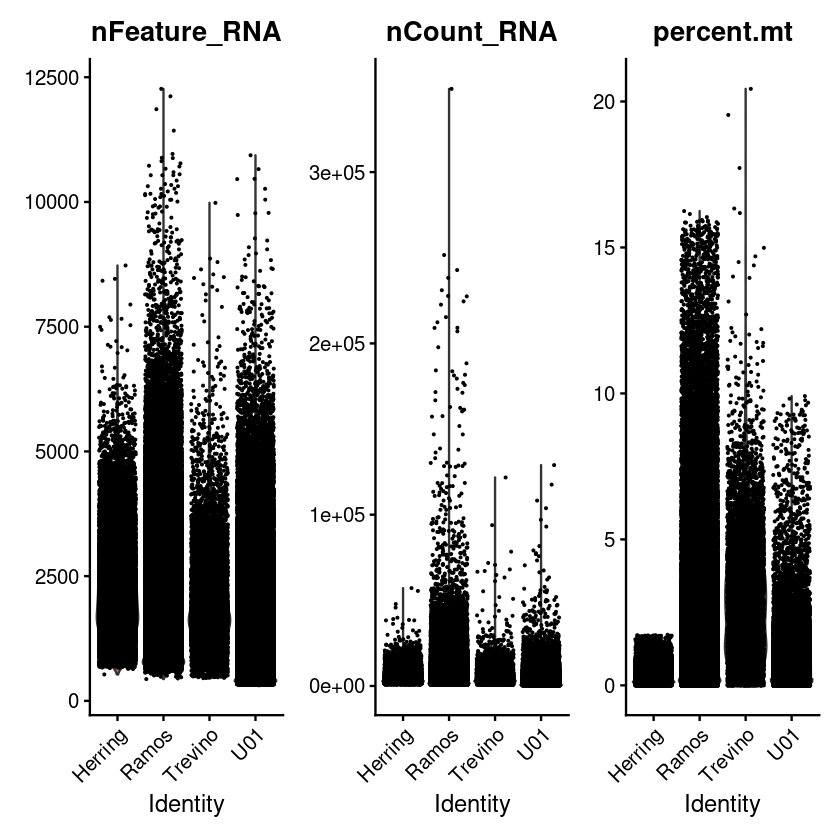

In [9]:
seurat_fetal[["percent.mt"]] <- PercentageFeatureSet(seurat_fetal, pattern = "^MT-")
VlnPlot(seurat_fetal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [18]:
table(metadata$dataset)
table(seurat_fetal@meta.data$orig.ident)


  Herring     Ramos   Trevino Velmeshev 
    26580    178580      8981    219704 


Herring   Ramos Trevino     U01 
  26580  178580    8981  219704 

In [10]:
seurat_fetal_filtered <- subset(seurat_fetal, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [11]:
seurat_fetal_filtered

An object of class Seurat 
20116 features across 336532 samples within 1 assay 
Active assay: RNA (20116 features, 0 variable features)

In [12]:
seurat_fetal_filtered@meta.data$cell <- rownames(seurat_fetal_filtered@meta.data)
seurat_fetal_filtered@meta.data <- seurat_fetal_filtered@meta.data %>% inner_join(metadata, by = "cell")
Idents(seurat_fetal_filtered) <- seurat_fetal_filtered@meta.data$lineage

In [14]:
seurat_fetal_filtered <- NormalizeData(seurat_fetal_filtered)

In [15]:
all.genes <- rownames(seurat_fetal_filtered)
seurat_fetal_filtered <- ScaleData(seurat_fetal_filtered, features = all.genes)

Centering and scaling data matrix



In [16]:
seurat_fetal_filtered

An object of class Seurat 
20116 features across 336532 samples within 1 assay 
Active assay: RNA (20116 features, 0 variable features)

In [27]:
table(seurat_fetal_filtered@meta.data$lineage)


      AST     ExNeu GLIALPROG        IN        MG        OL       OPC       OUT 
    22718    200344      6820     93129      3208        22      6465       983 
     VASC 
     2843 

In [28]:
table(metamarker_top100$cell_type)


    Dividing_Progenitor               GABAergic           Glutamatergic 
                    100                     100                     100 
Intermediate_Progenitor       Neural_Progenitor            Non-neuronal 
                    100                     100                     100 
                  other 
                    100 

In [17]:
# map Velmeshev lineage to metamarker types, see table 2 of Werner 2023
seurat_fetal_filtered@meta.data$mm_cluster <- NA
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "AST", 'mm_cluster'] <- 'Non-neuronal'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "ExNeu", 'mm_cluster'] <- 'Glutamatergic'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "GLIALPROG", 'mm_cluster'] <- 'Neural_Progenitor'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "IN", 'mm_cluster'] <- 'GABAergic'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "MG", 'mm_cluster'] <- 'Non-neuronal'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "OL", 'mm_cluster'] <- 'Non-neuronal'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "OPC", 'mm_cluster'] <- 'Non-neuronal'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "VASC", 'mm_cluster'] <- 'Non-neuronal'
seurat_fetal_filtered@meta.data[seurat_fetal_filtered@meta.data$lineage == "OUT", 'mm_cluster'] <- 'other'

In [18]:
cpm_matrix <- RelativeCounts(seurat_fetal_filtered@assays$RNA@counts) * 1e6
range(colSums(cpm_matrix))
dim(cpm_matrix)

[1] 1e+06 1e+06

[1]  20116 336532

In [19]:
lineage_categories <- unique(seurat_fetal_filtered@meta.data$mm_cluster)

In [23]:
lineage_categories

[1] "Glutamatergic"     "Non-neuronal"      "GABAergic"        
[4] "other"             "Neural_Progenitor"

In [20]:
cpm_values <- matrix(NA, nrow = length(lineage_categories), ncol = nrow(seurat_fetal_filtered@assays$RNA@counts))

In [21]:
for (i in 1:length(lineage_categories)) {
  lineage <- lineage_categories[i]
  lineage_indices <- which(seurat_fetal_filtered@meta.data$mm_cluster == lineage)
  cpm_subset <- cpm_matrix[, lineage_indices]
  cpm_values[i, ] <- rowMeans(cpm_subset)
}

In [22]:
head(cpm_values)

[,1] [,2] [,3] [,4] [,5]       [,6]     [,7]       [,8]      [,9]    
[1,] 0    0    0    0    0.09095806 2.411026 0.15188939 0.4119835 40.30708
[2,] 0    0    0    0    0.19923511 4.579874 0.28321363 5.4577037 32.53659
[3,] 0    0    0    0    0.04586027 2.563484 0.20345014 0.3775170 36.40051
[4,] 0    0    0    0    0.00000000 4.231260 0.00000000 2.2688140 29.50417
[5,] 0    0    0    0    0.00000000 2.279062 0.07557884 0.3289167 31.88064
     [,10]    [,11] [,12]    [,13]    [,14]     [,15]     [,16]    [,17]   
[1,] 6.040191 ...   681.6220 13.87515  900.2627 1391.7891 477.1370 57.15855
[2,] 5.523044 ...   744.1581 17.39577 1014.0583 1138.6372 854.6236 86.43413
[3,] 5.783512 ...   740.3376 17.68040 1130.7958 1413.3704 600.1874 65.93849
[4,] 6.047942 ...   530.3935 18.42942  681.3687  822.0053 463.0261 65.11458
[5,] 3.290566 ...   649.1459 13.17105  899.3034 1187.9886 442.5302 43.57056
     [,18]    [,19]    [,20]    [,21]   
[1,] 682.8408 126.3977 22.09095 619.1697
[2,] 734.9892 187.7924 15.80683 586.1155
[3,] 653.5617 144.8911 15.64890 651.0022
[4,] 557.5031 149.3710 15.02802 428.3281
[5,] 554.1788 111.8158 19.39004 549.5669

In [24]:
range(rowSums(cpm_values))

[1] 1e+06 1e+06

In [25]:
cpm_df <- as.data.frame(cpm_values)
rownames(cpm_df) <- lineage_categories
colnames(cpm_df) <- rownames(seurat_fetal_filtered@assays$RNA@counts)

ref <- as.data.frame(t(cpm_df))
head(ref)

Glutamatergic Non-neuronal GABAergic  other   Neural_Progenitor
FAM138A   0.00000000    0.0000000    0.00000000 0.00000 0.000000         
OR4F5     0.00000000    0.0000000    0.00000000 0.00000 0.000000         
OR4F29    0.00000000    0.0000000    0.00000000 0.00000 0.000000         
OR4F16    0.00000000    0.0000000    0.00000000 0.00000 0.000000         
FAM87B    0.09095806    0.1992351    0.04586027 0.00000 0.000000         
LINC00115 2.41102596    4.5798743    2.56348425 4.23126 2.279062

In [26]:
range(colSums(ref))

[1] 1e+06 1e+06

In [31]:
ref$NAME <- rownames(ref)
ref_mm <- ref %>% filter(NAME %in% metamarker_top100$gene)
dim(ref_mm)
dim(ref)

[1] 669   6

[1] 20116     6

In [27]:
head(metamarker_top100)

group cell_type           rank gene   recurrence auroc     fold_change
1 all   Dividing_Progenitor 1    HMGB2  37         0.9196456 12.098900  
2 all   Dividing_Progenitor 2    SMC4   37         0.8290742  9.549320  
3 all   Dividing_Progenitor 3    TOP2A  37         0.8236546 24.001023  
4 all   Dividing_Progenitor 4    MAD2L1 37         0.8181440 13.404371  
5 all   Dividing_Progenitor 5    CENPF  37         0.8076775 18.597946  
6 all   Dividing_Progenitor 6    CKS2   37         0.8007071  8.068247  
  fold_change_detection expression precision ... linnarsson_GW8_point_1
1 2.922189              1763.4911  0.3844271 ... TRUE                  
2 4.655425               489.4520  0.4906879 ... TRUE                  
3 8.238484               887.3805  0.6190882 ... TRUE                  
4 8.224589               327.6109  0.6191680 ... TRUE                  
5 7.258082               717.7156  0.5865036 ... TRUE                  
6 3.498360               541.6885  0.4244148 ... TRUE                  
  linnarsson_GW8_point_5_1 linnarsson_GW8_point_5_2 linnarsson_GW9_point_2
1 TRUE                     TRUE                     TRUE                  
2 TRUE                     TRUE                     TRUE                  
3 TRUE                     TRUE                     TRUE                  
4 TRUE                     TRUE                     TRUE                  
5 TRUE                     TRUE                     TRUE                  
6 TRUE                     TRUE                     TRUE                  
  linnarsson_GW9_point_5 linnarsson_GW10 linnarsson_GW11_point_5
1 TRUE                   TRUE            TRUE                   
2 TRUE                   TRUE            TRUE                   
3 TRUE                   TRUE            TRUE                   
4 TRUE                   TRUE            TRUE                   
5 TRUE                   TRUE            TRUE                   
6 TRUE                   TRUE            TRUE                   
  linnarsson_GW12 linnarsson_GW13 linnarsson_GW14
1 TRUE            TRUE            TRUE           
2 TRUE            TRUE            TRUE           
3 TRUE            TRUE            TRUE           
4 TRUE            TRUE            TRUE           
5 TRUE            TRUE            TRUE           
6 TRUE            TRUE            TRUE

In [28]:
length(unique(metamarker_top100$gene))

[1] 681

In [29]:
metamarker_top100[which(duplicated(metamarker_top100$gene)),]

group cell_type               rank gene     recurrence auroc     fold_change
1  all   Intermediate_Progenitor  10  DLX5     15         0.5271307 1.2034961  
2  all   Intermediate_Progenitor  13  SP9      11         0.5404985 1.5124122  
3  all   Intermediate_Progenitor  15  DLX2     11         0.5301560 1.0911886  
4  all   Intermediate_Progenitor  20  DLX1      8         0.5161456 0.8660081  
5  all   Intermediate_Progenitor  31  ST8SIA5   6         0.5336213 1.4377764  
6  all   Intermediate_Progenitor  33  DLX6-AS1  6         0.5225275 1.0006944  
7  all   Intermediate_Progenitor  50  BARHL1    5         0.5147324 0.8102794  
8  all   Intermediate_Progenitor  59  RASGEF1B  4         0.5299566 1.3398044  
9  all   Intermediate_Progenitor  60  NRN1      4         0.5228767 1.0319403  
10 all   Intermediate_Progenitor  70  SCGN      4         0.5031588 0.9007791  
11 all   Intermediate_Progenitor  72  CALB2     4         0.4949245 0.4898425  
12 all   Intermediate_Progenitor  76  CHST8     3         0.5375164 1.7480615  
13 all   Intermediate_Progenitor  98  TFAP2D    3         0.5010823 0.6596624  
14 all   Intermediate_Progenitor 100  NXPH4     3         0.4934493 0.6972117  
15 all   Neural_Progenitor        97  CD9      15         0.5640081 3.3479695  
16 all   other                    10  OLFML3   27         0.5505061 9.6055508  
17 all   other                    13  S100A11  26         0.5667562 9.6666832  
18 all   other                    37  COL1A2   19         0.5607638 7.3559086  
19 all   other                    90  HLA-E    14         0.5570300 3.9653618  
   fold_change_detection expression precision  ... linnarsson_GW8_point_1
1  0.9449339               0.000000 0.02680207 ... FALSE                 
2  1.4051302               0.000000 0.03741423 ... FALSE                 
3  0.8735420               0.000000 0.02437286 ... FALSE                 
4  0.8179592               0.000000 0.02292388 ... FALSE                 
5  1.3638819               0.000000 0.03303298 ... FALSE                 
6  1.0094846               0.000000 0.02455702 ... FALSE                 
7  0.7724723               0.000000         NA ... FALSE                 
8  1.3753167             132.459569 0.04818475 ... FALSE                 
9  1.0402317              69.557300 0.04703342 ... FALSE                 
10 1.1550892               0.000000 0.03381374 ... FALSE                 
11 0.5726013               8.855996 0.01596018 ... FALSE                 
12 1.4960323               0.000000 0.03226091 ... FALSE                 
13 0.6906632               0.000000         NA ... FALSE                 
14 0.6778441               0.000000 0.04729142 ... FALSE                 
15 3.0111959              48.362159 0.30945871 ... FALSE                 
16 7.9474183              31.900539 0.45830204 ... FALSE                 
17 6.7830436              68.094629 0.41441333 ... FALSE                 
18 3.5031903              85.949613 0.26982701 ... FALSE                 
19 2.9123781              36.529656 0.23443631 ... FALSE                 
   linnarsson_GW8_point_5_1 linnarsson_GW8_point_5_2 linnarsson_GW9_point_2
1   TRUE                     TRUE                     TRUE                 
2   TRUE                     TRUE                    FALSE                 
3   TRUE                     TRUE                     TRUE                 
4   TRUE                     TRUE                     TRUE                 
5  FALSE                     TRUE                    FALSE                 
6  FALSE                     TRUE                     TRUE                 
7  FALSE                    FALSE                    FALSE                 
8  FALSE                    FALSE                    FALSE                 
9  FALSE                    FALSE                    FALSE                 
10 FALSE                    FALSE                    FALSE                 
11 FALSE                    FALSE                    FALSE                 
12 FALSE   

In [30]:
metamarker_top100 %>% filter(gene == "DLX5")

group cell_type               rank gene recurrence auroc     fold_change
1 all   GABAergic                4   DLX5 34         0.6867152 14.913933  
2 all   Intermediate_Progenitor 10   DLX5 15         0.5271307  1.203496  
  fold_change_detection expression precision  ... linnarsson_GW8_point_1
1 11.2527666            0          0.68481929 ...  TRUE                 
2  0.9449339            0          0.02680207 ... FALSE                 
  linnarsson_GW8_point_5_1 linnarsson_GW8_point_5_2 linnarsson_GW9_point_2
1 TRUE                     FALSE                    TRUE                  
2 TRUE                      TRUE                    TRUE                  
  linnarsson_GW9_point_5 linnarsson_GW10 linnarsson_GW11_point_5
1 TRUE                    TRUE           TRUE                   
2 TRUE                   FALSE           TRUE                   
  linnarsson_GW12 linnarsson_GW13 linnarsson_GW14
1 TRUE             TRUE           TRUE           
2 TRUE            FALSE           TRUE

In [32]:
head(ref_mm)

Glutamatergic Non-neuronal GABAergic  other      Neural_Progenitor
HES5     2.266402    59.021543     7.3816611  51.991402 27.3229321       
NPPA     1.970798     2.367957     3.4987300   3.573422  1.2772416       
IGSF21 159.798510    87.304189    45.5072464 154.057205 21.2544791       
C1QA     1.798160    22.052773     0.8671961  14.525090  0.8900942       
C1QC     2.199666    19.019745     1.1670277  10.471618  1.2605425       
C1QB     2.186833    26.372170     1.2835874  15.051516  1.4457499       
       NAME  
HES5   HES5  
NPPA   NPPA  
IGSF21 IGSF21
C1QA   C1QA  
C1QC   C1QC  
C1QB   C1QB

In [33]:
ref_mm <- ref_mm %>% select(6, c(1:5))
write.table(ref_mm, "~/project-gandalm/isoform_twas/eqtl_new/velmeshev_metamarkers100_sig_matrix.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

In [47]:
head(rowSums(seurat_fetal_filtered@assays$RNA@counts > 0) >= 3)

FAM138A     OR4F5    OR4F29    OR4F16    FAM87B LINC00115 
    FALSE     FALSE     FALSE     FALSE      TRUE      TRUE

In [48]:
# Calculate the number of cells expressing each gene
cells_per_gene <- rowSums(seurat_fetal_filtered@assays$RNA@counts > 0)

In [49]:
head(cells_per_gene)

FAM138A     OR4F5    OR4F29    OR4F16    FAM87B LINC00115 
        0         0         0         0        45      1797

In [50]:
# Filter genes expressed in at least 3 cells
genes_expressed_in_3_cells <- names(cells_per_gene[cells_per_gene >= 3])
head(genes_expressed_in_3_cells)

[1] "FAM87B"    "LINC00115" "FAM41C"    "SAMD11"    "NOC2L"     "KLHL17"

In [51]:
# Filter the Seurat object based on genes expressed in at least 3 cells
seurat_fetal_filtered_final <- subset(seurat_fetal_filtered, features = genes_expressed_in_3_cells)

In [52]:
seurat_fetal_filtered_final

An object of class Seurat 
19034 features across 336532 samples within 1 assay 
Active assay: RNA (19034 features, 0 variable features)

**3. add metadata**

In [20]:
seurat_fetal_filtered_final@meta.data$cell <- rownames(seurat_fetal_filtered_final@meta.data)
seurat_fetal_filtered_final@meta.data <- seurat_fetal_filtered_final@meta.data %>% inner_join(metadata, by = "cell")
Idents(seurat_fetal_filtered_final) <- seurat_fetal_filtered_final@meta.data$lineage

**4. normalize across cells, and feature selection**

In [53]:
seurat_fetal_filtered_final <- NormalizeData(seurat_fetal_filtered_final)

In [54]:
seurat_fetal_filtered_final <- FindVariableFeatures(seurat_fetal_filtered_final, selection.method = "vst", nfeatures = 2000)

**5. scale data across features, and PCA**

In [55]:
all.genes <- rownames(seurat_fetal_filtered_final)
seurat_fetal_filtered_final <- ScaleData(seurat_fetal_filtered_final, features = all.genes)

Centering and scaling data matrix



PC_ 1 
Positive:  LRIG1, NEAT1, SLC1A3, TNC, MSI2, EEPD1, QKI, ZBTB20, PARD3B, FBXL7 
	   AQP4, ZFP36L1, ATP1A2, RNF219-AS1, DAAM2, ZEB1, MMD2, RFX4, GFAP, GPC5 
	   LINC00609, DOCK1, LTBP1, BCAN, TCF7L2, NPAS3, MAML2, FAM189A2, FOXO1, TRPS1 
Negative:  RBFOX1, ARPP21, RALYL, SATB2, DAB1, FRMPD4, KCNQ5, XKR4, GRM7, IQCJ-SCHIP1 
	   TENM2, CCBE1, RYR2, CNTN4, LINGO2, KLHL1, CALN1, SYN3, OPCML, SHISA9 
	   DPYD, SYBU, FAM19A1, CSMD1, FGF14, ZNF385B, KHDRBS3, PRICKLE2, GRIA1, C8orf34 
PC_ 2 
Positive:  CASC15, SOX11, DLX6-AS1, SYNE2, AC072062.1, EPHA3, TMEM123, MOB3B, ZNF536, ZNF704 
	   BCL11B, HMGB2, MEIS2, H3F3A, RPL9, PLS3, CUX2, ST8SIA5, ARX, EPHA5 
	   DLX1, VIM, ZBTB20, SLAIN1, CHD7, NXN, HUNK, TOP2A, RASGEF1B, PHF21B 
Negative:  CSMD1, LRRC4C, LRP1B, OPCML, KCNMA1, DPP10, KAZN, NTRK2, SYN3, PRICKLE2 
	   XKR4, CALN1, LRRTM4, FGF14, FRMPD4, RYR2, LINGO2, CSMD2, KCNQ5, CSGALNACT1 
	   CHRM3, MDGA2, KHDRBS3, NEBL, KCNIP4, ARPP21, MGAT4C, C8orf34, GABRG3, RALYL 
PC_ 3 
Positive:  RASG

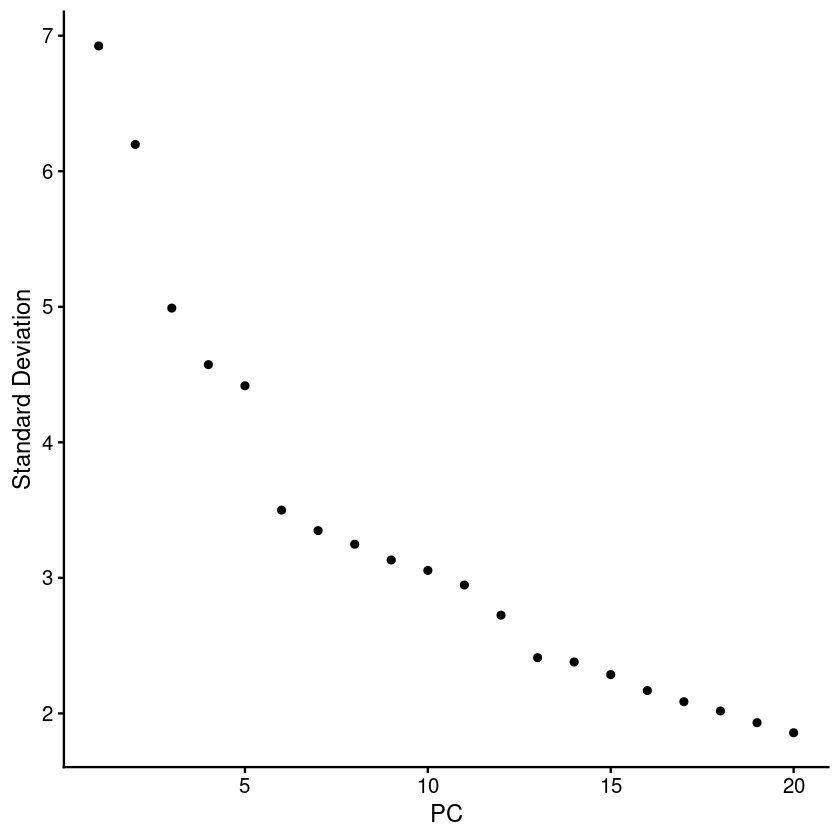

In [56]:
# run PCA on scaled data
seurat_fetal_filtered_final <- RunPCA(seurat_fetal_filtered_final, features = VariableFeatures(object = seurat_fetal_filtered_final))
ElbowPlot(seurat_fetal_filtered_final)

**6. UMAP**

In [57]:
seurat_fetal_filtered_final <- RunUMAP(seurat_fetal_filtered_final, dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:56:36 UMAP embedding parameters a = 0.9922 b = 1.112

16:56:37 Read 336532 rows and found 20 numeric columns

16:56:37 Using Annoy for neighbor search, n_neighbors = 30

16:56:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:57:50 Writing NN index file to temp file /tmp/RtmpTUT4yd/file7b0770ac0ad0

16:57:50 Searching Annoy index using 1 thread, search_k = 3000

17:01:20 Annoy recall = 100%

17:01:21 Commencing smooth kNN distance calibration using 1 thread

17:01:51 Initializing f

In [59]:
seurat_fetal_filtered_final

An object of class Seurat 
19034 features across 336532 samples within 1 assay 
Active assay: RNA (19034 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [58]:
DimPlot(seurat_fetal_filtered_final, reduction = "umap", label = T, group.by = "lineage")

ERROR: Error: Cannot find 'lineage' in this Seurat object


**table(metadata$lineage)**

      AST     ExNeu GLIALPROG        IN        MG        OL       OPC       OUT
    26645    274907     10680    104152      3740        33      7766      2141
     VASC
     3781

**7. find markers**

In [30]:
markers <- FindAllMarkers(seurat_fetal_filtered_final, 
                          only.pos = TRUE,
                          logfc.threshold = 0.25,
                          min.pct = 0.5)

Calculating cluster ExNeu

Calculating cluster AST

Calculating cluster OPC

Calculating cluster IN

Calculating cluster MG

Calculating cluster OUT

Calculating cluster VASC

Calculating cluster GLIALPROG

Calculating cluster OL



In [31]:
head(markers)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene       
SATB2       0     2.443927   0.787 0.245 0         ExNeu   SATB2      
RALYL       0     2.144534   0.698 0.298 0         ExNeu   RALYL      
ARPP21      0     2.106391   0.727 0.291 0         ExNeu   ARPP21     
IQCJ-SCHIP1 0     2.054556   0.535 0.213 0         ExNeu   IQCJ-SCHIP1
FAM19A1     0     1.948316   0.569 0.241 0         ExNeu   FAM19A1    
KCNQ5       0     1.781503   0.539 0.220 0         ExNeu   KCNQ5

In [32]:
write.table(markers, "markers.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

In [34]:
dim(seurat_fetal_filtered_final@meta.data)

[1] 336532     19

In [35]:
seurat_fetal_filtered_final@assays$RNA@counts[1:3,1:3]

3 x 3 sparse Matrix of class "dgCMatrix"
          U01_AAACCTGAGTTTAGGA-1_A14-103_FC U01_AAACGGGCACTCAGGC-1_A14-103_FC
FAM87B                                    .                                 .
LINC00115                                 .                                 .
FAM41C                                    .                                 .
          U01_AAACGGGCAGATAATG-1_A14-103_FC
FAM87B                                    .
LINC00115                                 .
FAM41C                                    .

**8. generate reference matrix in CPM scale**

In [76]:
# reference
# ref <- cpm(t(apply(seurat_fetal_filtered_final@assays$RNA@counts,1,function(x){tapply(x,seurat_fetal_filtered_final@meta.data$lineage,median)})),log=F)

In [77]:
# cpm_matrix <- RelativeCounts(data = seurat_fetal_filtered_final@assays$RNA@counts) * 1e6
# cpm_matrix

In [58]:
cpm_matrix <- RelativeCounts(seurat_fetal_filtered_final@assays$RNA@counts) * 1e6

In [78]:
range(colSums(cpm_matrix))
dim(cpm_matrix)

[1] 1e+06 1e+06

[1]  19034 336532

In [ ]:
lineage_categories <- unique(seurat_fetal_filtered_final@meta.data$lineage)

In [ ]:
cpm_values <- matrix(NA, nrow = length(lineage_categories), ncol = nrow(seurat_fetal_filtered_final@assays$RNA@counts))

In [61]:
# reference matrix: for each gene, get the mean of cpm values across all cells for each cluster
for (i in 1:length(lineage_categories)) {
  lineage <- lineage_categories[i]
  lineage_indices <- which(seurat_fetal_filtered_final@meta.data$lineage == lineage)
  cpm_subset <- cpm_matrix[, lineage_indices]
  cpm_values[i, ] <- rowMeans(cpm_subset)
}

In [64]:
rowSums(cpm_values)

[1] 1e+06 1e+06 1e+06 1e+06 1e+06 1e+06 1e+06 1e+06 1e+06

In [65]:
cpm_df <- as.data.frame(cpm_values)

In [66]:
rownames(cpm_df) <- lineage_categories

In [67]:
colnames(cpm_df) <- rownames(seurat_fetal_filtered_final@assays$RNA@counts)

In [68]:
write.table(cpm_df, "cpm_df.tsv", col.names=T,row.names=T,quote=F,sep="\t")

In [69]:
dim(cpm_df)

[1]     9 19034

In [71]:
cpm_df_t <- as.data.frame(t(cpm_df))

In [72]:
head(cpm_df_t)

ExNeu       AST        OPC         IN          MG         OUT      
FAM87B     0.09095806  0.1040933  0.09583584  0.04586027  1.2593090  0.000000
LINC00115  2.41103435  4.4039254  3.19066764  2.56348556 10.2317719  4.231260
FAM41C     0.15188939  0.3146722  0.27518204  0.20345014  0.1066441  0.000000
SAMD11     0.41198351  7.7504419  0.28111673  0.37751885  0.5980427  2.268814
NOC2L     40.30709858 30.7917097 32.87642665 36.40052457 40.5557910 29.504167
KLHL17     6.04019137  5.2175112  7.13622341  5.78351596  4.1061559  6.047942
          VASC       GLIALPROG   OL      
FAM87B     0.0000000  0.00000000  0.00000
LINC00115  2.8028419  2.27906233  0.00000
FAM41C     0.2515268  0.07557884  0.00000
SAMD11     4.0923338  0.32891674 44.17351
NOC2L     36.5850195 31.88065871 42.15059
KLHL17     5.9377477  3.29056578  0.00000

In [73]:
write.table(cpm_df_t, "cpm_df_t.tsv", col.names=T,row.names=T,quote=F,sep="\t")

In [75]:
range(colSums(cpm_df_t))

[1] 1e+06 1e+06

**9. Load pre-saved data, run CIBERSORT**

In [2]:
markers <- fread("/u/project/gandalm/shared/GenomicDatasets/scRNAseq/Velmeshev_Kriegstein_biorxiv2022/UCSC_v2/markers.tsv", data.table = F)
head(markers)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene       
1 0     2.443927   0.787 0.245 0         ExNeu   SATB2      
2 0     2.144534   0.698 0.298 0         ExNeu   RALYL      
3 0     2.106391   0.727 0.291 0         ExNeu   ARPP21     
4 0     2.054556   0.535 0.213 0         ExNeu   IQCJ-SCHIP1
5 0     1.948316   0.569 0.241 0         ExNeu   FAM19A1    
6 0     1.781503   0.539 0.220 0         ExNeu   KCNQ5

In [3]:
cpm_df_t <- fread("/u/project/gandalm/shared/GenomicDatasets/scRNAseq/Velmeshev_Kriegstein_biorxiv2022/UCSC_v2/cpm_df_t.tsv", data.table = F)
rownames(cpm_df_t) <- cpm_df_t$V1
cpm_df_t <- cpm_df_t[,-1]
head(cpm_df_t)

Warning message in fread("/u/project/gandalm/shared/GenomicDatasets/scRNAseq/Velmeshev_Kriegstein_biorxiv2022/UCSC_v2/cpm_df_t.tsv", :
“Detected 9 column names but the data has 10 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


ExNeu       AST        OPC         IN          MG         OUT      
FAM87B     0.09095806  0.1040933  0.09583584  0.04586027  1.2593090  0.000000
LINC00115  2.41103435  4.4039254  3.19066764  2.56348556 10.2317719  4.231260
FAM41C     0.15188939  0.3146722  0.27518204  0.20345014  0.1066441  0.000000
SAMD11     0.41198351  7.7504419  0.28111673  0.37751885  0.5980427  2.268814
NOC2L     40.30709858 30.7917097 32.87642665 36.40052457 40.5557910 29.504167
KLHL17     6.04019137  5.2175112  7.13622341  5.78351596  4.1061559  6.047942
          VASC       GLIALPROG   OL      
FAM87B     0.0000000  0.00000000  0.00000
LINC00115  2.8028419  2.27906233  0.00000
FAM41C     0.2515268  0.07557884  0.00000
SAMD11     4.0923338  0.32891674 44.17351
NOC2L     36.5850195 31.88065871 42.15059
KLHL17     5.9377477  3.29056578  0.00000

**raw gene counts, corrected for batch. No covariates**

In [23]:
# raw gene counts, corrected for batch. No covariates
bulk <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/genes.combatseq.tsv", data.table = F)
bulk <- bulk %>% inner_join(annot, by = c("V1" = "ensg"))

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/genes.combatseq.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [24]:
bulk <- bulk %>% select(1:643, V12)
head(bulk)

V1              1474 1496 1500 1502 1507 1511 1513 1525 1531 ... 1607 1707.1
1 ENSG00000000419 1025 594  671  451  287  558  659  508  178  ... 1018 611   
2 ENSG00000000457  737 668  624  660  437  404  611  508  121  ...  650 530   
3 ENSG00000000460 1128 368  689  496  352  509  558  277   96  ...  644 303   
4 ENSG00000000938    6  27   13   13   13    7    6   20    3  ...  149  16   
5 ENSG00000000971  116 493  328  103  143   40  225   76   14  ... 1609 537   
6 ENSG00000001036  431 389  361  217  229  262  217  284   87  ...  580 414   
  1835 1851 1890 1923 2193 849 898  V12     
1 4321 931  1491 7795 574  608  598 DPM1    
2 2955 547  1284 7104 548  760  670 SCYL3   
3 2519 428  1119 4053 351  375  366 C1orf112
4   59  35    56  314  17   28   60 FGR     
5  296 647  2402 4183 566  233 1014 CFH     
6 1669 488   986 3921 427  436  656 FUCA2

In [25]:
dup.genes <- bulk[which(duplicated(bulk$V12)),'V12']
length(dup.genes)

[1] 543

In [26]:
bulk <- bulk %>% filter(!V12 %in% dup.genes)

In [13]:
bulk.matrix <- bulk %>% select(-V1, -V12)
# ref matrix is in CPM
# convert mixture to CPM also
# Convert the count matrix to a DGEList object
dge <- DGEList(counts = bulk.matrix)

# Calculate library sizes (total counts per sample)
dge$samples$lib.size <- colSums(dge$counts)

# Calculate CPM
cpm_matrix <- cpm(dge)
bulk.cpm <- as.data.frame(cpm_matrix)

In [14]:
rownames(bulk.cpm) <- bulk$V12

In [91]:
head(markers)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene       
SATB2       0     2.443927   0.787 0.245 0         ExNeu   SATB2      
RALYL       0     2.144534   0.698 0.298 0         ExNeu   RALYL      
ARPP21      0     2.106391   0.727 0.291 0         ExNeu   ARPP21     
IQCJ-SCHIP1 0     2.054556   0.535 0.213 0         ExNeu   IQCJ-SCHIP1
FAM19A1     0     1.948316   0.569 0.241 0         ExNeu   FAM19A1    
KCNQ5       0     1.781503   0.539 0.220 0         ExNeu   KCNQ5

In [92]:
table(markers$cluster)


    ExNeu       AST       OPC        IN        MG       OUT      VASC GLIALPROG 
      133       117       187       109       123       180        69       199 
       OL 
      139 

In [21]:
markers_top100 <- markers %>%
                    group_by(cluster) %>%
                    slice_head(n = 100)%>%
                    ungroup()

In [16]:
range(markers$p_val_adj)

[1] 0 1

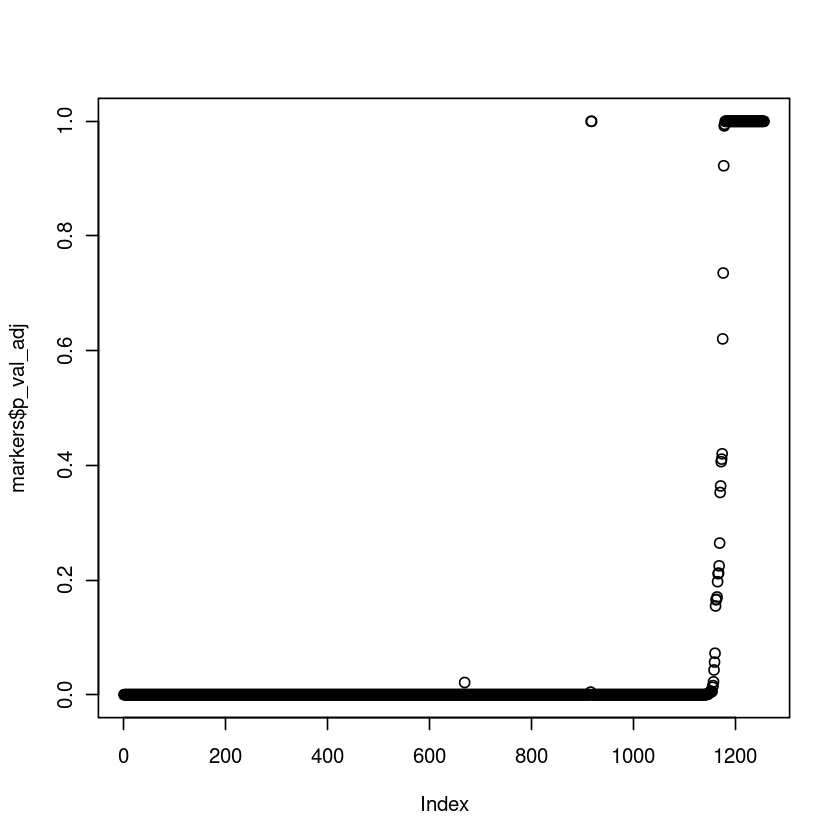

In [17]:
plot(markers$p_val_adj)

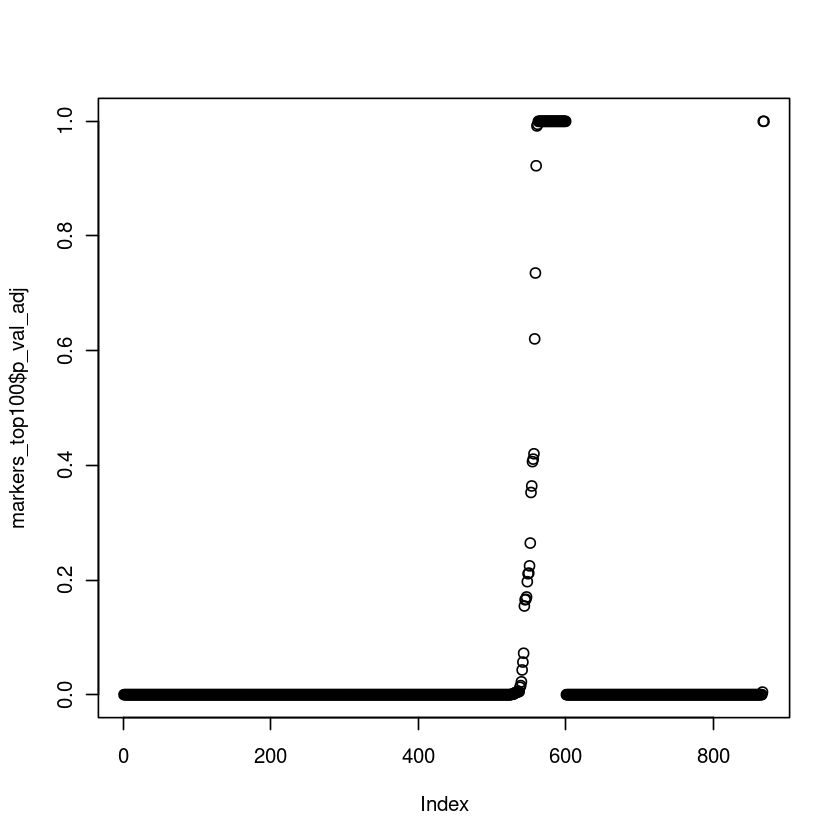

In [18]:
plot(markers_top100$p_val_adj)

In [33]:
# use all marker genes
tmp <- intersect(markers$gene, rownames(cpm_df_t))
length(tmp)
tmp <- intersect(tmp,rownames(bulk.cpm))
length(tmp)

[1] 770

[1] 738

In [34]:
sig <- cpm_df_t[match(tmp, rownames(cpm_df_t)),]
mix <- bulk.cpm[match(tmp,rownames(bulk.cpm)),]
rownames(mix) <- rownames(sig)
dim(sig)
dim(mix)

[1] 738   9

[1] 738 642

In [35]:
source('~/project-gandalm/isoform_twas/eqtl_new/code/scripts/CIBERSORT.R')
cbprop_test <- CIBERSORT(sig, mix, perm=0, QN=TRUE, absolute=FALSE, abs_method='sig.score')[,1:ncol(sig)]

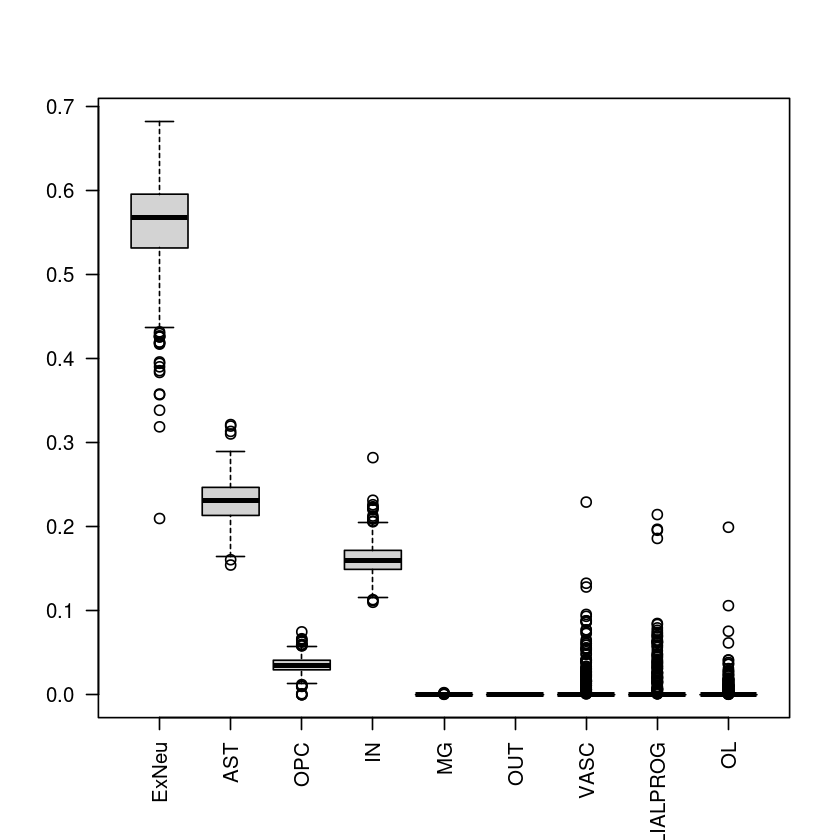

In [36]:
boxplot(cbprop_test,las=2)

In [37]:
cbprop.1 <- as.data.frame(cbprop_test)
cbprop.1$sampleID <- rownames(cbprop.1)
# head(cbprop.1)
cbprop.1 <- cbprop.1 %>% inner_join(bulk.meta, by = c("sampleID" = "Subject"))
prop <- melt(cbprop.1, id=c('sampleID',colnames(bulk.meta)[2:8]))
# head(prop)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


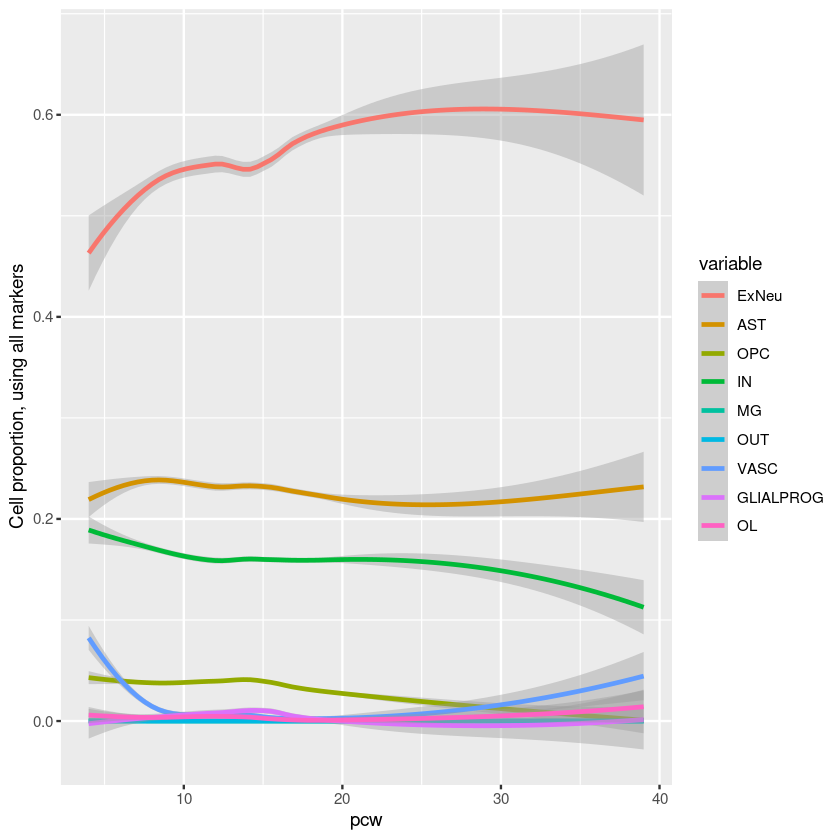

In [38]:
ggplot(prop, aes(x = pcw, y = value, color = variable))+
    geom_smooth()+
    labs(y='Cell proportion, using all markers')

In [20]:
# use top 100 markers per lineage
tmp <- intersect(markers_top100$gene, rownames(cpm_df_t))
length(tmp)
tmp <- intersect(tmp,rownames(bulk.cpm))
length(tmp)

[1] 609

[1] 584

In [21]:
sig <- cpm_df_t[match(tmp, rownames(cpm_df_t)),]
mix <- bulk.cpm[match(tmp,rownames(bulk.cpm)),]
rownames(mix) <- rownames(sig)
dim(sig)
dim(mix)

[1] 584   9

[1] 584 642

In [22]:
source('~/project-gandalm/isoform_twas/eqtl_new/code/scripts/CIBERSORT.R')
cbprop <- CIBERSORT(sig, mix, perm=0, QN=TRUE, absolute=FALSE, abs_method='sig.score')[,1:ncol(sig)]

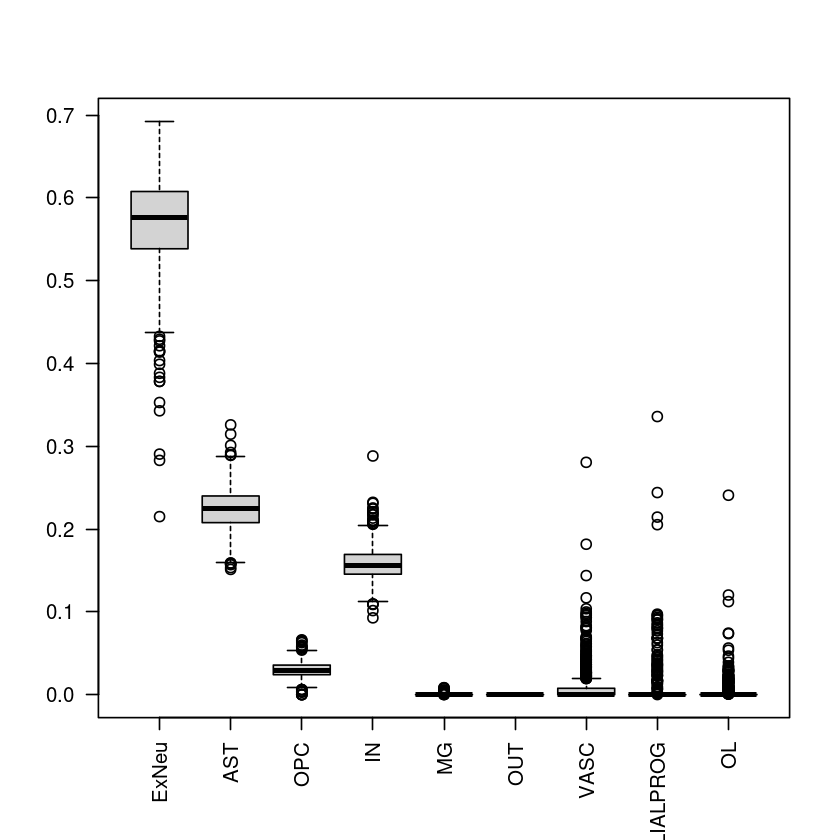

In [23]:
boxplot(cbprop,las=2)

In [25]:
head(cbprop)

ExNeu     AST       OPC        IN        MG         OUT VASC       
1474 0.4034952 0.2766006 0.05654480 0.1761348 0.00000000 0   0.009376238
1496 0.5605176 0.2170121 0.02839783 0.1581154 0.00000000 0   0.035957050
1500 0.5125002 0.2440654 0.04173290 0.1697085 0.00000000 0   0.000000000
1502 0.5403850 0.2516794 0.03229165 0.1693714 0.00180748 0   0.004465094
1507 0.5766982 0.2337177 0.02237497 0.1362042 0.00000000 0   0.031004999
1511 0.4523867 0.2512984 0.04135384 0.1646692 0.00000000 0   0.000000000
     GLIALPROG  OL        
1474 0.05990867 0.01793977
1496 0.00000000 0.00000000
1500 0.03199294 0.00000000
1502 0.00000000 0.00000000
1507 0.00000000 0.00000000
1511 0.09029177 0.00000000

In [27]:
write.table(cbprop, "/u/project/gandalm/shared/GenomicDatasets/scRNAseq/Velmeshev_Kriegstein_biorxiv2022/UCSC_v2/cbprop.tsv", 
            col.names = T, row.names = T, quote = F, sep = "\t")

In [26]:
bulk.meta <- read.table("../metadata_654.tsv", header = T)

In [28]:
cbprop.1 <- as.data.frame(cbprop)
cbprop.1$sampleID <- rownames(cbprop.1)
head(cbprop.1)
cbprop.1 <- cbprop.1 %>% inner_join(bulk.meta, by = c("sampleID" = "Subject"))
prop <- melt(cbprop.1, id=c('sampleID',colnames(bulk.meta)[2:8]))
head(prop)

ExNeu     AST       OPC        IN        MG         OUT VASC       
1474 0.4034952 0.2766006 0.05654480 0.1761348 0.00000000 0   0.009376238
1496 0.5605176 0.2170121 0.02839783 0.1581154 0.00000000 0   0.035957050
1500 0.5125002 0.2440654 0.04173290 0.1697085 0.00000000 0   0.000000000
1502 0.5403850 0.2516794 0.03229165 0.1693714 0.00180748 0   0.004465094
1507 0.5766982 0.2337177 0.02237497 0.1362042 0.00000000 0   0.031004999
1511 0.4523867 0.2512984 0.04135384 0.1646692 0.00000000 0   0.000000000
     GLIALPROG  OL         sampleID
1474 0.05990867 0.01793977 1474    
1496 0.00000000 0.00000000 1496    
1500 0.03199294 0.00000000 1500    
1502 0.00000000 0.00000000 1502    
1507 0.00000000 0.00000000 1507    
1511 0.09029177 0.00000000 1511

sampleID Age        Sex inferSex trimester ancestry study  pcw variable
1 1474     -0.4986301 M   M        2         amr      walker 14  ExNeu   
2 1496     -0.4602740 F   F        2         amr      walker 16  ExNeu   
3 1500     -0.4794521 M   M        2         eur      walker 15  ExNeu   
4 1502     -0.4410959 M   M        2         amr      walker 17  ExNeu   
5 1507     -0.4602740 M   M        2         amr      walker 16  ExNeu   
6 1511     -0.4986301 NA  M        2         amr      walker 14  ExNeu   
  value    
1 0.4034952
2 0.5605176
3 0.5125002
4 0.5403850
5 0.5766982
6 0.4523867

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


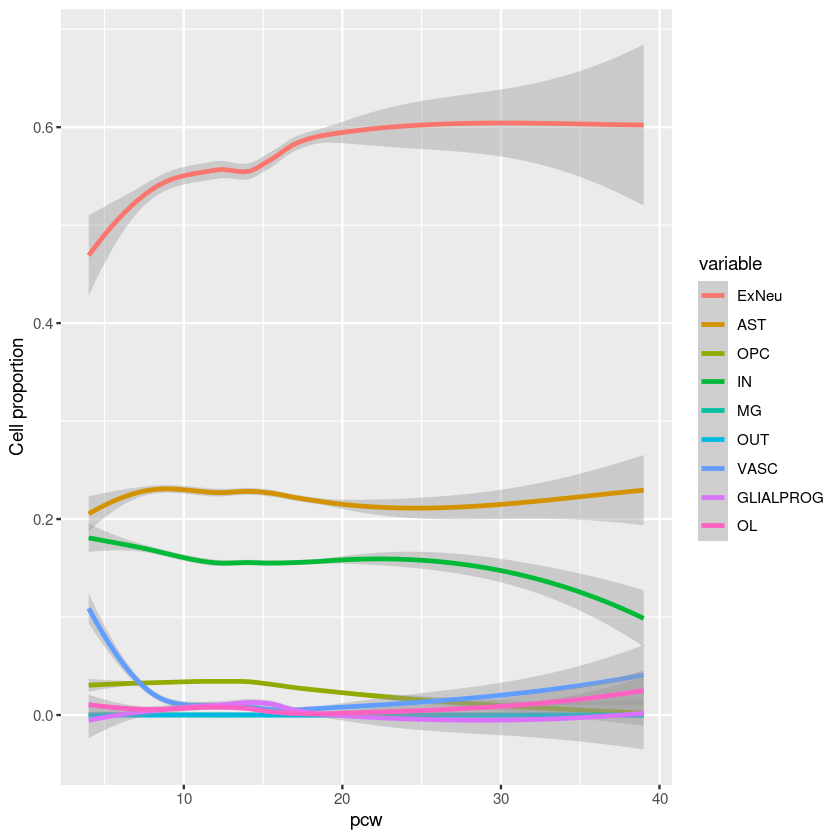

In [29]:
ggplot(prop, aes(x = pcw, y = value, color = variable))+
    geom_smooth()+
    labs(y='Cell proportion')

**use covariates corrected gene expression, including HCP**

In [5]:
bulk <- fread("../../TWAS/data/all_gene_exp_regressed.txt", data.table = F)
bulk.expr <- bulk[,5:633]
bulk.genes <- bulk %>% select(TargetID)
bulk.genes <- bulk.genes %>% inner_join(annot, by = c("TargetID" = "ensg"))
bulk.genes <- bulk.genes %>% select(TargetID, V12)
bulk.df <- cbind(bulk.genes, bulk.expr)

In [6]:
head(bulk.df)

TargetID        V12         1474     1496     1500     1502     1507     
1 ENSG00000223972 DDX11L1     2.867789 3.296470 2.200791 2.684605 1.4565833
2 ENSG00000243485 MIR1302-2HG 2.060708 1.581782 2.679413 2.830359 1.4140588
3 ENSG00000227232 WASH7P      8.811202 8.280995 8.931025 8.949145 8.3683365
4 ENSG00000237613 FAM138A     4.895634 4.615218 4.995389 4.928265 4.8845307
5 ENSG00000239945 AL627309.3  1.322099 2.477211 2.435626 2.840091 0.6167818
6 ENSG00000233750 CICP27      4.261517 4.511196 4.226093 4.049178 4.7536951
  1511     1513     1525      ... 1558     1607     1707.1   1835     1851    
1 3.400122 1.017490 0.9603317 ... 2.852729 2.339485 2.943993 3.169074 2.995443
2 3.376425 1.656341 2.0834450 ... 1.237803 1.312254 2.414263 1.898056 2.520261
3 9.113657 8.919081 8.5016701 ... 7.633874 8.261629 8.822906 7.728855 8.552273
4 4.361184 4.768870 5.3094919 ... 3.829474 4.982749 4.022271 4.088187 4.231415
5 1.252557 1.184240 1.4249191 ... 1.522859 2.418559 1.408638 2.505883 4.130191
6 4.284809 4.366938 3.0368784 ... 4.438547 4.543358 4.305752 4.365838 4.230395
  1890     1923     2193     849      898     
1 3.501674 2.804495 1.687725 1.808905 1.666353
2 2.140663 2.337385 2.204175 2.321048 2.050840
3 8.871003 8.440336 9.129610 7.818537 8.283419
4 3.810719 3.647314 5.210864 4.068420 4.540590
5 3.238845 1.706037 1.256406 1.003519 2.954425
6 3.963106 4.015720 4.033887 4.405711 5.244836

In [9]:
dim(bulk)

[1] 31531   633

In [10]:
dup.genes <- bulk.df[which(duplicated(bulk.df$V12)),'V12']
bulk.df <- bulk.df %>% filter(!V12 %in% dup.genes)
dim(bulk.df)

[1] 30800   631

In [11]:
bulk.matrix <- bulk.df %>% select(-1, -V12)

In [12]:
range(colSums(bulk.matrix)) # VST normalized

[1] 199322.9 200516.8

In [13]:
cpm_matrix <- bulk.matrix / colSums(bulk.matrix) * 1e6
range(colSums(cpm_matrix)) 

[1]  997151.5 1003121.5

In [14]:
bulk.cpm <- as.data.frame(cpm_matrix)
rownames(bulk.cpm) <- bulk.df$V12

In [15]:
# use all marker genes
tmp <- intersect(markers$gene, rownames(cpm_df_t))
length(tmp)
tmp <- intersect(tmp,rownames(bulk.cpm))
length(tmp)

[1] 770

[1] 734

In [17]:
sig <- cpm_df_t[match(tmp, rownames(cpm_df_t)),]
mix <- bulk.cpm[match(tmp,rownames(bulk.cpm)),]
rownames(mix) <- rownames(sig)
dim(sig)
dim(mix)

[1] 734   9

[1] 734 629

In [19]:
source('scripts/CIBERSORT.R')
cbprop <- CIBERSORT(sig, mix, perm=0, QN=TRUE, absolute=FALSE, abs_method='sig.score')[,1:ncol(sig)]

ExNeu     AST       OPC        IN        MG OUT VASC GLIALPROG 
1474 0.5850999 0.1442245 0.00000000 0.1938473 0  0   0    0.07682832
1496 0.5705754 0.1887319 0.00667960 0.1764140 0  0   0    0.05759907
1500 0.5973102 0.1538019 0.00000000 0.1926292 0  0   0    0.05625872
1502 0.5913571 0.1832883 0.00000000 0.1795573 0  0   0    0.04078966
1507 0.5548361 0.1932990 0.00000000 0.2095365 0  0   0    0.02156301
1511 0.6026980 0.1527862 0.02235362 0.1893777 0  0   0    0.01594387
     OL          sampleID
1474 0.000000000 1474    
1496 0.000000000 1496    
1500 0.000000000 1500    
1502 0.005007632 1502    
1507 0.020765372 1507    
1511 0.016840616 1511

sampleID Age        Sex inferSex trimester ancestry study  pcw variable
1 1474     -0.4986301 M   M        2         amr      walker 14  ExNeu   
2 1496     -0.4602740 F   F        2         amr      walker 16  ExNeu   
3 1500     -0.4794521 M   M        2         eur      walker 15  ExNeu   
4 1502     -0.4410959 M   M        2         amr      walker 17  ExNeu   
5 1507     -0.4602740 M   M        2         amr      walker 16  ExNeu   
6 1511     -0.4986301 NA  M        2         amr      walker 14  ExNeu   
  value    
1 0.5850999
2 0.5705754
3 0.5973102
4 0.5913571
5 0.5548361
6 0.6026980

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


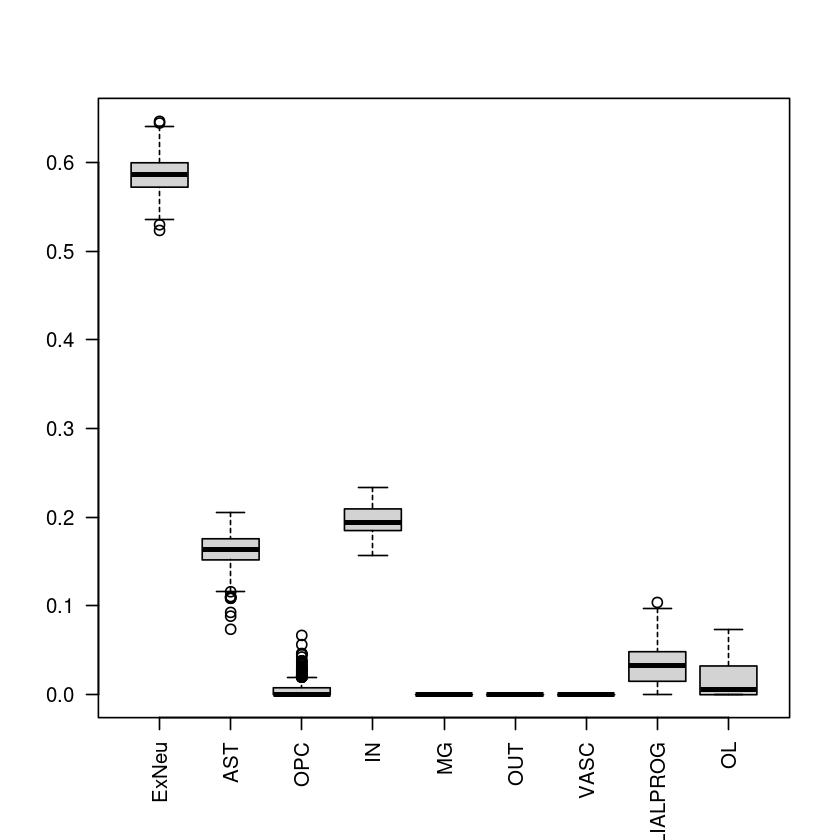

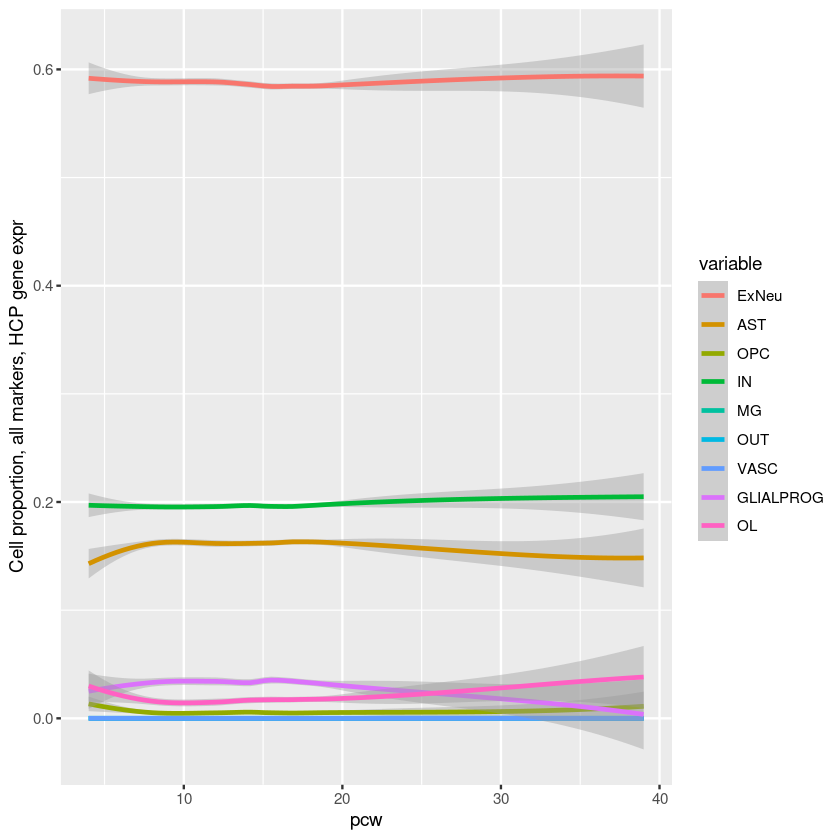

In [20]:
boxplot(cbprop,las=2)
bulk.meta <- read.table("../metadata_654.tsv", header = T)
cbprop.1 <- as.data.frame(cbprop)
cbprop.1$sampleID <- rownames(cbprop.1)
head(cbprop.1)
cbprop.1 <- cbprop.1 %>% inner_join(bulk.meta, by = c("sampleID" = "Subject"))
prop <- melt(cbprop.1, id=c('sampleID',colnames(bulk.meta)[2:8]))
head(prop)


ggplot(prop, aes(x = pcw, y = value, color = variable))+
    geom_smooth()+
    labs(y='Cell proportion, all markers, HCP gene expr')

[1] 609

[1] 581

[1] 581   9

[1] 581 629

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


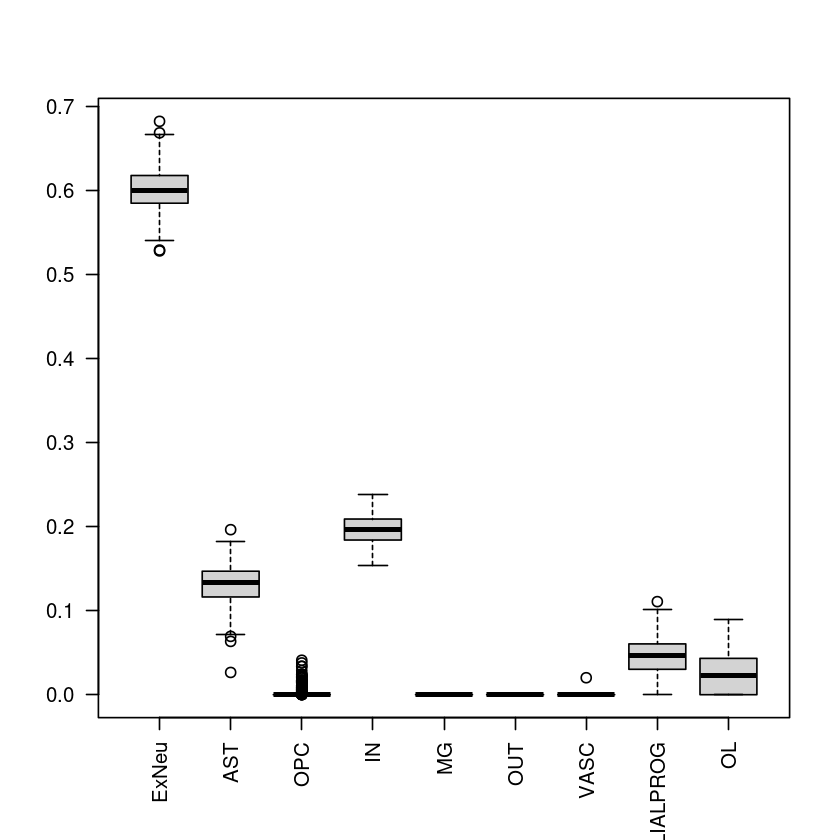

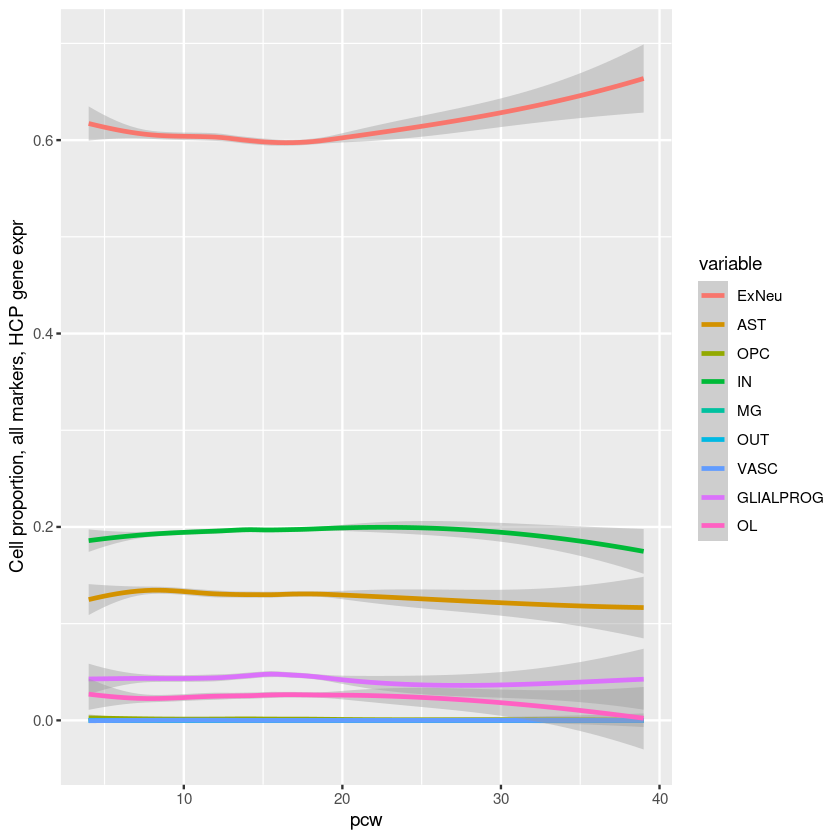

In [22]:
tmp <- intersect(markers_top100$gene, rownames(cpm_df_t))
length(tmp)
tmp <- intersect(tmp,rownames(bulk.cpm))
length(tmp)

sig <- cpm_df_t[match(tmp, rownames(cpm_df_t)),]
mix <- bulk.cpm[match(tmp,rownames(bulk.cpm)),]
rownames(mix) <- rownames(sig)
dim(sig)
dim(mix)

source('scripts/CIBERSORT.R')
cbprop <- CIBERSORT(sig, mix, perm=0, QN=TRUE, absolute=FALSE, abs_method='sig.score')[,1:ncol(sig)]


boxplot(cbprop,las=2)
# bulk.meta <- read.table("../metadata_654.tsv", header = T)
cbprop.1 <- as.data.frame(cbprop)
cbprop.1$sampleID <- rownames(cbprop.1)
# head(cbprop.1)
cbprop.1 <- cbprop.1 %>% inner_join(bulk.meta, by = c("sampleID" = "Subject"))
prop <- melt(cbprop.1, id=c('sampleID',colnames(bulk.meta)[2:8]))
# head(prop)


ggplot(prop, aes(x = pcw, y = value, color = variable))+
    geom_smooth()+
    labs(y='Cell proportion, all markers, HCP gene expr')

### Li

In [2]:
load("~/project-gandalm/isoform_twas/eqtl_new/Sestan.fetalHuman.Psychencode.Rdata")

In [4]:
ls()

[1] "count2" "cpm2"   "meta2"

In [5]:
dim(cpm2)
dim(count2)
dim(meta2)

[1] 60155   762

[1] 60155   762

[1] 762   7

In [5]:
count2[1:3,1:3]

C1-29-B8_CAGAGAGG-CTCTCTAT_L003_R1_all
ENSG00000000003|TSPAN6 319                                   
ENSG00000000005|TNMD     0                                   
ENSG00000000419|DPM1    60                                   
                       C1-29-E7_CTCTCTAC-GTAAGGAG_L003_R1_all
ENSG00000000003|TSPAN6 301                                   
ENSG00000000005|TNMD     0                                   
ENSG00000000419|DPM1     0                                   
                       C1-20-A1_TAAGGCGA-TAGATCGC_L001_R1_all
ENSG00000000003|TSPAN6 0                                     
ENSG00000000005|TNMD   0                                     
ENSG00000000419|DPM1   1

In [3]:
geneid <- unlist(lapply(rownames(count2),function(x){strsplit(x,"[|]")[[1]][1]}))
genesymbol <- unlist(lapply(rownames(count2),function(x){strsplit(x,"[|]")[[1]][2]}))

count2 <- count2[!duplicated(genesymbol),]
genesymbol <- genesymbol[!duplicated(genesymbol)]
geneid <- geneid[!duplicated(genesymbol)]
rownames(count2) <- genesymbol

In [7]:
dim(count2)

[1] 57996   762

In [7]:
head(meta2)

Chip      Donor  Region Age   Sex
C1-29-B8_CAGAGAGG-CTCTCTAT_L003_R1_all  C1-29-B8  HSB313 NCX    16PCW M  
C1-29-E7_CTCTCTAC-GTAAGGAG_L003_R1_all  C1-29-E7  HSB313 NCX    16PCW M  
C1-20-A1_TAAGGCGA-TAGATCGC_L001_R1_all  C1-20-A1  HSB303 DFC    19PCW F  
C1-20-B2_CGTACTAG-CTCTCTAT_L001_R1_all  C1-20-B2  HSB303 DFC    19PCW F  
C1-20-E11_AAGAGGCA-GTAAGGAG_L001_R1_all C1-20-E11 HSB303 DFC    19PCW F  
C1-20-E4_TCCTGAGC-GTAAGGAG_L001_R1_all  C1-20-E4  HSB303 DFC    19PCW F  
                                        cellNumber ctype
C1-29-B8_CAGAGAGG-CTCTCTAT_L003_R1_all  1          Astro
C1-29-E7_CTCTCTAC-GTAAGGAG_L003_R1_all  1          Astro
C1-20-A1_TAAGGCGA-TAGATCGC_L001_R1_all  1          Astro
C1-20-B2_CGTACTAG-CTCTCTAT_L001_R1_all  1          Astro
C1-20-E11_AAGAGGCA-GTAAGGAG_L001_R1_all 1          Astro
C1-20-E4_TCCTGAGC-GTAAGGAG_L001_R1_all  1          Astro

In [31]:
table(meta2$ctype)


    Astro      Endo      ExN1      ExN2      ExN3      InN1      InN2      IPC1 
       49        29        81        10        18        18        21       143 
     IPC2 Microglia     NasN1     NasN2     NasN3     NasN4     NasN5     NasN6 
       27        11        85        23        23        14        11        15 
  NEPRGC1   NEPRGC2   NEPRGC3   NEPRGC4     Oligo      OPC1      OPC2  Pericyte 
       57        31        16        20        10        13        20        17 

NEP/RGC: Neural epithelial progenitor/radial glial cells, NasN: Nascent neurons, IPC: intermediate progenitor cells, OPC: oligodendrocyte progenitor cells, Oligo: oligodendrocytes, ExN: excitatory neurons, InN: interneurons, Astro: astroglial lineage

In [4]:
meta2$super_cluster <- NA
meta2[meta2$ctype == "Astro", 'super_cluster'] <- "Astro"
meta2[meta2$ctype == "Endo", 'super_cluster'] <- "Endo"
meta2[meta2$ctype == "Microglia", 'super_cluster'] <- "Microglia"
meta2[meta2$ctype == "Oligo", 'super_cluster'] <- "Oligo"
meta2[meta2$ctype == "Pericyte", 'super_cluster'] <- "Pericyte"

meta2[meta2$ctype %in% c("ExN1", "ExN2", "ExN3"), 'super_cluster'] <- "ExN"
meta2[meta2$ctype %in% c("InN1", "InN2"), 'super_cluster'] <- "InN"
meta2[meta2$ctype %in% c("NasN1", "NasN2", "NasN3", "NasN4", "NasN5", "NasN6"), 'super_cluster'] <- "NasN"
meta2[meta2$ctype %in% c("NEPRGC1", "NEPRGC2", "NEPRGC3", "NEPRGC4"), 'super_cluster'] <- "NEPRGC"
meta2[meta2$ctype %in% c("OPC1", "OPC2"), 'super_cluster'] <- "OPC"

In [5]:
meta2$cluster2 <- NA
meta2[meta2$ctype == "Astro", 'cluster2'] <- "Astro"
meta2[meta2$ctype == "Endo", 'cluster2'] <- "Endo"
meta2[meta2$ctype == "Microglia", 'cluster2'] <- "Microglia"
meta2[meta2$ctype == "Oligo", 'cluster2'] <- "Oligo"
meta2[meta2$ctype == "Pericyte", 'cluster2'] <- "Pericyte"
meta2[meta2$ctype %in% c("InN1", "InN2"), 'cluster2'] <- "InN"
meta2[meta2$ctype %in% c("OPC1", "OPC2"), 'cluster2'] <- "OPC"

meta2[meta2$ctype %in% c("ExN1", "ExN2", "ExN3", "NasN1", "NasN2", "NasN3", "NasN4", "NasN5", "NasN6"), 'cluster2'] <- "ExN"
meta2[meta2$ctype %in% c("IPC1", "IPC2", "NEPRGC1", "NEPRGC2", "NEPRGC3", "NEPRGC4"), 'cluster2'] <- "NPC"

**prepare reference file for CIBERSORTx**

In [6]:
sum(colnames(count2) == rownames(meta2))

[1] 762

In [7]:
df <- as.data.frame(t(as.data.frame(meta2$cluster2)))
rownames(df) <- "gene"
# head(df)
colnames(df) <- colnames(count2)
ref_mat <- rbind(df, count2)
head(ref_mat)

C1-29-B8_CAGAGAGG-CTCTCTAT_L003_R1_all
gene     Astro                                 
TSPAN6   319                                   
TNMD     0                                     
DPM1     60                                    
SCYL3    0                                     
C1ORF112 0                                     
         C1-29-E7_CTCTCTAC-GTAAGGAG_L003_R1_all
gene     Astro                                 
TSPAN6   301                                   
TNMD     0                                     
DPM1     0                                     
SCYL3    2                                     
C1ORF112 0                                     
         C1-20-A1_TAAGGCGA-TAGATCGC_L001_R1_all
gene     Astro                                 
TSPAN6   0                                     
TNMD     0                                     
DPM1     1                                     
SCYL3    1                                     
C1ORF112 0                                     
         C1-20-B2_CGTACTAG-CTCTCTAT_L001_R1_all
gene     Astro                                 
TSPAN6   67                                    
TNMD     0                                     
DPM1     14                                    
SCYL3    0                                     
C1ORF112 0                                     
         C1-20-E11_AAGAGGCA-GTAAGGAG_L001_R1_all
gene     Astro                                  
TSPAN6   15                                     
TNMD     0                                      
DPM1     0                                      
SCYL3    0                                      
C1ORF112 0                                      
         C1-20-E4_TCCTGAGC-GTAAGGAG_L001_R1_all
gene     Astro                                 
TSPAN6   0                                     
TNMD     0                                     
DPM1     0                                     
SCYL3    0                                     
C1ORF112 0                                     
         C1-20-F3_AGGCAGAA-ACTGCATA_L001_R1_all
gene     Astro                                 
TSPAN6   123                                   
TNMD     0                                     
DPM1     73                                    
SCYL3    33                                    
C1ORF112 0                                     
         C1-20-F8_CAGAGAGG-ACTGCATA_L001_R1_all
gene     Astro                                 
TSPAN6   0                                     
TNMD     0                                     
DPM1     0                                     
SCYL3    0                                     
C1ORF112 0                                     
         C1-20-G3_AGGCAGAA-AAGGAGTA_L001_R1_all
gene     Astro                                 
TSPAN6   323                                   
TNMD     0                                     
DPM1     41                                    
SCYL3    0                                     
C1ORF112 0                                     
         C1-21-A10_CGAGGCTG-TAGATCGC_L002_R1_all ...
gene     Astro                                   ...
TSPAN6   6                                       ...
TNMD     0                                       ...
DPM1     0                                       ...
SCYL3    0                                       ...
C1ORF112 0                                       ...
         C1-22-D6_TAGGCATG-AGAGTAGA_L003_R1_all
gene     Pericyte                              
TSPAN6   51                                    
TNMD     0                                     
DPM1     1                                     
SCYL3    0                                     
C1ORF112 0                                     
         C1-22-D8_CAGAGAGG-AGAGTAGA_L003_R1_all
gene     Pericyte                              
TSPAN6   40                                    
TNMD     0                                     
DPM1     9                                     
SCYL3    0                     

In [8]:
write.table(ref_mat, "../Sestan.fetalHuman.Psychencode.ref.mat.cibersortx.cluster2.tsv", col.names=F,row.names=T, sep = "\t", quote=F)

In [15]:
df <- as.data.frame(t(as.data.frame(meta2$super_cluster)))
rownames(df) <- "gene"
head(df)

V1    V2    V3    V4    V5    V6    V7    V8    V9    V10   ... V753    
gene Astro Astro Astro Astro Astro Astro Astro Astro Astro Astro ... Pericyte
     V754     V755     V756     V757     V758     V759     V760     V761    
gene Pericyte Pericyte Pericyte Pericyte Pericyte Pericyte Pericyte Pericyte
     V762    
gene Pericyte

In [17]:
colnames(df) <- colnames(count2)
ref_mat <- rbind(df, count2)
head(ref_mat)

C1-29-B8_CAGAGAGG-CTCTCTAT_L003_R1_all
gene     Astro                                 
TSPAN6   319                                   
TNMD     0                                     
DPM1     60                                    
SCYL3    0                                     
C1ORF112 0                                     
         C1-29-E7_CTCTCTAC-GTAAGGAG_L003_R1_all
gene     Astro                                 
TSPAN6   301                                   
TNMD     0                                     
DPM1     0                                     
SCYL3    2                                     
C1ORF112 0                                     
         C1-20-A1_TAAGGCGA-TAGATCGC_L001_R1_all
gene     Astro                                 
TSPAN6   0                                     
TNMD     0                                     
DPM1     1                                     
SCYL3    1                                     
C1ORF112 0                                     
         C1-20-B2_CGTACTAG-CTCTCTAT_L001_R1_all
gene     Astro                                 
TSPAN6   67                                    
TNMD     0                                     
DPM1     14                                    
SCYL3    0                                     
C1ORF112 0                                     
         C1-20-E11_AAGAGGCA-GTAAGGAG_L001_R1_all
gene     Astro                                  
TSPAN6   15                                     
TNMD     0                                      
DPM1     0                                      
SCYL3    0                                      
C1ORF112 0                                      
         C1-20-E4_TCCTGAGC-GTAAGGAG_L001_R1_all
gene     Astro                                 
TSPAN6   0                                     
TNMD     0                                     
DPM1     0                                     
SCYL3    0                                     
C1ORF112 0                                     
         C1-20-F3_AGGCAGAA-ACTGCATA_L001_R1_all
gene     Astro                                 
TSPAN6   123                                   
TNMD     0                                     
DPM1     73                                    
SCYL3    33                                    
C1ORF112 0                                     
         C1-20-F8_CAGAGAGG-ACTGCATA_L001_R1_all
gene     Astro                                 
TSPAN6   0                                     
TNMD     0                                     
DPM1     0                                     
SCYL3    0                                     
C1ORF112 0                                     
         C1-20-G3_AGGCAGAA-AAGGAGTA_L001_R1_all
gene     Astro                                 
TSPAN6   323                                   
TNMD     0                                     
DPM1     41                                    
SCYL3    0                                     
C1ORF112 0                                     
         C1-21-A10_CGAGGCTG-TAGATCGC_L002_R1_all ...
gene     Astro                                   ...
TSPAN6   6                                       ...
TNMD     0                                       ...
DPM1     0                                       ...
SCYL3    0                                       ...
C1ORF112 0                                       ...
         C1-22-D6_TAGGCATG-AGAGTAGA_L003_R1_all
gene     Pericyte                              
TSPAN6   51                                    
TNMD     0                                     
DPM1     1                                     
SCYL3    0                                     
C1ORF112 0                                     
         C1-22-D8_CAGAGAGG-AGAGTAGA_L003_R1_all
gene     Pericyte                              
TSPAN6   40                                    
TNMD     0                                     
DPM1     9                                     
SCYL3    0                     

In [18]:
write.table(ref_mat, "../Sestan.fetalHuman.Psychencode.ref.mat.cibersortx.tsv", col.names=F,row.names=T, sep = "\t", quote=F)

**cibersort R script**

In [9]:
seurat_obj <- CreateSeuratObject(counts = count2, 
                                 project = "fetal", 
                                 meta = meta2,
                                 min.cells = 3, 
                                 min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


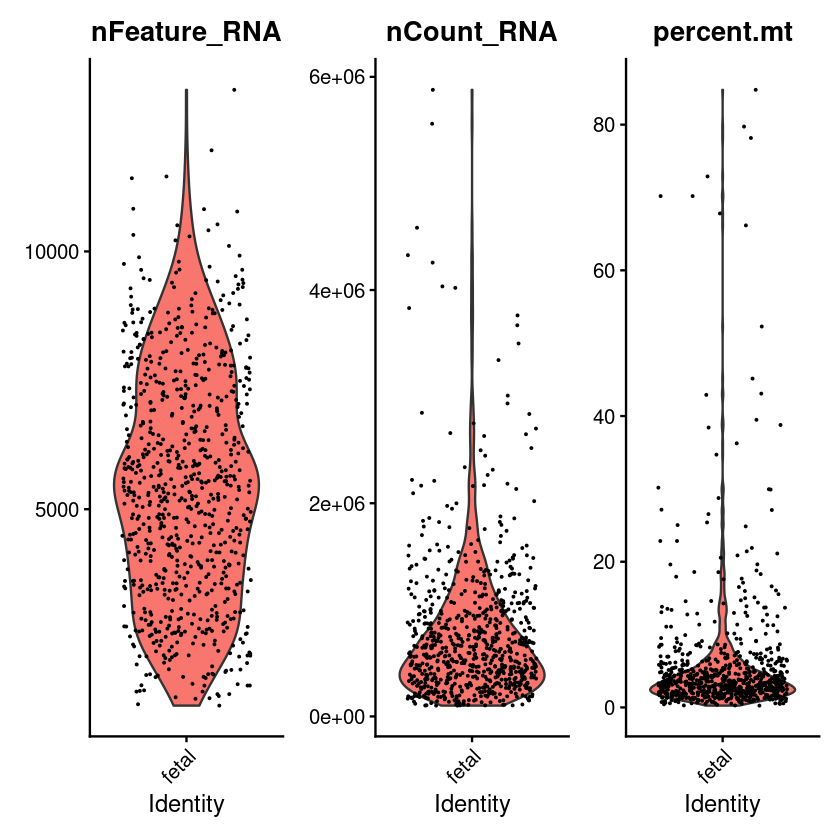

In [10]:
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")
VlnPlot(seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [11]:
seurat_obj

An object of class Seurat 
32520 features across 762 samples within 1 assay 
Active assay: RNA (32520 features, 0 variable features)

In [12]:
seurat_obj <- subset(seurat_obj, 
                     subset = nFeature_RNA > 200 & nFeature_RNA < 10000 & percent.mt < 10)

In [13]:
seurat_obj

An object of class Seurat 
32520 features across 665 samples within 1 assay 
Active assay: RNA (32520 features, 0 variable features)

In [129]:
# cell_gene_matrix <- seurat_obj@assays$RNA@counts
# cells_with_expression <- rowSums(cell_gene_matrix > 0)
# head(cells_with_expression)
# range(cells_with_expression)
# sum(cells_with_expression > 665*0.5)

In [130]:
# genes_expressed_50_percent <- names(which(cells_with_expression > 665*0.5))

In [131]:
# seurat_obj <- subset(seurat_obj, features = genes_expressed_50_percent)
# seurat_obj

Centering and scaling data matrix

PC_ 1 
Positive:  FLT1, HLA-E, GPR116, A2M, CD34, PECAM1, ITM2A, CDH5, ARHGAP29, EPAS1 
	   ELTD1, MYCT1, ABCG2, APOLD1, KDR, RASGRP3, ESAM, IFITM2, SRGN, ICAM2 
	   ABCB1, IFITM3, SLCO2B1, B2M, RNASE1, CGNL1, ANXA1, GNG11, IGFBP7, C1ORF54 
Negative:  SOX11, DCX, SOX4, CENPF, SETBP1, TOP2A, BCL11B, TFAP2C, SYT14, CXADR 
	   DICER1, GRIA1, FGFR2, TRIM36-IT1, TIMELESS, KNSTRN, KPNA2, RHOBTB3, CNR1, DTL 
	   NRCAM, TGFBR1, AFF2, ZNF84, FH, NUP93, MTMR4, AKAP6, PPAT, CCNA2 
PC_ 2 
Positive:  FN1, ESAM, GNG11, PECAM1, ITGA1, KDR, MYCT1, ITM2A, CGNL1, CDH5 
	   ELTD1, C1ORF54, EPAS1, WWTR1, AFAP1L1, APOLD1, ARHGAP29, GPR116, COL4A1, ABCB1 
	   IGFBP7, LAMB1, ICAM2, CD34, IFITM1, EMCN, ETS1, ABLIM1, SOX4, LAMC1 
Negative:  CCL4, SPP1, CCL3, CCL3L3, VSIG4, AIF1, FOLR2, FGD2, FCGR2A, IL1B 
	   CCL4L1, C3, LAPTM5, CYBB, OLR1, P2RY12, CD53, CX3CR1, C1QB, FPR1 
	   RGS1, FCGR1A, ADAM28, LY86, CD83, NLRP3, TYROBP, P2RY13, C1QC, ITGAX 
PC_ 3 
Positive:  SLCO2A1, CD

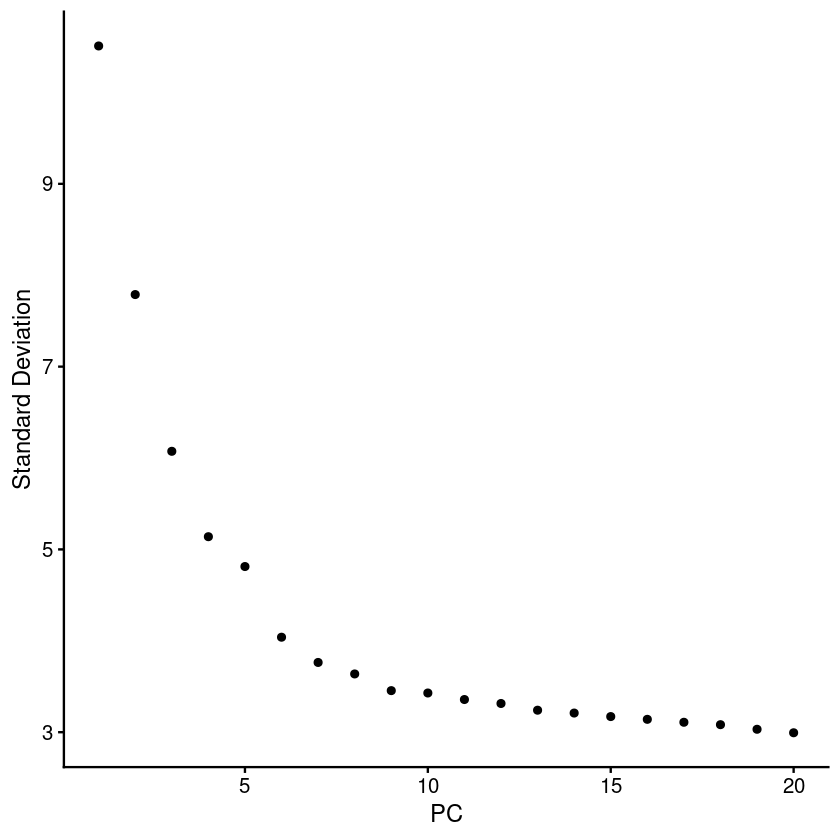

In [14]:
seurat_obj <- NormalizeData(seurat_obj)
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
ElbowPlot(seurat_obj)

In [15]:
seurat_obj <- RunUMAP(seurat_obj, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:16:59 UMAP embedding parameters a = 0.9922 b = 1.112

16:16:59 Read 665 rows and found 10 numeric columns

16:16:59 Using Annoy for neighbor search, n_neighbors = 30

16:16:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:16:59 Writing NN index file to temp file /tmp/Rtmpe4bS50/file2f1554845125e

16:16:59 Searching Annoy index using 1 thread, search_k = 3000

16:16:59 Annoy recall = 100%

16:17:00 Commencing smooth kNN distance calibration using 1 thread

16:17:00 Initializing fro

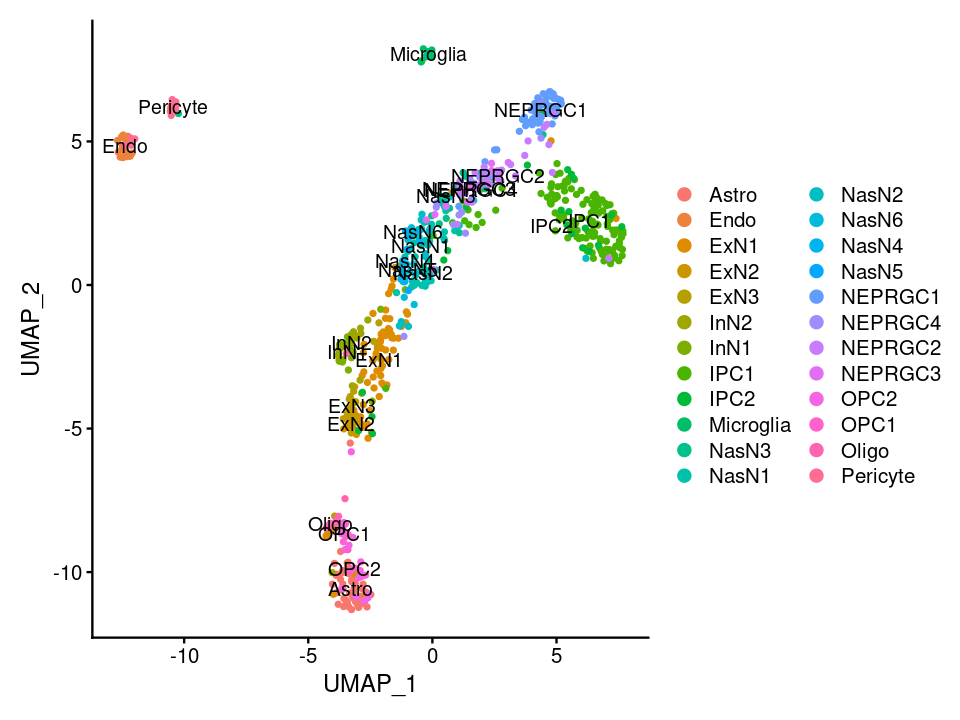

In [16]:
options(repr.plot.height = 6, repr.plot.width = 8)

Idents(seurat_obj) <- seurat_obj@meta.data$ctype
DimPlot(seurat_obj, reduction = "umap",label=T)

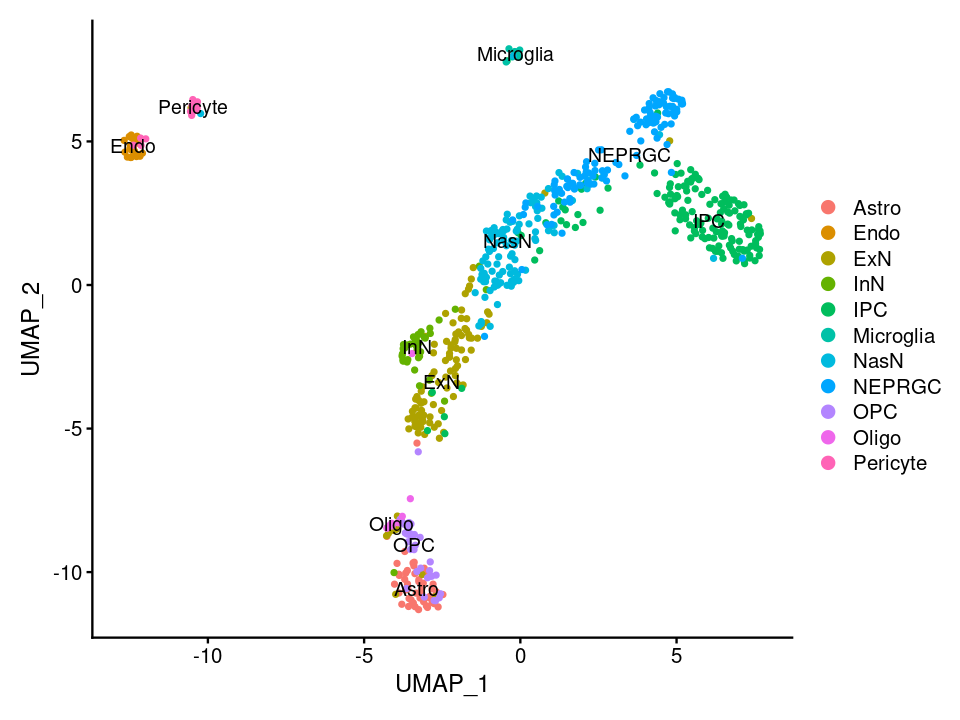

In [17]:
# options(repr.plot.height = 6, repr.plot.width = 8)
Idents(seurat_obj) <- seurat_obj@meta.data$super_cluster
DimPlot(seurat_obj, reduction = "umap",label=T)

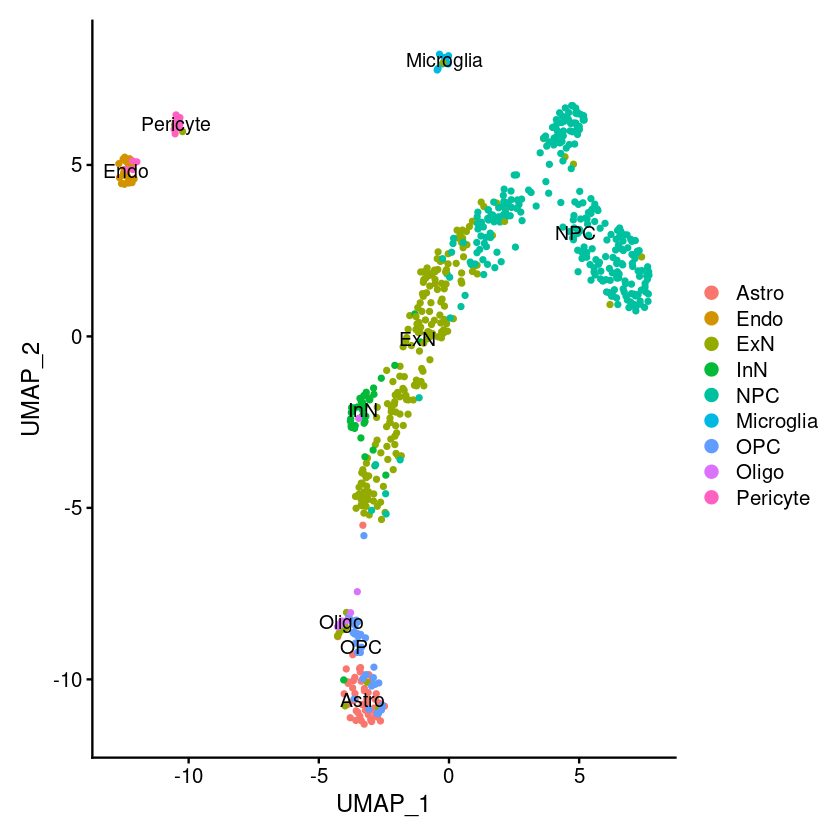

In [16]:
Idents(seurat_obj) <- seurat_obj@meta.data$cluster2
DimPlot(seurat_obj, reduction = "umap",label=T)

In [18]:
markers <- FindAllMarkers(seurat_obj, 
                          only.pos = TRUE,
                          logfc.threshold = 0.25,
                          min.pct = 0.5)

Calculating cluster Astro

Calculating cluster Endo

Calculating cluster ExN

Calculating cluster InN

Calculating cluster IPC

Calculating cluster Microglia

Calculating cluster NasN

Calculating cluster NEPRGC

Calculating cluster OPC

Calculating cluster Oligo

Calculating cluster Pericyte



**ref matrix median or mean?**

In [19]:
cpm_matrix <- RelativeCounts(seurat_obj@assays$RNA@counts) * 1e6
range(colSums(cpm_matrix))
dim(cpm_matrix)

[1] 1e+06 1e+06

[1] 32520   665

In [20]:
lineage_categories <- unique(seurat_obj@meta.data$super_cluster)
cpm_values <- matrix(NA, nrow = length(lineage_categories), ncol = nrow(seurat_obj@assays$RNA@counts))
# reference matrix: for each gene, get the mean of cpm values across all cells for each cluster
for (i in 1:length(lineage_categories)) {
  lineage <- lineage_categories[i]
  lineage_indices <- which(seurat_obj@meta.data$super_cluster == lineage)
  cpm_subset <- cpm_matrix[, lineage_indices]
  cpm_values[i, ] <- rowMeans(cpm_subset)
}
range(rowSums(cpm_values))

[1] 1e+06 1e+06

In [28]:
cpm_df <- as.data.frame(cpm_values)
rownames(cpm_df) <- lineage_categories
colnames(cpm_df) <- rownames(seurat_obj@assays$RNA@counts)

ref <- as.data.frame(t(cpm_df))

In [17]:
# reference
# ref <- cpm(t(apply(seurat_obj@assays$RNA@counts,1,function(x){tapply(x,seurat_obj@meta.data$super_cluster,median)})),log=F)

In [22]:
head(markers)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster
LINC00943     8.448951e-52 1.1345172  0.714 0.050 2.747599e-47 Astro  
NPNT          7.937376e-48 1.5207686  0.776 0.076 2.581235e-43 Astro  
GFAP          9.069980e-48 1.8083889  0.898 0.131 2.949557e-43 Astro  
HOPX          9.089598e-44 2.5575191  0.980 0.205 2.955937e-39 Astro  
RP11-561I11.3 4.681937e-43 0.5648611  0.531 0.029 1.522566e-38 Astro  
GPR37L1       9.973802e-43 0.4549175  0.633 0.049 3.243480e-38 Astro  
              gene         
LINC00943     LINC00943    
NPNT          NPNT         
GFAP          GFAP         
HOPX          HOPX         
RP11-561I11.3 RP11-561I11.3
GPR37L1       GPR37L1

In [30]:
range(colSums(ref))

[1] 1e+06 1e+06

In [29]:
head(ref)

Astro        Endo       ExN          InN          IPC       
TSPAN6   172.37707977 294.795166 47.492309140  4.885048415 136.672072
DPM1      47.98027220  41.851088 28.660868331 33.011497955  40.014844
SCYL3      9.30752618  58.167623 11.830401313 41.039502430  24.160399
C1ORF112  11.96081647   2.037660  8.009723637  2.136831951  34.649922
FGR        0.00000000   3.983675  0.000000000  0.004611468   0.000000
CFH        0.03200994 185.592716  0.005870613  0.993614616   2.899735
         Microglia   NasN       NEPRGC     OPC       Oligo      Pericyte   
TSPAN6    0.41678802 196.959529 377.855039 199.90338 46.6078437 242.7811802
DPM1     88.83934351  55.451313  46.946644  45.88828 22.0725057  85.1834778
SCYL3    15.34712030  35.201780  41.870378  18.99891 12.6439743  14.3766209
C1ORF112 84.50132246   4.916235  70.934889  60.77176  2.1316810   1.3870344
FGR       0.00000000   0.000000   2.161817   0.00000  0.1578654   0.5132313
CFH       0.04005111   0.000000   0.000000   0.00000  0.1776401 219.4253617

In [68]:
dim(ref)
dim(markers)

[1] 32520    11

[1] 7741    7

In [32]:
table(markers$cluster)


    Astro      Endo       ExN       InN       IPC Microglia      NasN    NEPRGC 
      832       953       832       192      1072       507       712      1210 
      OPC     Oligo  Pericyte 
      676       295       460 

**batch-corrected counts**

In [44]:
bulk <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/genes.combatseq.tsv", data.table = F)

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/genes.combatseq.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [45]:
bulk <- bulk %>% inner_join(annot, by = c("V1" = "ensg"))

In [38]:
# bulk <- bulk %>% filter(V11 == "protein_coding")

In [46]:
bulk <- bulk %>% select(1:643, V12)
dim(bulk)

[1] 31947   644

In [47]:
length(unique(bulk$V12))
length(unique(bulk$V1))

[1] 31404

[1] 31947

In [43]:
# bulk[which(duplicated(bulk$V12)),'V12']

In [48]:
dup.genes <- bulk[which(duplicated(bulk$V12)),'V12']
length(dup.genes)

# sum(dup.genes %in% markers$gene)

[1] 543

In [49]:
bulk <- bulk %>% filter(!V12 %in% dup.genes)
dim(bulk)
length(unique(bulk$V12))
length(unique(bulk$V1))

[1] 31208   644

[1] 31208

[1] 31208

In [18]:
head(bulk)

V1              1474 1496 1500 1502 1507 1511 1513 1525 1531 ... 1607 1707.1
1 ENSG00000000419 1025 594  671  451  287  558  659  508  178  ... 1018 611   
2 ENSG00000000457  737 668  624  660  437  404  611  508  121  ...  650 530   
3 ENSG00000000460 1128 368  689  496  352  509  558  277   96  ...  644 303   
4 ENSG00000000938    6  27   13   13   13    7    6   20    3  ...  149  16   
5 ENSG00000000971  116 493  328  103  143   40  225   76   14  ... 1609 537   
6 ENSG00000001036  431 389  361  217  229  262  217  284   87  ...  580 414   
  1835 1851 1890 1923 2193 849 898  V12     
1 4321 931  1491 7795 574  608  598 DPM1    
2 2955 547  1284 7104 548  760  670 SCYL3   
3 2519 428  1119 4053 351  375  366 C1orf112
4   59  35    56  314  17   28   60 FGR     
5  296 647  2402 4183 566  233 1014 CFH     
6 1669 488   986 3921 427  436  656 FUCA2

In [22]:
bulk.matrix <- bulk %>% select(-V1, -V12)

In [25]:
bulk <- bulk %>% select(V12, 2:643)
head(bulk)

V12      1474 1496 1500 1502 1507 1511 1513 1525 1531 ... 1558 1607 1707.1
1 DPM1     1025 594  671  451  287  558  659  508  178  ... 3138 1018 611   
2 SCYL3     737 668  624  660  437  404  611  508  121  ... 2954  650 530   
3 C1orf112 1128 368  689  496  352  509  558  277   96  ... 1771  644 303   
4 FGR         6  27   13   13   13    7    6   20    3  ...   80  149  16   
5 CFH       116 493  328  103  143   40  225   76   14  ...  295 1609 537   
6 FUCA2     431 389  361  217  229  262  217  284   87  ... 1367  580 414   
  1835 1851 1890 1923 2193 849 898 
1 4321 931  1491 7795 574  608  598
2 2955 547  1284 7104 548  760  670
3 2519 428  1119 4053 351  375  366
4   59  35    56  314  17   28   60
5  296 647  2402 4183 566  233 1014
6 1669 488   986 3921 427  436  656

In [26]:
colnames(bulk)[1] <- "Gene"

In [27]:
write.table(bulk, "../bulk.combatseq.cibersortx.tsv", col.names=T,row.names=F,quote=F,sep="\t")

In [23]:
# ref matrix is in CPM
# convert mixture to CPM also
# Convert the count matrix to a DGEList object
dge <- DGEList(counts = bulk.matrix)

# Calculate library sizes (total counts per sample)
dge$samples$lib.size <- colSums(dge$counts)

# Calculate CPM
cpm_matrix <- cpm(dge)

In [24]:
head(cpm_matrix)

1474       1496     1500      1502       1507       1511       1513      
1 36.5598167 24.48248 31.505668 19.7282848 20.5753082 38.0620475 31.2923245
2 26.2873999 27.53249 29.298863 28.8706607 31.3289536 27.5574681 29.0130657
3 40.2336324 15.16760 32.350828 21.6967390 25.2352212 34.7196813 26.4963841
4  0.2140087  1.11284  0.610393  0.5686645  0.9319826  0.4774809  0.2849074
5  4.1375012 20.31964 15.400684  4.5055728 10.2518086  2.7284622 10.6840258
6 15.3729571 16.03314 16.950143  9.4923233 16.4172320 17.8714273 10.3041494
  1525      1531      1533       ... 1558       1607      1707.1     1835     
1 28.240413 26.822287 25.9061503 ... 24.4954181 35.844974 23.4811735 36.844216
2 28.240413 18.233128 28.2318894 ... 23.0591030 22.887263 20.3682847 25.196635
3 15.398808 14.465953 25.7123387 ... 13.8245333 22.675996 11.6445099 21.478959
4  1.111827  0.452061  0.4522271 ...  0.6244848  5.246465  0.6148916  0.503080
5  4.224944  2.109618  8.3338987 ...  2.3027879 56.654778 20.6372998  2.523927
6 15.787947 13.109769 15.2465124 ... 10.6708848 20.422481 15.9103205 14.231196
  1851      1890       1923       2193       849        898     
1 30.107306 18.4900735 21.7899939 20.2221971 19.7312756 19.38587
2 17.689255 15.9230412 19.8583857 19.3062091 24.6640945 21.71995
3 13.840953 13.8768560 11.3296787 12.3658383 12.1697835 11.86493
4  1.131854  0.6944629  0.8777496  0.5989152  0.9086772  1.94507
5 20.923123 29.7874960 11.6930782 19.9403546  7.5614921 32.87169
6 15.781273 12.2275067 10.9606884 15.0433417 14.1494016 21.26610

In [27]:
bulk.cpm <- as.data.frame(cpm_matrix)
bulk.cpm$Gene <- bulk$V12
head(bulk.cpm)

1474       1496     1500      1502       1507       1511       1513      
1 36.5598167 24.48248 31.505668 19.7282848 20.5753082 38.0620475 31.2923245
2 26.2873999 27.53249 29.298863 28.8706607 31.3289536 27.5574681 29.0130657
3 40.2336324 15.16760 32.350828 21.6967390 25.2352212 34.7196813 26.4963841
4  0.2140087  1.11284  0.610393  0.5686645  0.9319826  0.4774809  0.2849074
5  4.1375012 20.31964 15.400684  4.5055728 10.2518086  2.7284622 10.6840258
6 15.3729571 16.03314 16.950143  9.4923233 16.4172320 17.8714273 10.3041494
  1525      1531      1533       ... 1607      1707.1     1835      1851     
1 28.240413 26.822287 25.9061503 ... 35.844974 23.4811735 36.844216 30.107306
2 28.240413 18.233128 28.2318894 ... 22.887263 20.3682847 25.196635 17.689255
3 15.398808 14.465953 25.7123387 ... 22.675996 11.6445099 21.478959 13.840953
4  1.111827  0.452061  0.4522271 ...  5.246465  0.6148916  0.503080  1.131854
5  4.224944  2.109618  8.3338987 ... 56.654778 20.6372998  2.523927 20.923123
6 15.787947 13.109769 15.2465124 ... 20.422481 15.9103205 14.231196 15.781273
  1890       1923       2193       849        898      Gene    
1 18.4900735 21.7899939 20.2221971 19.7312756 19.38587 DPM1    
2 15.9230412 19.8583857 19.3062091 24.6640945 21.71995 SCYL3   
3 13.8768560 11.3296787 12.3658383 12.1697835 11.86493 C1orf112
4  0.6944629  0.8777496  0.5989152  0.9086772  1.94507 FGR     
5 29.7874960 11.6930782 19.9403546  7.5614921 32.87169 CFH     
6 12.2275067 10.9606884 15.0433417 14.1494016 21.26610 FUCA2

In [28]:
bulk.cpm <- bulk.cpm %>% select(643, 1:642)
head(bulk.cpm)
# rownames(bulk.cpm) <- bulk$V12

Gene     1474       1496     1500      1502       1507       1511      
1 DPM1     36.5598167 24.48248 31.505668 19.7282848 20.5753082 38.0620475
2 SCYL3    26.2873999 27.53249 29.298863 28.8706607 31.3289536 27.5574681
3 C1orf112 40.2336324 15.16760 32.350828 21.6967390 25.2352212 34.7196813
4 FGR       0.2140087  1.11284  0.610393  0.5686645  0.9319826  0.4774809
5 CFH       4.1375012 20.31964 15.400684  4.5055728 10.2518086  2.7284622
6 FUCA2    15.3729571 16.03314 16.950143  9.4923233 16.4172320 17.8714273
  1513       1525      1531      ... 1558       1607      1707.1     1835     
1 31.2923245 28.240413 26.822287 ... 24.4954181 35.844974 23.4811735 36.844216
2 29.0130657 28.240413 18.233128 ... 23.0591030 22.887263 20.3682847 25.196635
3 26.4963841 15.398808 14.465953 ... 13.8245333 22.675996 11.6445099 21.478959
4  0.2849074  1.111827  0.452061 ...  0.6244848  5.246465  0.6148916  0.503080
5 10.6840258  4.224944  2.109618 ...  2.3027879 56.654778 20.6372998  2.523927
6 10.3041494 15.787947 13.109769 ... 10.6708848 20.422481 15.9103205 14.231196
  1851      1890       1923       2193       849        898     
1 30.107306 18.4900735 21.7899939 20.2221971 19.7312756 19.38587
2 17.689255 15.9230412 19.8583857 19.3062091 24.6640945 21.71995
3 13.840953 13.8768560 11.3296787 12.3658383 12.1697835 11.86493
4  1.131854  0.6944629  0.8777496  0.5989152  0.9086772  1.94507
5 20.923123 29.7874960 11.6930782 19.9403546  7.5614921 32.87169
6 15.781273 12.2275067 10.9606884 15.0433417 14.1494016 21.26610

In [26]:
range(colSums(cpm_matrix))

[1] 1e+06 1e+06

In [29]:
write.table(bulk.cpm, "~/project-gandalm/isoform_twas/eqtl_new/bulk.combatseq.cibersortx.cpm.tsv", col.names=T,row.names=F,quote=F,sep="\t")

**use all markers**

In [51]:
tmp <- intersect(markers$gene, rownames(ref))
length(tmp)
tmp <- intersect(tmp,rownames(bulk.cpm))
length(tmp)

sig <- ref[match(tmp, rownames(ref)),]
mix <- bulk.cpm[match(tmp,rownames(bulk.cpm)),]
rownames(mix) <- rownames(sig)
dim(sig)
dim(mix)

[1] 5329

[1] 4762

[1] 4762   11

[1] 4762  642

In [52]:
source('scripts/CIBERSORT.R')
cbprop <- CIBERSORT(sig, mix, perm=0, QN=TRUE, absolute=FALSE, abs_method='sig.score')[,1:ncol(sig)]

In [ ]:
boxplot(cbprop,las=2)

In [ ]:
bulk.meta <- read.table("../metadata_654.tsv", header = T)
head(bulk.meta)

In [ ]:
cbprop.1 <- as.data.frame(cbprop)
cbprop.1$sampleID <- rownames(cbprop.1)
head(cbprop.1)

In [ ]:
cbprop.1 <- cbprop.1 %>% inner_join(bulk.meta, by = c("sampleID" = "Subject"))
prop <- melt(cbprop.1, id=c('sampleID',colnames(bulk.meta)[2:8]))
head(prop)

In [ ]:
ggplot(prop, aes(x = pcw, y = value, color = variable))+
    geom_smooth()+
    labs(y='Cell proportion')

**top markers**

In [79]:
head(bulk.cpm)

1474       1496     1500      1502       1507       1511      
DPM1     36.5598167 24.48248 31.505668 19.7282848 20.5753082 38.0620475
SCYL3    26.2873999 27.53249 29.298863 28.8706607 31.3289536 27.5574681
C1orf112 40.2336324 15.16760 32.350828 21.6967390 25.2352212 34.7196813
FGR       0.2140087  1.11284  0.610393  0.5686645  0.9319826  0.4774809
CFH       4.1375012 20.31964 15.400684  4.5055728 10.2518086  2.7284622
FUCA2    15.3729571 16.03314 16.950143  9.4923233 16.4172320 17.8714273
         1513       1525      1531      1533       ... 1558       1607     
DPM1     31.2923245 28.240413 26.822287 25.9061503 ... 24.4954181 35.844974
SCYL3    29.0130657 28.240413 18.233128 28.2318894 ... 23.0591030 22.887263
C1orf112 26.4963841 15.398808 14.465953 25.7123387 ... 13.8245333 22.675996
FGR       0.2849074  1.111827  0.452061  0.4522271 ...  0.6244848  5.246465
CFH      10.6840258  4.224944  2.109618  8.3338987 ...  2.3027879 56.654778
FUCA2    10.3041494 15.787947 13.109769 15.2465124 ... 10.6708848 20.422481
         1707.1     1835      1851      1890       1923       2193      
DPM1     23.4811735 36.844216 30.107306 18.4900735 21.7899939 20.2221971
SCYL3    20.3682847 25.196635 17.689255 15.9230412 19.8583857 19.3062091
C1orf112 11.6445099 21.478959 13.840953 13.8768560 11.3296787 12.3658383
FGR       0.6148916  0.503080  1.131854  0.6944629  0.8777496  0.5989152
CFH      20.6372998  2.523927 20.923123 29.7874960 11.6930782 19.9403546
FUCA2    15.9103205 14.231196 15.781273 12.2275067 10.9606884 15.0433417
         849        898     
DPM1     19.7312756 19.38587
SCYL3    24.6640945 21.71995
C1orf112 12.1697835 11.86493
FGR       0.9086772  1.94507
CFH       7.5614921 32.87169
FUCA2    14.1494016 21.26610

In [74]:
head(sig)
head(mix)

Astro      Endo     ExN InN IPC Microglia NasN NEPRGC Oligo   OPC     
NPNT     184.30606   0.0000 0   0   0   0         0    0       0.0000   0.0000
GFAP     396.53728   0.0000 0   0   0   0         0    0       0.0000   0.0000
HOPX    1306.89751 255.3192 0   0   0   0         0    0      12.9819 132.6783
GPR37L1   11.17006   0.0000 0   0   0   0         0    0       0.0000   0.0000
FGF1      11.17006   0.0000 0   0   0   0         0    0       0.0000   0.0000
MLC1      89.36051   0.0000 0   0   0   0         0    0       0.0000   0.0000
        Pericyte
NPNT    0.000000
GFAP    0.000000
HOPX    1.546456
GPR37L1 0.000000
FGF1    0.000000
MLC1    0.000000

1474       1496       1500      1502      1507      1511       
NPNT      4.570599  3.1095736  2.827545  3.245844  7.044550   3.2489731
GFAP     45.592670 38.8020702 35.849225 18.759071 73.215832 101.5845587
HOPX    126.579152 29.8789460 50.289899 35.226957 29.682094 149.8859587
GPR37L1   2.379733  6.3994123  6.715418 10.787659  8.548443   0.6497946
FGF1      1.359848  0.7661268  1.868199  6.443956  0.949827   2.5991785
MLC1     44.081728 38.3514073 42.968578 24.152900 36.489188  69.4558248
        1513      1525       1531       1533       ... 1558      1607      
NPNT     1.926144  11.201777  13.280287   6.850401 ... 23.822828 19.0537088
GFAP    24.634367 113.635144 280.712075 129.878009 ... 92.527796 30.6353749
HOPX    47.646719  39.116367  22.244481  17.335708 ... 32.496268 22.1919667
GPR37L1  2.838528   3.893666   2.158047  11.743544 ...  2.055988  0.3362419
FGF1     2.534400   7.068501   4.980108   2.166964 ...  2.380618  1.3449677
MLC1    28.081151  46.783894  52.955146  42.360642 ... 44.033109 28.5432030
        1707.1    1835       1851       1890      1923       2193     
NPNT     4.168043  4.2377357 14.0171545 16.470750  22.893193  7.036876
GFAP    50.997235 64.8124286 55.0379450 66.214803 143.168323 46.554490
HOPX    29.952703 36.6162524 20.2355491 17.519250  35.535970 13.333028
GPR37L1  1.266758  0.6185802  0.3779135  3.291496   4.784722  1.074049
FGF1     3.759412  0.4893246  0.6184039  5.853022   5.910715  2.703642
MLC1    38.288790 49.0617159 71.8722727 44.793538  57.449519 20.443977
        849       898      
NPNT     9.844042  37.51771
GFAP    75.750252 731.99816
HOPX    52.047754 167.58610
GPR37L1  3.176623  11.91038
FGF1     9.529870  20.70305
MLC1    30.544456 193.96410

In [81]:
source('scripts/CIBERSORT.R')
cbprop <- CIBERSORT(sig, mix, perm=0, QN=TRUE, absolute=FALSE, abs_method='sig.score')[,1:ncol(sig)]

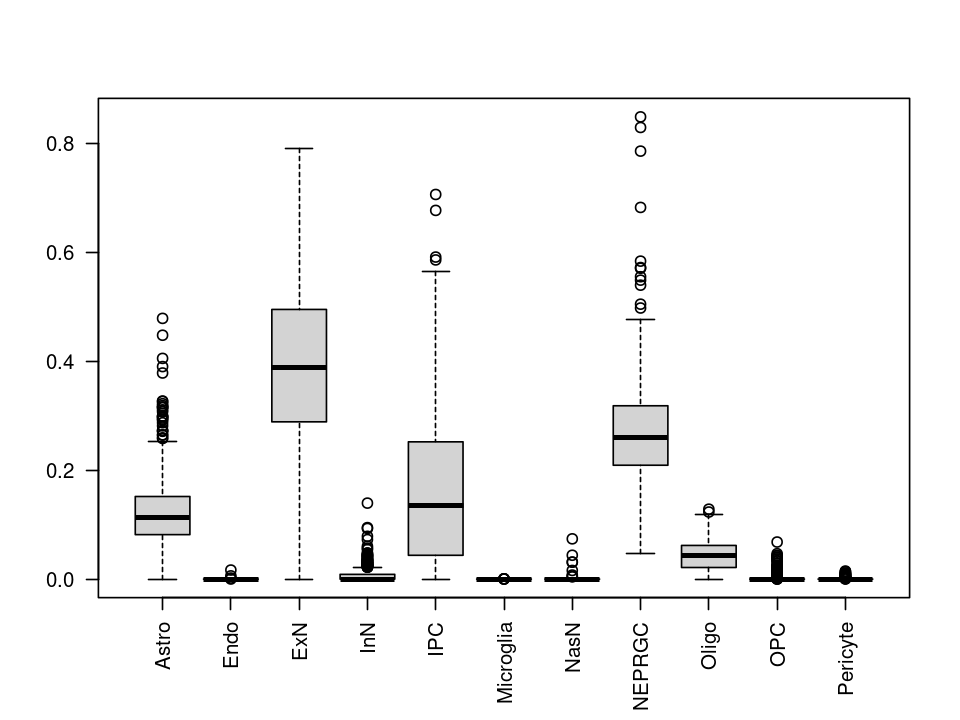

In [82]:
boxplot(cbprop,las=2)

In [62]:
bulk.meta <- read.table("~/project-gandalm/isoform_twas/eqtl_new/metadata_654.tsv", header = T)
head(bulk.meta)

Subject Age        Sex inferSex trimester ancestry study   pcw  
1 HSB100  -0.4027397 F   F        2         afr      werling 19.00
2 HSB152  -0.4602740 M   M        2         eur      werling 16.00
3 HSB195  -0.4219178 M   M        2         eur      werling 18.00
4 HSB221  -0.4027397 F   F        2         amr      werling 19.00
5 HSB222  -0.4823288 F   F        2         eur      werling 14.85
6 HSB238  -0.4794521 F   F        2         amr      werling 15.00

In [80]:
range(rowSums(cbprop))

[1] 1 1

In [83]:
cbprop.1 <- as.data.frame(cbprop)
cbprop.1$sampleID <- rownames(cbprop.1)
# head(cbprop.1)

In [64]:
head(prop)

sampleID Age        Sex inferSex trimester ancestry study  pcw variable
1 1474     -0.4986301 M   M        2         amr      walker 14  Astro   
2 1496     -0.4602740 F   F        2         amr      walker 16  Astro   
3 1500     -0.4794521 M   M        2         eur      walker 15  Astro   
4 1502     -0.4410959 M   M        2         amr      walker 17  Astro   
5 1507     -0.4602740 M   M        2         amr      walker 16  Astro   
6 1511     -0.4986301 NA  M        2         amr      walker 14  Astro   
  value     
1 0.16909894
2 0.11213322
3 0.09794963
4 0.10911150
5 0.07126345
6 0.15898105

In [85]:
colnames(prop)[9] <- "Supercluster"

In [84]:
cbprop.1 <- cbprop.1 %>% inner_join(bulk.meta, by = c("sampleID" = "Subject"))
prop <- melt(cbprop.1, id=c('sampleID',colnames(bulk.meta)[2:8]))
# head(prop)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


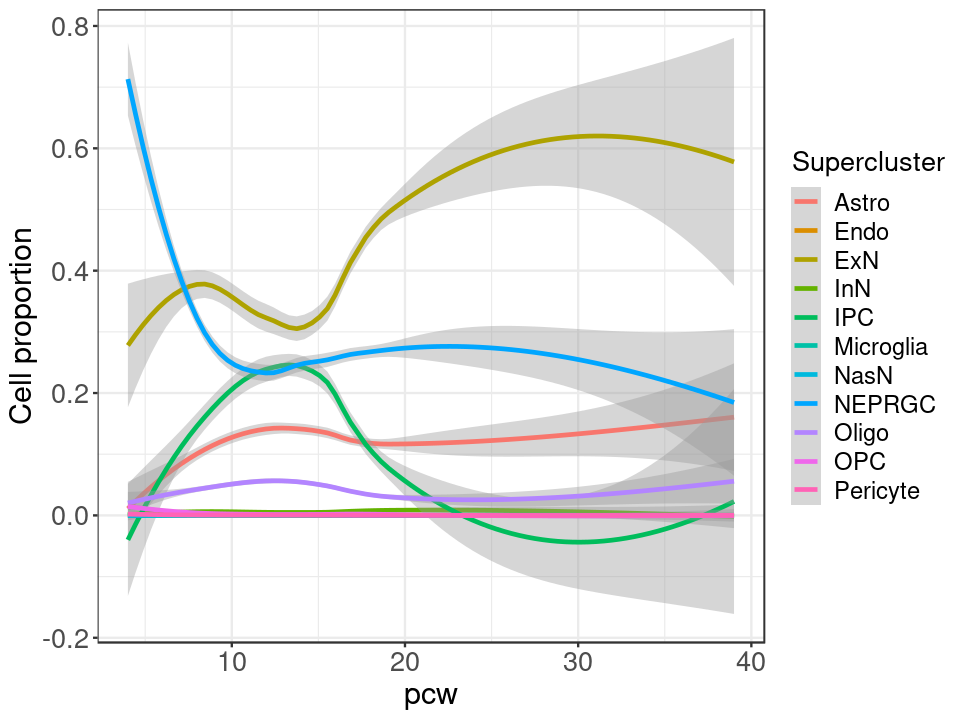

In [86]:
ggplot(prop, aes(x = pcw, y = value, color = Supercluster))+
    geom_smooth()+
    labs(y='Cell proportion') +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14))

**CIBERSORTx results**

In [4]:
res <- fread("../CIBERSORTx_Job4_Results.csv", data.table = F)
head(res)

Mixture Astro      Endo         ExN       InN        IPC       Microglia
1 1474    0.02091299 0.0008707837 0.2294398 0.04316693 0.6119126 0        
2 1496    0.02872257 0.0000000000 0.6902075 0.03554953 0.2124746 0        
3 1500    0.05221750 0.0000000000 0.4650354 0.03337915 0.4303914 0        
4 1502    0.04535497 0.0000000000 0.5897720 0.06146976 0.2574738 0        
5 1507    0.04363949 0.0000000000 0.6473317 0.00000000 0.2573714 0        
6 1511    0.02545911 0.0000000000 0.2156783 0.02041886 0.6044333 0        
  NasN        NEPRGC OPC Oligo        Pericyte   P-value Correlation RMSE     
1 0.081438182 0      0   0.0009761121 0.01128256 0       0.5623620   0.8586265
2 0.021180357 0      0   0.0000000000 0.01186544 0       0.6058001   0.8582278
3 0.005470292 0      0   0.0025636548 0.01094261 0       0.6001330   0.8587970
4 0.034809975 0      0   0.0007136974 0.01040581 0       0.5835340   0.8663835
5 0.033807075 0      0   0.0005469058 0.01730345 0       0.5971403   0.8627035
6 0.114143833 0      0   0.0002027004 0.01966385 0       0.6008107   0.8423479

In [5]:
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))

In [6]:
res <- res %>% select(-c(`P-value`, Correlation, RMSE))

In [7]:
# head(res)

In [8]:
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
# head(prop)

In [9]:
colnames(prop)[9] <- "Cluster"

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


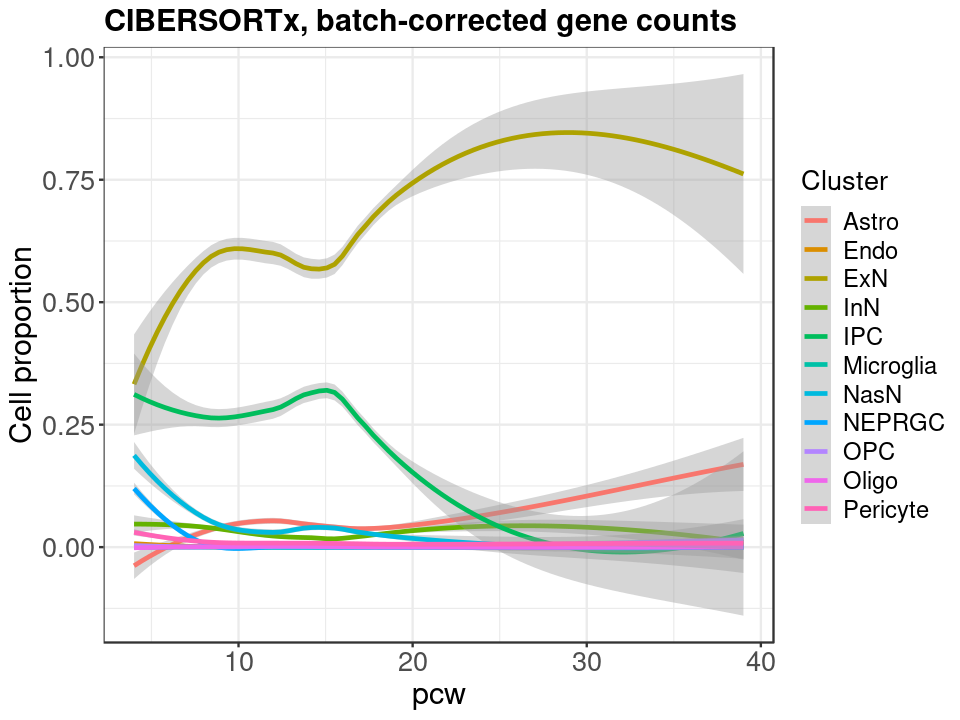

In [11]:
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_smooth()+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, batch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [12]:
ggsave("../figures/cibersortx_job4.pdf", height = 6, width = 8)

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


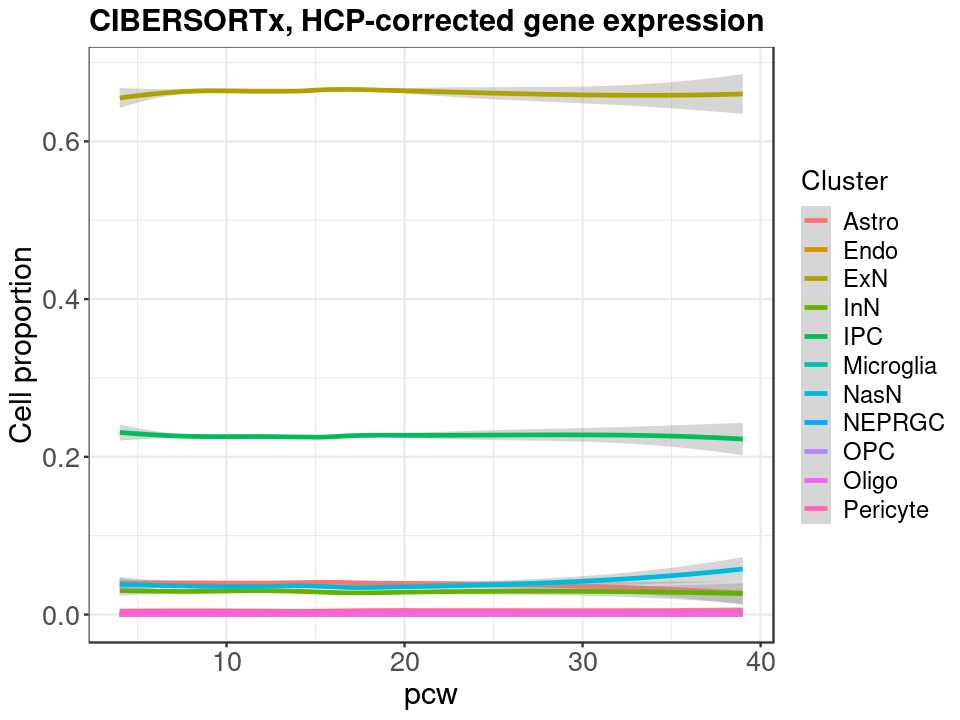

In [13]:
res <- fread("../CIBERSORTx_Job8_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_smooth()+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, HCP-corrected gene expression") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [14]:
ggsave("../figures/cibersortx_job8.pdf", height = 6, width = 8)

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


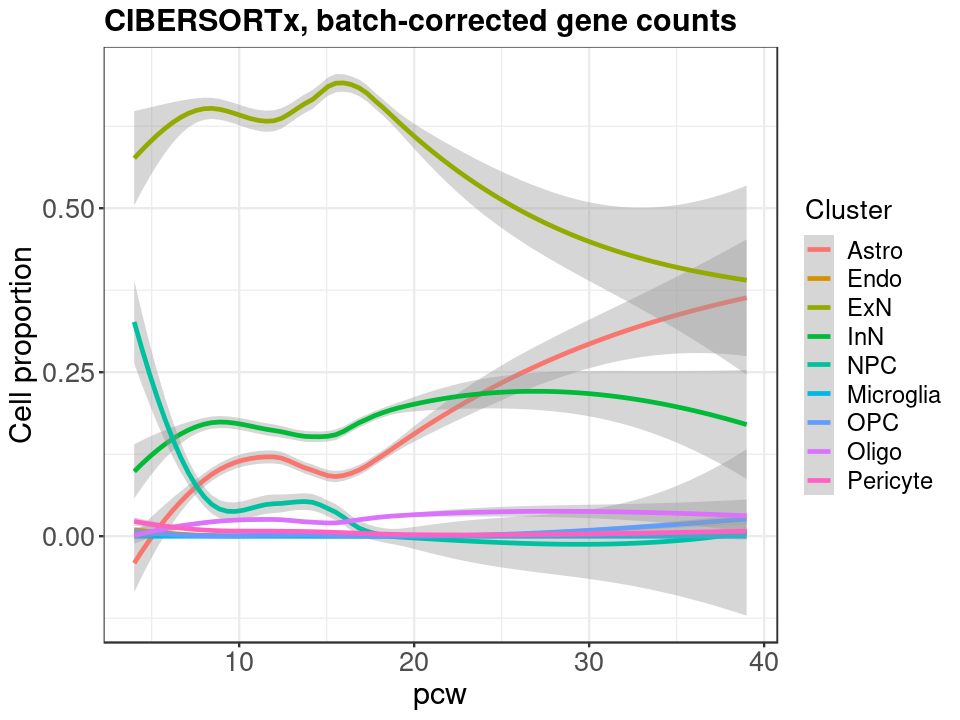

In [15]:
res <- fread("../CIBERSORTx_Job7_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_smooth()+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, batch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [16]:
ggsave("../figures/cibersortx_job7.pdf", height = 6, width = 8)

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


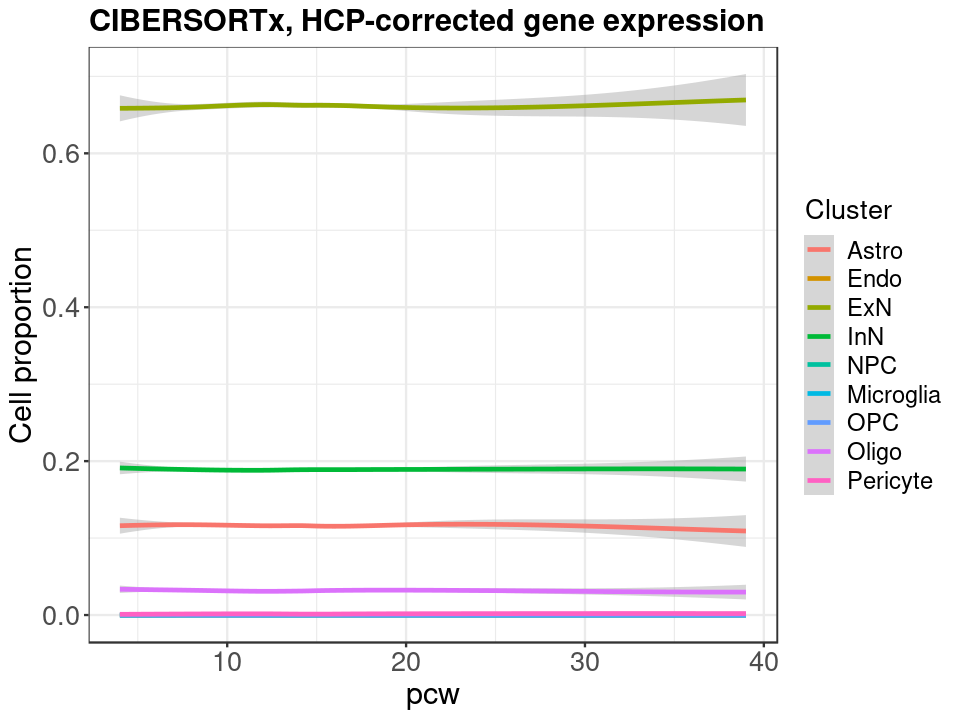

In [22]:
res <- fread("../CIBERSORTx_Job9_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_smooth()+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, HCP-corrected gene expression") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [23]:
ggsave("../figures/cibersortx_job9.pdf", height = 6, width = 8)

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


In [87]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job6_Results.csv", data.table = F)
# res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
head(res)

Mixture Astro     Endo ExN       InN       NPC      Microglia OPC Oligo     
1 1474    1.3401914 0    11.317230 2.7161654 8.139953 0         0   0.13039523
2 1496    1.9155124 0    13.165194 4.2516364 0.000000 0         0   0.51512114
3 1500    0.9776901 0    11.070941 3.0912574 1.817693 0         0   0.11045892
4 1502    2.0463720 0    12.235591 4.7304060 0.000000 0         0   0.46252802
5 1507    1.3346900 0     8.047795 1.8463794 0.000000 0         0   0.23684508
6 1511    0.9164004 0     5.659717 0.6965534 4.890304 0         0   0.05087296
  Pericyte  P-value Correlation RMSE      Absolute score (sig.score)
1 0.1246078 0       0.5516942   0.8757188 23.76854                  
2 0.1558084 0       0.4696364   0.9035166 20.00327                  
3 0.2995521 0       0.5680939   0.8720781 17.36759                  
4 0.0950819 0       0.4941497   0.8947231 19.56998                  
5 0.1260580 0       0.4721038   0.9042439 11.59177                  
6 0.2433718 0       0.5687244   0.8685682 12.45722

In [86]:
head(res)

Mixture Astro     Endo ExN       InN       NPC      Microglia OPC Oligo     
1 1474    1.3401914 0    11.317230 2.7161654 8.139953 0         0   0.13039523
2 1496    1.9155124 0    13.165194 4.2516364 0.000000 0         0   0.51512114
3 1500    0.9776901 0    11.070941 3.0912574 1.817693 0         0   0.11045892
4 1502    2.0463720 0    12.235591 4.7304060 0.000000 0         0   0.46252802
5 1507    1.3346900 0     8.047795 1.8463794 0.000000 0         0   0.23684508
6 1511    0.9164004 0     5.659717 0.6965534 4.890304 0         0   0.05087296
  Pericyte  ... Correlation RMSE      Absolute score (sig.score) Age        Sex
1 0.1246078 ... 0.5516942   0.8757188 23.76854                   -0.4986301 M  
2 0.1558084 ... 0.4696364   0.9035166 20.00327                   -0.4602740 F  
3 0.2995521 ... 0.5680939   0.8720781 17.36759                   -0.4794521 M  
4 0.0950819 ... 0.4941497   0.8947231 19.56998                   -0.4410959 M  
5 0.1260580 ... 0.4721038   0.9042439 11.59177                   -0.4602740 M  
6 0.2433718 ... 0.5687244   0.8685682 12.45722                   -0.4986301 NA 
  inferSex trimester ancestry study  pcw
1 M        2         amr      walker 14 
2 F        2         amr      walker 16 
3 M        2         eur      walker 15 
4 M        2         amr      walker 17 
5 M        2         amr      walker 16 
6 M        2         amr      walker 14

In [33]:
# res <- res %>% select(-c(`P-value`, Correlation, RMSE, `Absolute score (sig.score)`))
# prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
# colnames(prop)[9] <- "Cluster"
# options(repr.plot.height = 6, repr.plot.width = 8)
# ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
#     geom_smooth()+
#     labs(y='Cell proportion') +
#     theme_bw() +
#     ggtitle("CIBERSORTx, absolute mode") +
#     theme(axis.text = element_text(size = 16),
#           axis.title = element_text(size = 18),
#           legend.title = element_text(size = 16),
#           legend.text = element_text(size = 14),
#           plot.title = element_text(size = 18, face = "bold"))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


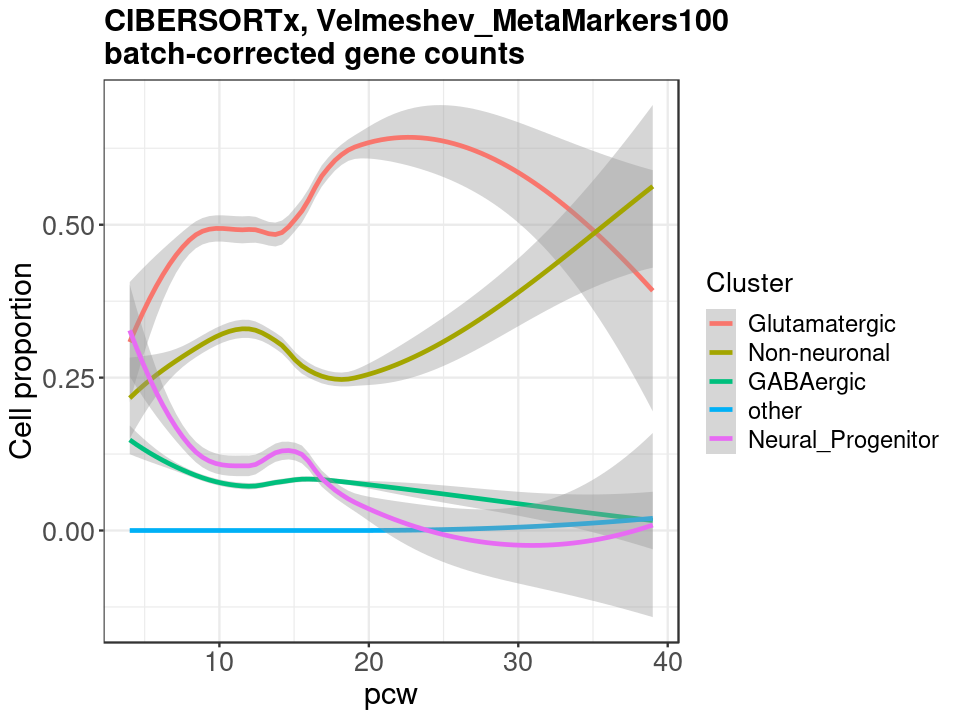

In [36]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job10_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_smooth()+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, Velmeshev_MetaMarkers100\nbatch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [37]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/cibersortx_job10.pdf", height = 6, width = 8)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


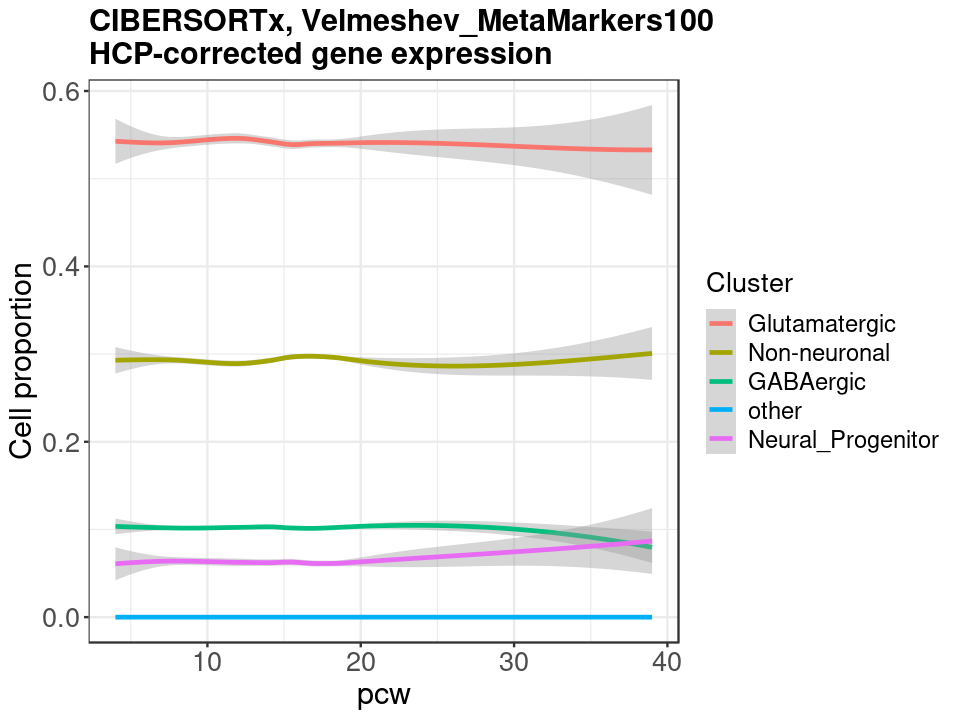

In [38]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job11_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_smooth()+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, Velmeshev_MetaMarkers100\nHCP-corrected gene expression") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [82]:
head(res)

Mixture Dividing_Progenitor GABAergic  Glutamatergic Intermediate_Progenitor
1 1474    0.28718293          0.03693335 0.4674456     0                      
2 1496    0.03206182          0.06016781 0.8037501     0                      
3 1500    0.18461627          0.04730304 0.6374607     0                      
4 1502    0.05098669          0.11217689 0.7493365     0                      
5 1507    0.07752556          0.01269082 0.7538402     0                      
6 1511    0.27316683          0.00000000 0.4842830     0                      
  Neural_Progenitor Non-neuronal other       Age        Sex inferSex trimester
1 0.20843817        0            0.000000000 -0.4986301 M   M        2        
2 0.10402030        0            0.000000000 -0.4602740 F   F        2        
3 0.13061997        0            0.000000000 -0.4794521 M   M        2        
4 0.08613208        0            0.001367791 -0.4410959 M   M        2        
5 0.08216739        0            0.073776064 -0.4602740 M   M        2        
6 0.23907375        0            0.003476415 -0.4986301 NA  M        2        
  ancestry study  pcw
1 amr      walker 14 
2 amr      walker 16 
3 eur      walker 15 
4 amr      walker 17 
5 amr      walker 16 
6 amr      walker 14

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


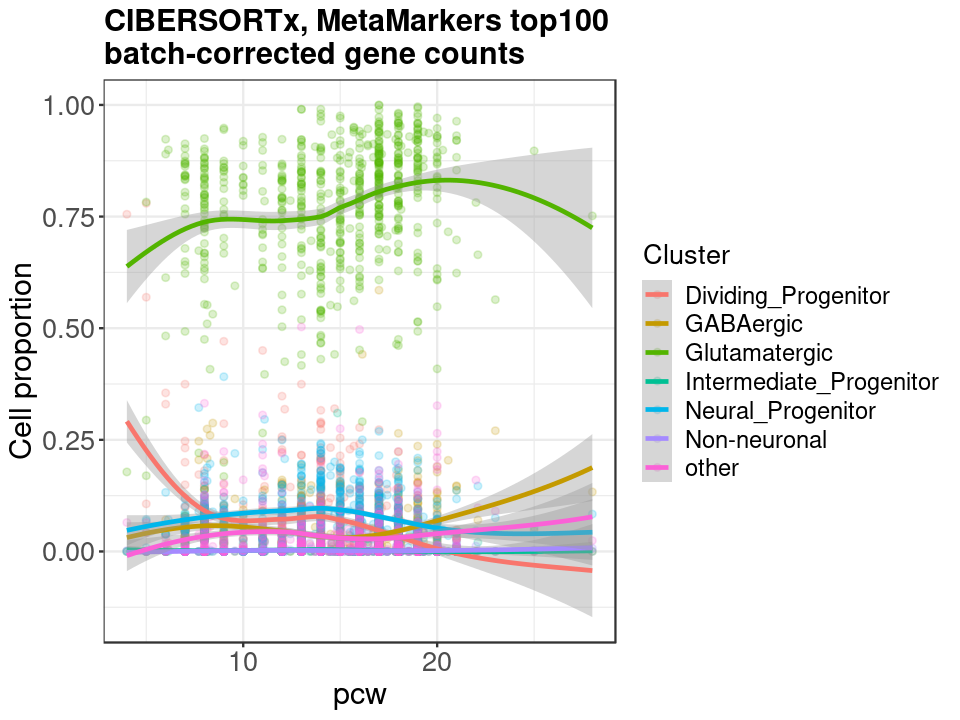

In [96]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job12_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop %>% filter(pcw <= 30), aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .9)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, MetaMarkers top100\nbatch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


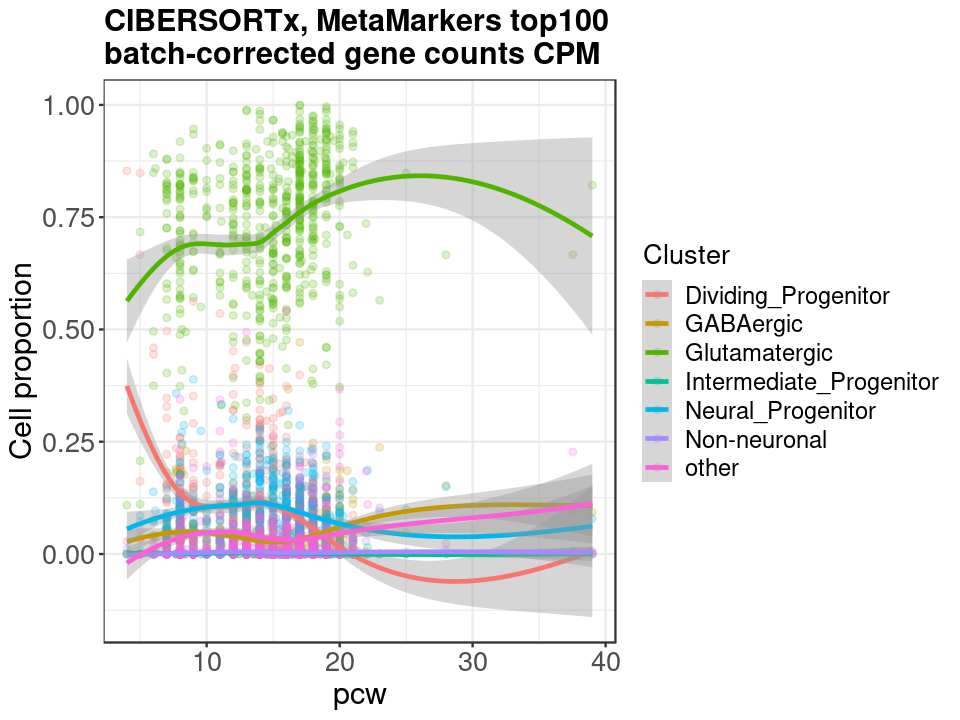

In [99]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job15_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .9)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, MetaMarkers top100\nbatch-corrected gene counts CPM") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [102]:
head(res)
range(rowSums(res[,2:8]))

Mixture Dividing_Progenitor GABAergic   Glutamatergic Intermediate_Progenitor
1 1496    0.05022244          0.053851126 0.7630280     0                      
2 1500    0.19430893          0.023534054 0.6126290     0                      
3 1502    0.06169875          0.103577740 0.7065746     0                      
4 1507    0.07051929          0.007897223 0.7193525     0                      
5 1511    0.30490845          0.007206282 0.4262125     0                      
6 1513    0.11509743          0.056816264 0.6523066     0                      
  Neural_Progenitor Non-neuronal other       Age        Sex inferSex trimester
1 0.1272492         0            0.005649199 -0.4602740 F   F        2        
2 0.1641340         0            0.005394075 -0.4794521 M   M        2        
3 0.1232026         0            0.004946332 -0.4410959 M   M        2        
4 0.1300021         0            0.072228928 -0.4602740 M   M        2        
5 0.2539026         0            0.007770174 -0.4986301 NA  M        2        
6 0.1545674         0            0.021212253 -0.4602740 M   M        2        
  ancestry study  pcw
1 amr      walker 16 
2 eur      walker 15 
3 amr      walker 17 
4 amr      walker 16 
5 amr      walker 14 
6 amr      walker 16

[1] 1 1

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


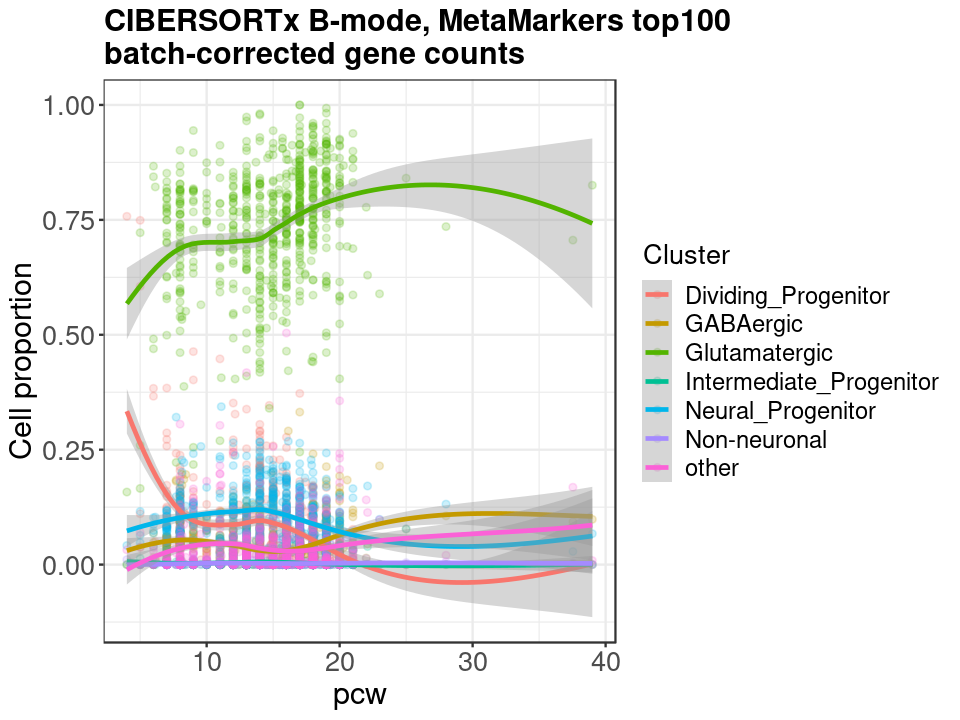

In [36]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job18_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .9)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx B-mode, MetaMarkers top100\nbatch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


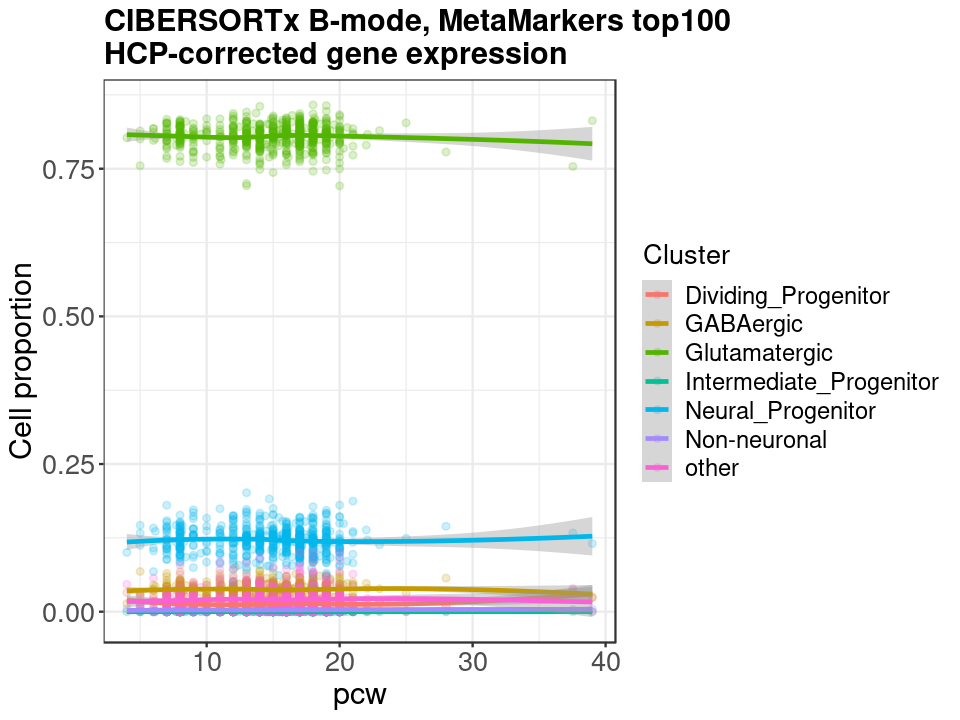

In [30]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job17_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop, aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .9)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx B-mode, MetaMarkers top100\nHCP-corrected gene expression") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


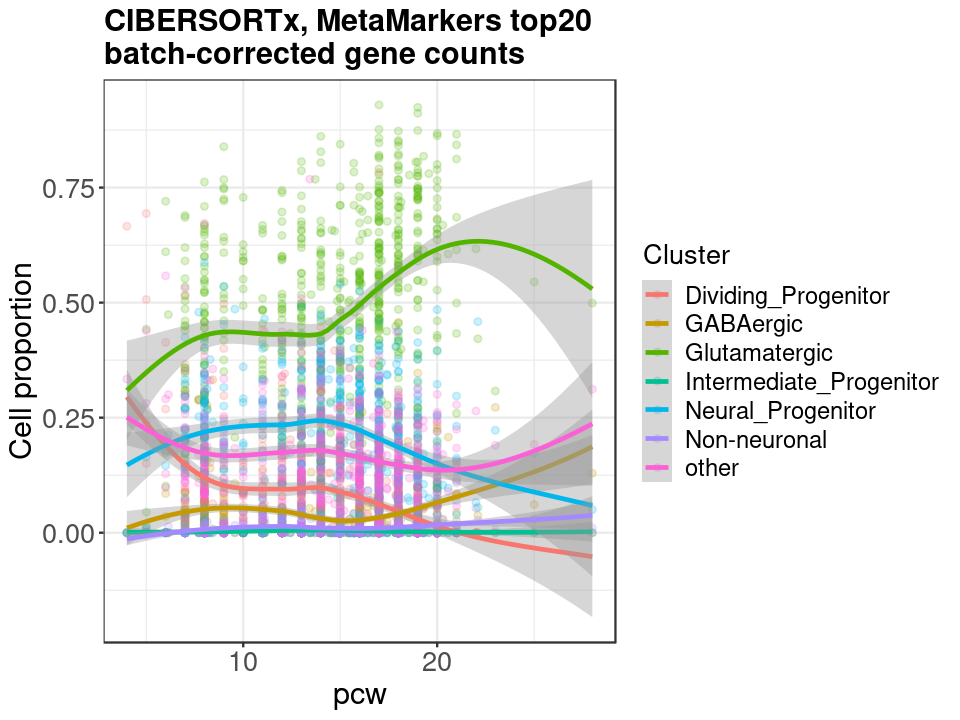

In [38]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job19_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop %>% filter(pcw<=30), aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .9)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, MetaMarkers top20\nbatch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


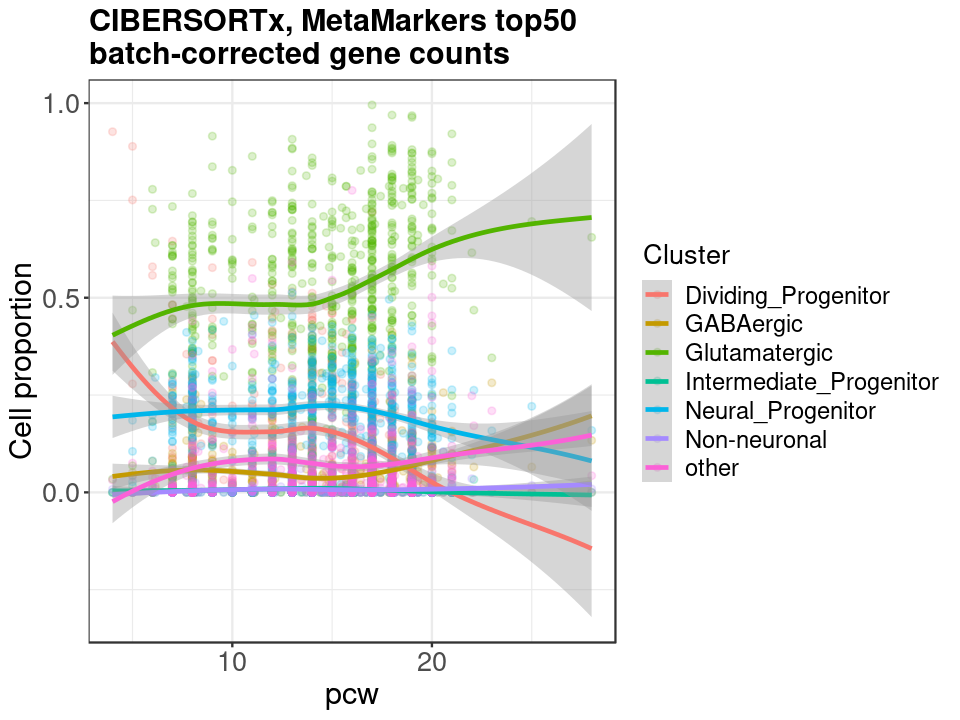

In [3]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job20_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop %>% filter(pcw<=30), aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .95)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, MetaMarkers top50\nbatch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [ ]:
ggsave("../figures/cibsortx_job20.pdf", height = 6, width = 8)

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


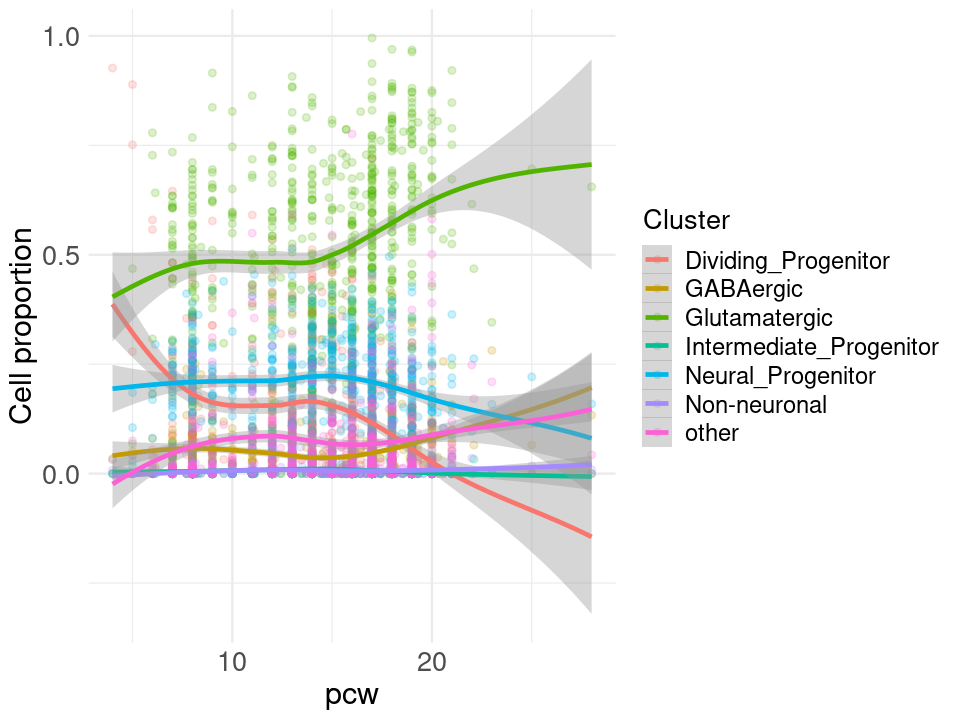

In [4]:
ggplot(prop %>% filter(pcw<=30), aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .95)+
    labs(y='Cell proportion') +
    theme_minimal() +
#     ggtitle("CIBERSORTx, MetaMarkers top50\nbatch-corrected gene counts") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [5]:
ggsave("../figures/cibsortx_job20_v1.pdf", height = 6, width = 8)

`geom_smooth()` using method =
'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


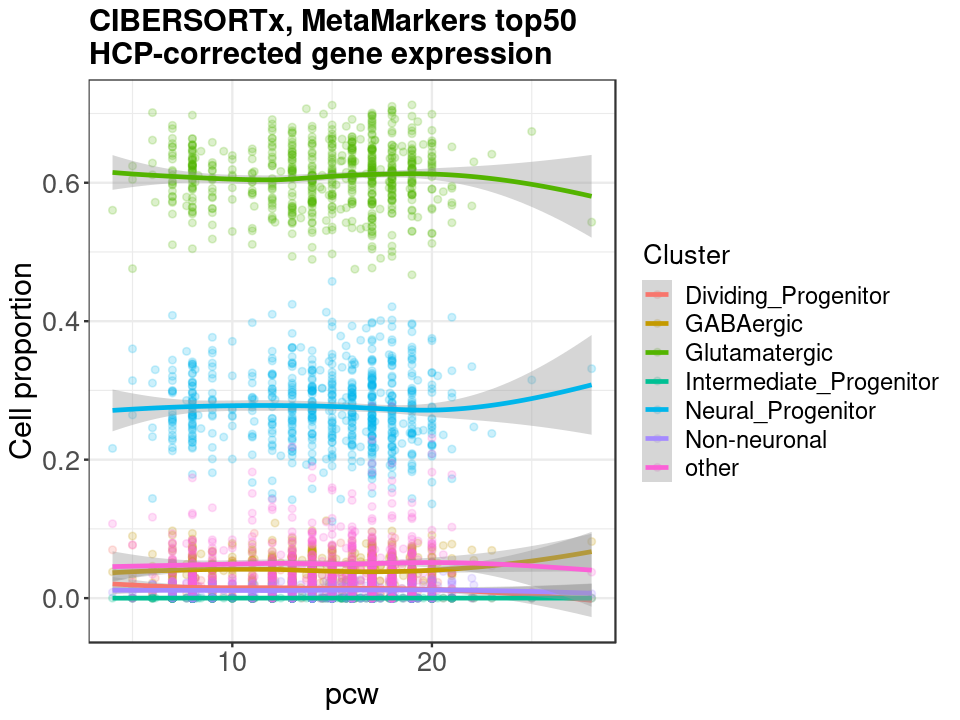

In [54]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job21_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop %>% filter(pcw<=30), aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .95)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, MetaMarkers top50\nHCP-corrected gene expression") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [55]:
ggsave("../figures/cibsortx_job21.pdf", height = 6, width = 8)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


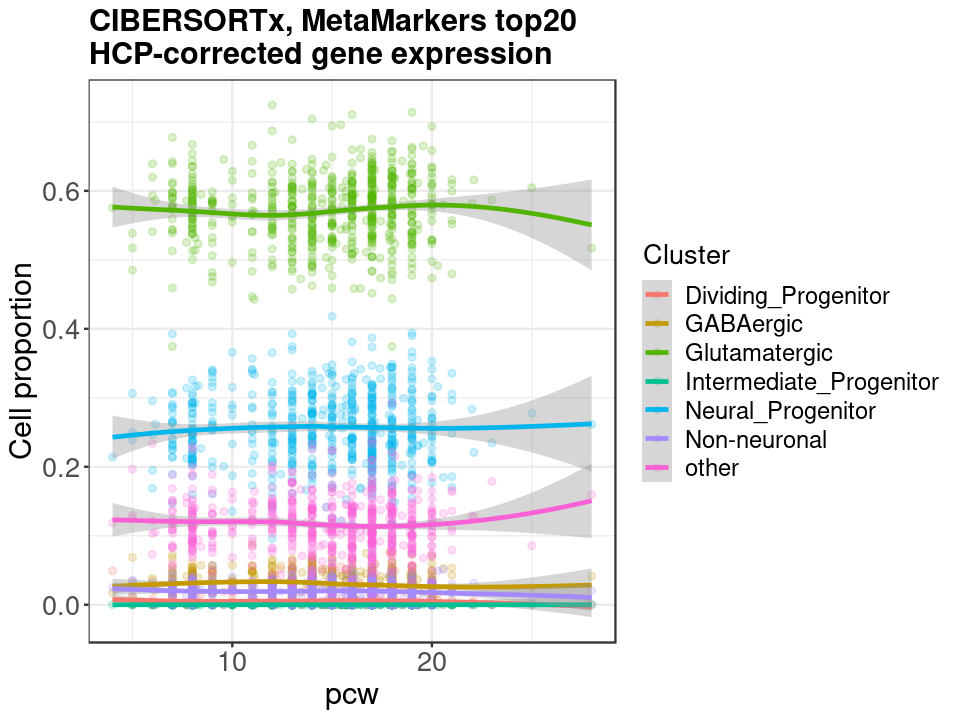

In [40]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job22_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop %>% filter(pcw<=30), aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .9)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, MetaMarkers top20\nHCP-corrected gene expression") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

In [9]:
head(prop)

Mixture Age        Sex inferSex trimester ancestry study pcw
1 898     -0.5369863 F   F        1         eur      hdbr  12 
2 1038    -0.6328767 M   M        1         eur      hdbr   7 
3 1046    -0.5753425 F   F        1         eur      hdbr  10 
4 1102    -0.5369863 F   F        1         eur      hdbr  12 
5 1107    -0.4602740 NA  M        2         eur      hdbr  16 
6 1110    -0.5561644 NA  M        1         eur      hdbr  11 
  Cluster             value      
1 Dividing_Progenitor 0.001786288
2 Dividing_Progenitor 0.010086445
3 Dividing_Progenitor 0.027924860
4 Dividing_Progenitor 0.000000000
5 Dividing_Progenitor 0.000000000
6 Dividing_Progenitor 0.000000000

In [10]:
table(prop$trimester)


  1   2   3 
959 987  14 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


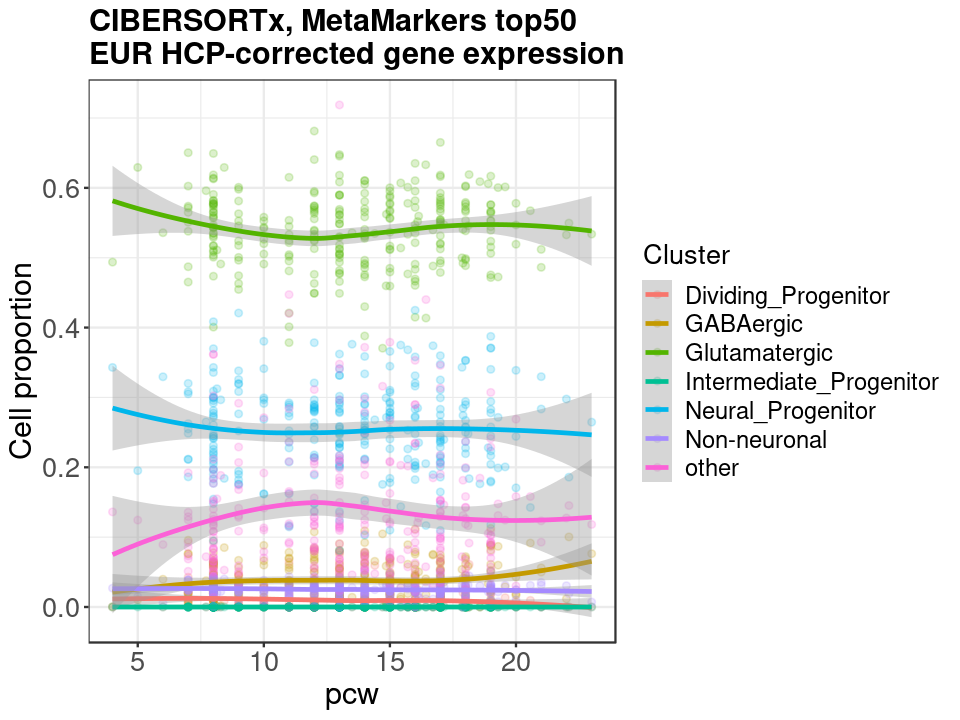

In [11]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/CIBERSORTx_Job23_Results.csv", data.table = F)
res <- res %>% inner_join(bulk.meta, by = c("Mixture" = "Subject"))
res <- res %>% select(-c(`P-value`, Correlation, RMSE))
prop <- melt(res, id=c('Mixture',colnames(bulk.meta)[2:8]))
colnames(prop)[9] <- "Cluster"
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(prop %>% filter(trimester %in% c(1, 2)), aes(x = pcw, y = value, color = Cluster))+
    geom_point(alpha = .2) +
    geom_smooth(span = .9)+
    labs(y='Cell proportion') +
    theme_bw() +
    ggtitle("CIBERSORTx, MetaMarkers top50\nEUR HCP-corrected gene expression") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          plot.title = element_text(size = 18, face = "bold"))

**cov regressed expression, HCP included**

In [6]:
# gene expression Daniel used to run GCTA, partitioned into tri1, 2, sliding windows
eur <- fread("~/project-gandalm/isoform_twas/TWAS/data/eur_gene_exp_regressed.txt", data.table = F)

In [7]:
eur.expr <- eur[,5:284]
eur.genes <- eur %>% select(TargetID)
eur.genes <- eur.genes %>% inner_join(annot, by = c("TargetID" = "ensg"))
eur.genes <- eur.genes %>% select(TargetID, V12)
eur.df <- cbind(eur.genes, eur.expr)
dup.genes <- eur.df[which(duplicated(eur.df$V12)),'V12']
length(unique(dup.genes))
eur.df <- eur.df %>% filter(!V12 %in% dup.genes)
eur.cibersortx <- eur.df[,-1]
colnames(eur.cibersortx)[1] <- "Gene"
head(eur.cibersortx)
write.table(eur.cibersortx, "~/project-gandalm/isoform_twas/eqtl_new/eur.HCP.cibersortx.tsv", col.names = T, row.names = F, quote = F, sep ="\t")

[1] 193

Gene        898      1038      1046      1102      1107     1110      
1 DDX11L1     2.565564 3.6053417 1.8360737 1.9991702 1.904191  3.5480882
2 MIR1302-2HG 2.819398 1.0959469 2.8483054 2.1622183 1.571914  1.7570492
3 WASH7P      8.340482 8.7758971 9.3344082 8.3531372 8.590556  8.7678620
4 FAM138A     3.901713 3.1812980 3.1201478 4.1157479 3.414270  4.7278982
5 AL627309.3  1.720500 0.5282807 0.5575717 0.6424397 1.850878 -0.2967324
6 CICP27      5.220183 4.4191885 3.8402640 4.3866399 5.164541  4.8757581
  1111       1115      1117     ... RNAID1922 RNAID1936  RNAID1938 RNAID1939
1  1.9993190 3.3297920 3.190488 ... 2.132243   3.3003805 3.177607  3.5299871
2  2.7841404 1.9969732 1.810719 ... 1.433819   2.6111706 1.270131  3.1224558
3  8.9477909 8.8842820 8.655490 ... 8.770681   8.2024261 7.868934  8.7785143
4  3.7575330 3.4443580 4.062081 ... 0.557910   3.9508007 2.696453  3.7811057
5 -0.2463641 0.8456203 1.855271 ... 1.929382  -0.4598936 2.152505  0.9581094
6  3.0954827 4.1702121 3.846752 ... 4.957508   4.0326060 4.023465  4.7190258
  RNAID1944 RNAID1952 RNAID1974 RNAID1983 RNAID1987 RNAID2144
1 2.848982  4.073260  2.0589195 3.457027  2.875230  2.002251 
2 1.802944  1.197524  3.4933517 1.986875  2.338058  2.558506 
3 8.892686  8.820818  8.2291373 9.059215  8.577134  8.435131 
4 4.542311  4.005088  2.7271515 1.380424  3.161670  4.537650 
5 1.473670  1.593463  0.6791255 0.365894  0.664181  1.591270 
6 4.536816  3.629671  4.2418672 4.279393  4.052386  4.469380

In [40]:
bulk <- fread("~/project-gandalm/isoform_twas/TWAS/data/all_gene_exp_regressed.txt", data.table = F)
head(bulk)

TargetID        Gene_Symbol     Chr Coord  1474     1496     1500    
1 ENSG00000223972 ENSG00000223972 1    11868 2.867789 3.296470 2.200791
2 ENSG00000243485 ENSG00000243485 1    29553 2.060708 1.581782 2.679413
3 ENSG00000227232 ENSG00000227232 1    29569 8.811202 8.280995 8.931025
4 ENSG00000237613 ENSG00000237613 1    36080 4.895634 4.615218 4.995389
5 ENSG00000239945 ENSG00000239945 1    91104 1.322099 2.477211 2.435626
6 ENSG00000233750 ENSG00000233750 1   131024 4.261517 4.511196 4.226093
  1502     1507      1511     ... 1558     1607     1707.1   1835     1851    
1 2.684605 1.4565833 3.400122 ... 2.852729 2.339485 2.943993 3.169074 2.995443
2 2.830359 1.4140588 3.376425 ... 1.237803 1.312254 2.414263 1.898056 2.520261
3 8.949145 8.3683365 9.113657 ... 7.633874 8.261629 8.822906 7.728855 8.552273
4 4.928265 4.8845307 4.361184 ... 3.829474 4.982749 4.022271 4.088187 4.231415
5 2.840091 0.6167818 1.252557 ... 1.522859 2.418559 1.408638 2.505883 4.130191
6 4.049178 4.7536951 4.284809 ... 4.438547 4.543358 4.305752 4.365838 4.230395
  1890     1923     2193     849      898     
1 3.501674 2.804495 1.687725 1.808905 1.666353
2 2.140663 2.337385 2.204175 2.321048 2.050840
3 8.871003 8.440336 9.129610 7.818537 8.283419
4 3.810719 3.647314 5.210864 4.068420 4.540590
5 3.238845 1.706037 1.256406 1.003519 2.954425
6 3.963106 4.015720 4.033887 4.405711 5.244836

In [41]:
bulk.expr <- bulk[,5:633]
bulk.genes <- bulk %>% select(TargetID)

In [43]:
bulk.genes <- bulk.genes %>% inner_join(annot, by = c("TargetID" = "ensg"))

In [44]:
bulk.genes <- bulk.genes %>% select(TargetID, V12)

In [45]:
bulk.df <- cbind(bulk.genes, bulk.expr)

In [46]:
head(bulk.df)

TargetID        V12         1474     1496     1500     1502     1507     
1 ENSG00000223972 DDX11L1     2.867789 3.296470 2.200791 2.684605 1.4565833
2 ENSG00000243485 MIR1302-2HG 2.060708 1.581782 2.679413 2.830359 1.4140588
3 ENSG00000227232 WASH7P      8.811202 8.280995 8.931025 8.949145 8.3683365
4 ENSG00000237613 FAM138A     4.895634 4.615218 4.995389 4.928265 4.8845307
5 ENSG00000239945 AL627309.3  1.322099 2.477211 2.435626 2.840091 0.6167818
6 ENSG00000233750 CICP27      4.261517 4.511196 4.226093 4.049178 4.7536951
  1511     1513     1525      ... 1558     1607     1707.1   1835     1851    
1 3.400122 1.017490 0.9603317 ... 2.852729 2.339485 2.943993 3.169074 2.995443
2 3.376425 1.656341 2.0834450 ... 1.237803 1.312254 2.414263 1.898056 2.520261
3 9.113657 8.919081 8.5016701 ... 7.633874 8.261629 8.822906 7.728855 8.552273
4 4.361184 4.768870 5.3094919 ... 3.829474 4.982749 4.022271 4.088187 4.231415
5 1.252557 1.184240 1.4249191 ... 1.522859 2.418559 1.408638 2.505883 4.130191
6 4.284809 4.366938 3.0368784 ... 4.438547 4.543358 4.305752 4.365838 4.230395
  1890     1923     2193     849      898     
1 3.501674 2.804495 1.687725 1.808905 1.666353
2 2.140663 2.337385 2.204175 2.321048 2.050840
3 8.871003 8.440336 9.129610 7.818537 8.283419
4 3.810719 3.647314 5.210864 4.068420 4.540590
5 3.238845 1.706037 1.256406 1.003519 2.954425
6 3.963106 4.015720 4.033887 4.405711 5.244836

In [47]:
dup.genes <- bulk.df[which(duplicated(bulk.df$V12)),'V12']
length(dup.genes)

[1] 538

In [48]:
bulk.df <- bulk.df %>% filter(!V12 %in% dup.genes)

In [49]:
bulk.cibersortx <- bulk.df[,-1]
colnames(bulk.cibersortx)[1] <- "Gene"
head(bulk.cibersortx)

Gene        1474     1496     1500     1502     1507      1511     1513    
1 DDX11L1     2.867789 3.296470 2.200791 2.684605 1.4565833 3.400122 1.017490
2 MIR1302-2HG 2.060708 1.581782 2.679413 2.830359 1.4140588 3.376425 1.656341
3 WASH7P      8.811202 8.280995 8.931025 8.949145 8.3683365 9.113657 8.919081
4 FAM138A     4.895634 4.615218 4.995389 4.928265 4.8845307 4.361184 4.768870
5 AL627309.3  1.322099 2.477211 2.435626 2.840091 0.6167818 1.252557 1.184240
6 CICP27      4.261517 4.511196 4.226093 4.049178 4.7536951 4.284809 4.366938
  1525      1531     ... 1558     1607     1707.1   1835     1851     1890    
1 0.9603317 2.611516 ... 2.852729 2.339485 2.943993 3.169074 2.995443 3.501674
2 2.0834450 1.724222 ... 1.237803 1.312254 2.414263 1.898056 2.520261 2.140663
3 8.5016701 8.582253 ... 7.633874 8.261629 8.822906 7.728855 8.552273 8.871003
4 5.3094919 4.451794 ... 3.829474 4.982749 4.022271 4.088187 4.231415 3.810719
5 1.4249191 2.130361 ... 1.522859 2.418559 1.408638 2.505883 4.130191 3.238845
6 3.0368784 4.459563 ... 4.438547 4.543358 4.305752 4.365838 4.230395 3.963106
  1923     2193     849      898     
1 2.804495 1.687725 1.808905 1.666353
2 2.337385 2.204175 2.321048 2.050840
3 8.440336 9.129610 7.818537 8.283419
4 3.647314 5.210864 4.068420 4.540590
5 1.706037 1.256406 1.003519 2.954425
6 4.015720 4.033887 4.405711 5.244836

In [50]:
length(unique(bulk.cibersortx$Gene))

[1] 30800

In [51]:
dim(bulk.cibersortx)

[1] 30800   630

In [52]:
max(bulk.cibersortx[,2:629])

[1] 22.77183

In [52]:
write.table(bulk.cibersortx, "../bulk.HCP.cibersortx.tsv", col.names = T, row.names = F, quote = F, sep ="\t")

In [163]:
tmp <- intersect(markers_top100$gene, rownames(ref))
length(tmp)
tmp <- intersect(tmp,bulk.df$V12)
length(tmp)

sig <- ref[match(tmp, rownames(ref)),]
mix <- bulk.df[match(tmp,bulk.df$V12),]
rownames(mix) <- rownames(sig)
dim(sig)
dim(mix)

[1] 1014

[1] 896

[1] 896  11

[1] 896 631

In [164]:
head(sig)
head(mix)

Astro      Endo     ExN InN IPC Microglia NasN NEPRGC Oligo  
LINC00943   55.85032   0.0000 0   0   0   0         0    0       0.0000
NPNT       184.30606   0.0000 0   0   0   0         0    0       0.0000
GFAP       396.53728   0.0000 0   0   0   0         0    0       0.0000
HOPX      1306.89751 255.3192 0   0   0   0         0    0      12.9819
GPR37L1     11.17006   0.0000 0   0   0   0         0    0       0.0000
FGF1        11.17006   0.0000 0   0   0   0         0    0       0.0000
          OPC      Pericyte
LINC00943   0.0000 0.000000
NPNT        0.0000 0.000000
GFAP        0.0000 0.000000
HOPX      132.6783 1.546456
GPR37L1     0.0000 0.000000
FGF1        0.0000 0.000000

TargetID        V12       1474     1496     1500     1502    
LINC00943 ENSG00000189238 LINC00943 6.986425 7.017741 6.770536 7.607980
NPNT      ENSG00000168743 NPNT      8.288340 8.453190 8.170291 7.295474
GFAP      ENSG00000131095 GFAP      8.797798 9.486074 8.747969 9.236726
HOPX      ENSG00000171476 HOPX      9.713620 9.266964 8.516028 9.268211
GPR37L1   ENSG00000170075 GPR37L1   5.391378 5.612453 6.179993 5.934657
FGF1      ENSG00000113578 FGF1      5.813024 4.800488 5.522439 6.543009
          1507     1511      1513     1525     ... 1558     1607     1707.1  
LINC00943 7.294219  6.482539 7.596881 7.550863 ... 7.514343 6.860546 7.510760
NPNT      8.723173  7.254754 7.828057 7.233509 ... 8.591136 7.868331 8.302639
GFAP      9.178858 10.009639 9.504433 9.725200 ... 8.980284 9.866692 9.441212
HOPX      9.194318  9.367768 9.162317 9.480740 ... 8.757151 9.005403 8.845700
GPR37L1   5.472946  5.206138 5.386269 5.505860 ... 5.385260 4.754346 5.487935
FGF1      6.024574  6.126884 5.037092 6.613846 ... 5.379904 5.565513 5.303327
          1835      1851     1890     1923     2193     849      898     
LINC00943  6.588569 7.425292 7.789623 7.360181 7.728365 7.239783 7.354022
NPNT       8.033169 8.902821 8.034219 8.256700 7.562837 7.904780 8.110831
GFAP      10.403180 9.773347 8.672919 9.103950 9.297245 9.160601 8.509542
HOPX       8.810901 9.208130 8.808167 9.012508 8.557550 8.563998 9.202661
GPR37L1    5.674768 5.466823 5.809258 5.960138 5.312227 5.921256 4.944199
FGF1       5.977155 6.257179 5.375892 6.062021 5.148670 6.188303 5.669204

In [165]:
mix <- mix %>% select(-1, -2)

In [85]:
source('scripts/CIBERSORT.R')

In [166]:
cbprop <- CIBERSORT(sig, mix, perm=0, QN=TRUE, absolute=FALSE, abs_method='sig.score')[,1:ncol(sig)]

In [107]:
head(cbprop)

Astro     Endo ExN       InN IPC       Microglia    NasN NEPRGC    
1474 0.2182148 0    0.4143502 0   0.2011313 0.0019621701 0    0.12393590
1496 0.2176767 0    0.4218562 0   0.1441286 0.0068002718 0    0.16326661
1500 0.2040594 0    0.4475277 0   0.1533679 0.0002987014 0    0.13649700
1502 0.2527443 0    0.3944323 0   0.2043928 0.0029259453 0    0.08784844
1507 0.2325750 0    0.4178021 0   0.1713707 0.0020927894 0    0.13805530
1511 0.2323462 0    0.4349149 0   0.1311070 0.0065693933 0    0.14496415
     Oligo      OPC Pericyte
1474 0.04040557 0   0       
1496 0.04627158 0   0       
1500 0.05824929 0   0       
1502 0.05765623 0   0       
1507 0.03810423 0   0       
1511 0.05009838 0   0

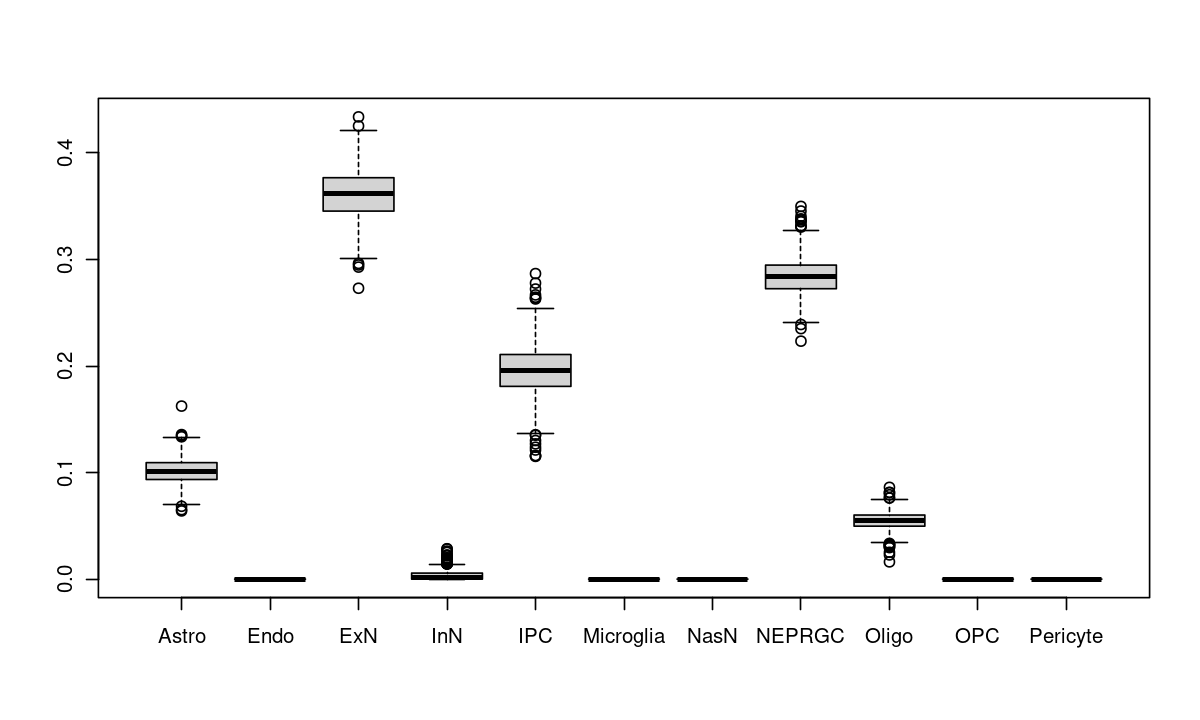

In [167]:
options(repr.plot.width = 10, repr.plot.height = 6)
boxplot(cbprop)

In [169]:
range(rowSums(cbprop))

[1] 1 1

In [170]:
dim(cbprop)

[1] 629  11

In [171]:
cbprop.1 <- as.data.frame(cbprop)
cbprop.1$sampleID <- rownames(cbprop.1)
head(cbprop.1)

Astro      Endo ExN       InN         IPC       Microglia NasN NEPRGC   
1474 0.11176999 0    0.3247873 0.015523976 0.2346012 0         0    0.2571025
1496 0.11786125 0    0.3446625 0.001906451 0.1724731 0         0    0.3156240
1500 0.08903335 0    0.3884423 0.000000000 0.1970058 0         0    0.2699016
1502 0.09649194 0    0.3689018 0.000000000 0.2087806 0         0    0.2720708
1507 0.10047141 0    0.3670139 0.000000000 0.2007155 0         0    0.2807605
1511 0.09061290 0    0.3421699 0.007417268 0.1685715 0         0    0.3372339
     Oligo      OPC Pericyte sampleID
1474 0.05621495 0   0        1474    
1496 0.04747275 0   0        1496    
1500 0.05561699 0   0        1500    
1502 0.05375476 0   0        1502    
1507 0.05103874 0   0        1507    
1511 0.05399457 0   0        1511

In [172]:
cbprop.1 <- cbprop.1 %>% inner_join(bulk.meta, by = c("sampleID" = "Subject"))
head(cbprop.1)

Astro      Endo ExN       InN         IPC       Microglia NasN NEPRGC   
1 0.11176999 0    0.3247873 0.015523976 0.2346012 0         0    0.2571025
2 0.11786125 0    0.3446625 0.001906451 0.1724731 0         0    0.3156240
3 0.08903335 0    0.3884423 0.000000000 0.1970058 0         0    0.2699016
4 0.09649194 0    0.3689018 0.000000000 0.2087806 0         0    0.2720708
5 0.10047141 0    0.3670139 0.000000000 0.2007155 0         0    0.2807605
6 0.09061290 0    0.3421699 0.007417268 0.1685715 0         0    0.3372339
  Oligo      OPC Pericyte sampleID Age        Sex inferSex trimester ancestry
1 0.05621495 0   0        1474     -0.4986301 M   M        2         amr     
2 0.04747275 0   0        1496     -0.4602740 F   F        2         amr     
3 0.05561699 0   0        1500     -0.4794521 M   M        2         eur     
4 0.05375476 0   0        1502     -0.4410959 M   M        2         amr     
5 0.05103874 0   0        1507     -0.4602740 M   M        2         amr     
6 0.05399457 0   0        1511     -0.4986301 NA  M        2         amr     
  study  pcw
1 walker 14 
2 walker 16 
3 walker 15 
4 walker 17 
5 walker 16 
6 walker 14

In [115]:
dim(cbprop.1)

[1] 629  19

In [173]:
prop <- melt(cbprop.1, id=c('sampleID',colnames(bulk.meta)[2:8]))
head(prop)

sampleID Age        Sex inferSex trimester ancestry study  pcw variable
1 1474     -0.4986301 M   M        2         amr      walker 14  Astro   
2 1496     -0.4602740 F   F        2         amr      walker 16  Astro   
3 1500     -0.4794521 M   M        2         eur      walker 15  Astro   
4 1502     -0.4410959 M   M        2         amr      walker 17  Astro   
5 1507     -0.4602740 M   M        2         amr      walker 16  Astro   
6 1511     -0.4986301 NA  M        2         amr      walker 14  Astro   
  value     
1 0.11176999
2 0.11786125
3 0.08903335
4 0.09649194
5 0.10047141
6 0.09061290

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


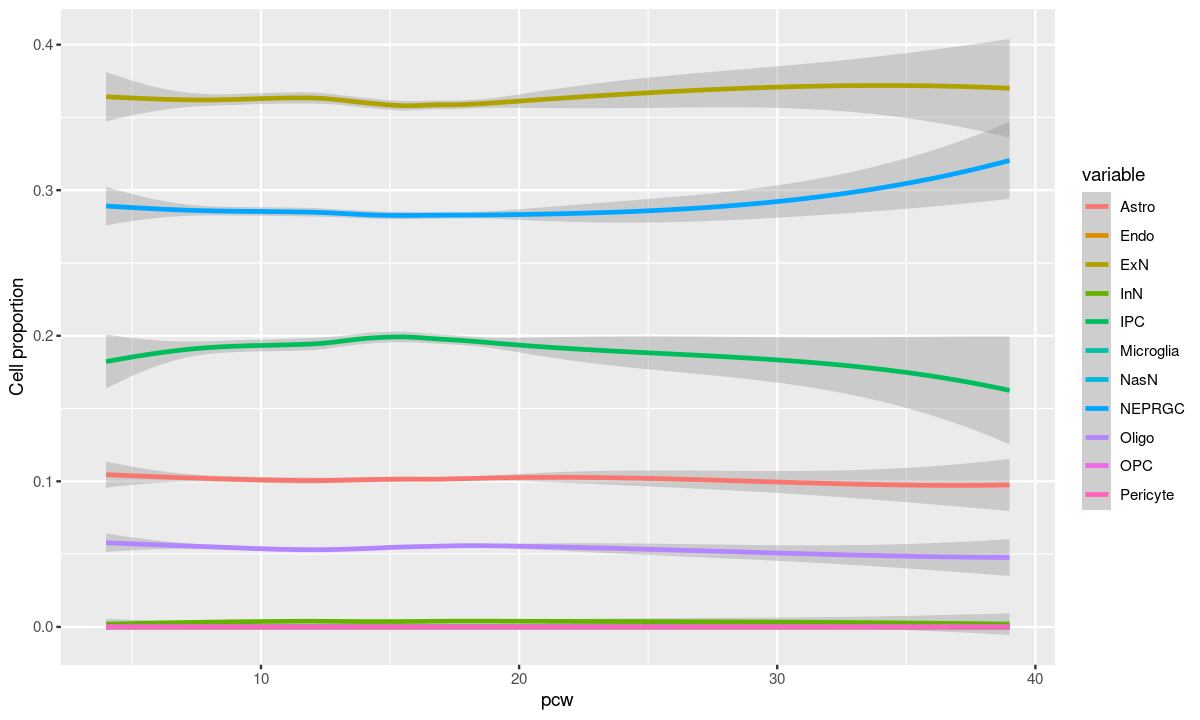

In [174]:
ggplot(prop, aes(x = pcw, y = value, color = variable))+
    geom_smooth()+
    labs(y='Cell proportion')

In [4]:
seurat_obj <- NormalizeData(seurat_obj)
seurat_obj <- ScaleData(seurat_obj)
Idents(object = seurat_obj) <- seurat_obj$super_cluster

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have pipe characters ('|'), replacing with dashes ('-')”
Centering and scaling data matrix



In [40]:
markers <- FindAllMarkers(seurat_obj)

Calculating cluster ExN

Calculating cluster InN

Calculating cluster IPC

Calculating cluster NasN

Calculating cluster NEPRGC

Calculating cluster OPC



In [47]:
write.table(markers, "../li2018_markergenes_customize.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

In [17]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [46]:
markers %>%
  group_by(cluster) %>%
  slice_head(n = 5)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster
1  1.103118e-38  2.3665580 0.936 0.470 6.635805e-34 ExN    
2  1.858487e-38  1.0700860 0.651 0.133 1.117973e-33 ExN    
3  8.145617e-38  0.5224236 0.541 0.083 4.899996e-33 ExN    
4  8.559710e-36  2.0746767 1.000 0.764 5.149093e-31 ExN    
5  1.091659e-35  1.8511305 0.881 0.337 6.566872e-31 ExN    
6  4.296074e-29  1.5567171 0.821 0.167 2.584303e-24 InN    
7  1.169207e-27  1.3526936 0.769 0.134 7.033364e-23 InN    
8  1.693053e-25  1.4858392 0.410 0.033 1.018456e-20 InN    
9  4.110557e-25  4.1291461 1.000 0.467 2.472705e-20 InN    
10 3.826077e-24  4.1323127 1.000 0.535 2.301577e-19 InN    
11 5.826557e-90  1.6991325 0.853 0.108 3.504965e-85 IPC    
12 4.618634e-86  1.0566677 0.912 0.115 2.778339e-81 IPC    
13 5.369797e-78  0.6676934 0.794 0.095 3.230201e-73 IPC    
14 1.521483e-74  0.5233562 0.829 0.130 9.152481e-70 IPC    
15 1.889158e-70  0.6110138 0.671 0.057 1.136423e-65 IPC    
16 6.291314e-40 -1.0742351 0.292 0.856 3.784540e-35 NasN   
17 4.279326e-38 -2.3840412 0.327 0.810 2.574228e-33 NasN   
18 5.204606e-38 -1.2337724 0.140 0.750 3.130831e-33 NasN   
19 2.903138e-35 -0.7965320 0.111 0.679 1.746382e-30 NasN   
20 6.362463e-35 -0.8596458 0.140 0.717 3.827339e-30 NasN   
21 4.695607e-62  0.5842409 0.573 0.034 2.824643e-57 NEPRGC 
22 5.521650e-59  0.7419951 0.661 0.078 3.321549e-54 NEPRGC 
23 6.397194e-56  0.8269386 0.573 0.050 3.848232e-51 NEPRGC 
24 3.296687e-54  0.9700695 0.645 0.078 1.983122e-49 NEPRGC 
25 8.087817e-53  0.8183878 0.524 0.039 4.865226e-48 NEPRGC 
26 1.409281e-41  1.4096971 0.970 0.132 8.477531e-37 OPC    
27 2.296687e-41  2.1917302 0.970 0.132 1.381572e-36 OPC    
28 3.792077e-40  2.1886883 0.848 0.095 2.281124e-35 OPC    
29 1.435081e-38  0.7837403 0.939 0.129 8.632730e-34 OPC    
30 2.104955e-35  2.4947151 0.818 0.102 1.266236e-30 OPC    
   gene                        
1  ENSG00000119042-SATB2       
2  ENSG00000183287-CCBE1       
3  ENSG00000165084-C8ORF34     
4  ENSG00000104435-STMN2       
5  ENSG00000235597-LINC01102   
6  ENSG00000115844-DLX2        
7  ENSG00000105880-DLX5        
8  ENSG00000079689-SCGN        
9  ENSG00000178568-ERBB4       
10 ENSG00000231764-DLX6-AS1    
11 ENSG00000147488-ST18        
12 ENSG00000106341-PPP1R17     
13 ENSG00000171786-NHLH1       
14 ENSG00000225472-RP11-120J1.1
15 ENSG00000156140-ADAMTS3     
16 ENSG00000165699-TSC1        
17 ENSG00000081189-MEF2C       
18 ENSG00000185070-FLRT2       
19 ENSG00000150672-DLG2        
20 ENSG00000085365-SCAMP1      
21 ENSG00000128610-FEZF1       
22 ENSG00000143320-CRABP2      
23 ENSG00000139219-COL2A1      
24 ENSG00000081479-LRP2        
25 ENSG00000165588-OTX2        
26 ENSG00000184221-OLIG1       
27 ENSG00000160307-S100B       
28 ENSG00000189058-APOD        
29 ENSG00000205927-OLIG2       
30 ENSG00000147588-PMP2

**keep genes that were expressed in >50% of cells**

In [10]:
ncol(seurat_obj)

ERROR: Error in ncol(seurat_obj): object 'seurat_obj' not found


In [6]:
cell_gene_matrix <- seurat_obj@assays$RNA@counts

In [17]:
cell_gene_matrix[1:4,1:4]

4 x 4 sparse Matrix of class "dgCMatrix"
                       C1-29-B8_CAGAGAGG-CTCTCTAT_L003_R1_all
ENSG00000000003-TSPAN6                                    319
ENSG00000000005-TNMD                                        .
ENSG00000000419-DPM1                                       60
ENSG00000000457-SCYL3                                       .
                       C1-29-E7_CTCTCTAC-GTAAGGAG_L003_R1_all
ENSG00000000003-TSPAN6                                    301
ENSG00000000005-TNMD                                        .
ENSG00000000419-DPM1                                        .
ENSG00000000457-SCYL3                                       2
                       C1-20-A1_TAAGGCGA-TAGATCGC_L001_R1_all
ENSG00000000003-TSPAN6                                      .
ENSG00000000005-TNMD                                        .
ENSG00000000419-DPM1                                        1
ENSG00000000457-SCYL3                                       1
                       C1-20-

In [24]:
sum(cell_gene_matrix[2,] > 0)

[1] 2

In [7]:
cells_with_expression <- rowSums(cell_gene_matrix > 0)
head(cells_with_expression)
range(cells_with_expression)
sum(cells_with_expression > 762*0.5)

ENSG00000000003-TSPAN6     ENSG00000000005-TNMD     ENSG00000000419-DPM1 
                     464                        2                      369 
   ENSG00000000457-SCYL3 ENSG00000000460-C1ORF112      ENSG00000000938-FGR 
                     228                      197                       14

[1]   0 762

[1] 3841

In [8]:
genes_expressed_50_percent <- names(which(cells_with_expression > 762*0.5))

In [9]:
length(genes_expressed_50_percent)

[1] 3841

In [10]:
head(genes_expressed_50_percent)

[1] "ENSG00000000003-TSPAN6" "ENSG00000001629-ANKIB1" "ENSG00000001631-KRIT1" 
[4] "ENSG00000002016-RAD52"  "ENSG00000003402-CFLAR"  "ENSG00000003756-RBM5"

In [11]:
seurat_object_filtered <- subset(seurat_obj, features = genes_expressed_50_percent)
ncol(seurat_object_filtered)

Warning message in cells.idents["NA"] <- names(x = which(x = is.na(x = Idents(object = object)[cells]))):
“number of items to replace is not a multiple of replacement length”


[1] 647

In [13]:
seurat_obj

An object of class Seurat 
60155 features across 762 samples within 1 assay 
Active assay: RNA (60155 features, 0 variable features)

In [12]:
seurat_object_filtered

An object of class Seurat 
3841 features across 647 samples within 1 assay 
Active assay: RNA (3841 features, 0 variable features)

In [14]:
markers_filtered <- FindAllMarkers(seurat_object_filtered)

Calculating cluster ExN

Calculating cluster InN

Calculating cluster IPC

Calculating cluster NasN

Calculating cluster NEPRGC

Calculating cluster OPC



In [16]:
write.table(markers_filtered, "../li2018_markergenes_filtered.tsv", col.names = T, row.names = F, quote = F, sep = "\t")

In [19]:
markers_filtered %>%
  group_by(cluster) %>%
  slice_head(n = 8)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster
1  1.580623e-45  2.7216158 0.936 0.407 6.071173e-42 ExN    
2  1.510523e-40 -3.0086212 0.385 0.929 5.801920e-37 ExN    
3  6.664693e-39  1.7350666 0.927 0.349 2.559909e-35 ExN    
4  3.802532e-38  2.6335906 0.991 0.586 1.460553e-34 ExN    
5  8.456222e-38  1.8143259 0.927 0.385 3.248035e-34 ExN    
6  4.035186e-36  1.4708368 0.963 0.470 1.549915e-32 ExN    
7  9.204147e-36  1.9093743 0.991 0.636 3.535313e-32 ExN    
8  1.166886e-35  2.1171133 1.000 0.725 4.482007e-32 ExN    
9  2.217569e-25  4.2329177 1.000 0.465 8.517682e-22 InN    
10 8.595650e-21  3.0504877 0.974 0.747 3.301589e-17 InN    
11 4.752238e-17  2.4963743 1.000 0.896 1.825334e-13 InN    
12 1.271729e-15  1.5108575 1.000 1.000 4.884710e-12 InN    
13 8.956845e-14 -2.1450675 0.410 0.847 3.440324e-10 InN    
14 1.052888e-13 -3.2665494 0.308 0.831 4.044144e-10 InN    
15 1.300603e-13  1.5112613 1.000 0.982 4.995618e-10 InN    
16 1.805172e-13 -2.2508196 0.718 0.961 6.933666e-10 InN    
17 7.564844e-55  1.7845727 1.000 0.849 2.905657e-51 IPC    
18 7.025836e-50  1.4145284 0.982 0.430 2.698624e-46 IPC    
19 5.259741e-49  0.5445637 0.988 0.415 2.020266e-45 IPC    
20 1.725295e-46  0.8942647 0.947 0.421 6.626856e-43 IPC    
21 2.415332e-46  0.7190747 0.953 0.352 9.277292e-43 IPC    
22 3.408353e-46  1.5748283 0.976 0.438 1.309148e-42 IPC    
23 2.258510e-44  1.3977764 1.000 0.927 8.674938e-41 IPC    
24 2.663876e-40  0.8092675 0.971 0.457 1.023195e-36 IPC    
25 5.650541e-40 -1.1431673 0.292 0.859 2.170373e-36 NasN   
26 9.386626e-37 -1.3315951 0.140 0.746 3.605403e-33 NasN   
27 4.271710e-34 -0.8365950 0.140 0.723 1.640764e-30 NasN   
28 4.051433e-32 -0.8042666 0.111 0.658 1.556155e-28 NasN   
29 4.503241e-32 -1.0612998 0.620 0.973 1.729695e-28 NasN   
30 5.227533e-32 -0.6895594 0.251 0.851 2.007895e-28 NasN   
31 1.264595e-31 -0.9012269 0.287 0.832 4.857310e-28 NasN   
32 3.436078e-31 -0.5377425 0.310 0.861 1.319798e-27 NasN   
33 7.910180e-43 -3.3437264 0.258 0.893 3.038300e-39 NEPRGC 
34 2.182751e-39 -2.3306856 0.185 0.826 8.383947e-36 NEPRGC 
35 1.237297e-37 -2.5447506 0.113 0.776 4.752459e-34 NEPRGC 
36 2.517150e-37  2.1805207 0.911 0.449 9.668373e-34 NEPRGC 
37 4.306159e-37  1.8967232 0.944 0.476 1.653996e-33 NEPRGC 
38 2.318302e-35 -1.0965707 0.032 0.709 8.904597e-32 NEPRGC 
39 3.255131e-35 -1.8346591 0.097 0.771 1.250296e-31 NEPRGC 
40 2.001732e-34 -1.4417039 0.153 0.759 7.688653e-31 NEPRGC 
41 6.160017e-20  2.2925918 1.000 0.946 2.366063e-16 OPC    
42 2.932196e-19  2.0185425 1.000 0.700 1.126257e-15 OPC    
43 1.400174e-18  2.0158502 1.000 0.511 5.378070e-15 OPC    
44 9.615747e-18  2.2115830 1.000 0.717 3.693408e-14 OPC    
45 2.435542e-17  2.1666654 1.000 0.704 9.354916e-14 OPC    
46 2.612148e-16  2.5392997 1.000 0.767 1.003326e-12 OPC    
47 5.858020e-16  1.6376954 1.000 0.708 2.250065e-12 OPC    
48 9.976166e-16  1.4854903 0.939 0.435 3.831845e-12 OPC    
   gene                    
1  ENSG00000119042-SATB2   
2  ENSG00000164104-HMGB2   
3  ENSG00000134121-CHL1    
4  ENSG00000081189-MEF2C   
5  ENSG00000155926-SLA     
6  ENSG00000182667-NTM     
7  ENSG00000033122-LRRC7   
8  ENSG00000104435-STMN2   
9  ENSG00000231764-DLX6-AS1
10 ENSG00000242808-SOX2-OT 
11 ENSG00000077279-DCX     
12 ENSG00000124766-SOX4    
13 ENSG00000026025-VIM     
14 ENSG00000131747-TOP2A   
15 ENSG00000196628-TCF4    
16 ENSG00000111716-LDHB    
17 ENSG00000162599-NFIA    
18 ENSG00000139289-PHLDA1  
19 ENSG00000008441-NFIX    
20 ENSG00000103647-CORO2B  
21 ENSG00000111859-NEDD9   
22 ENSG00000164600-NEUROD6 
23 ENSG00000147862-NFIB    
24 ENSG00000184156-KCNQ3   
25 ENSG00000165699-TSC1    
26 ENSG00000185070-FLRT2   
27 ENSG00000085365-SCAMP1  
28 ENSG00000150672-DLG2    
29 ENSG00000257621-FLJ31306
30 ENSG00000068796-KIF2A   
31 ENSG00000197603-C5ORF42 
32 ENSG00000073921-PICALM  
33 ENSG00000104435-STMN2   
34 ENSG00000179915-NRXN1   
35 ENSG00000120251-GRIA2   
36 ENSG00000146197-SCUBE3  
37 ENSG00000145721-LIX1    